In [1]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.dynamics.single_track import SingleTrack
from pit.parameters import NormalParameterGroup, CovariantNormalParameterGroup, PointParameterGroup
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DEVICE = "cpu"
print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# # visualization
# with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
#     data = json.load(f)

with open('synced_data_irl.json', 'r') as f:
     data = json.load(f)

cpu


In [2]:
def yaw_normalized_loss(output_states, target_states):
    normal_loss_p1 = torch.nn.functional.l1_loss(output_states[...,:3], target_states[...,:3])
    normal_loss_p2 = torch.nn.functional.l1_loss(output_states[...,4:], target_states[...,4:])
    angular_loss = torch.mean(torch.atan2(torch.sin(output_states[...,3] - target_states[..., 3]), torch.cos(output_states[...,3]- target_states[..., 3])))
    return normal_loss_p1 + normal_loss_p2 + angular_loss

In [3]:
# %%
timestep = 0.03
# assert(data['time'][1] - data['time'][0] - timestep < 0.001)
FIRST = 300
LAST = 10
x = torch.tensor(data['x'][FIRST:-LAST])
y = torch.tensor(data['y'][FIRST:-LAST])
yaw = torch.tensor(data['yaw'][FIRST:-LAST])
vx = torch.tensor(data['vx'][FIRST:-LAST])
vy = torch.tensor(data['vy'][FIRST:-LAST])
yaw_rate = torch.tensor(data['yaw_rate'][FIRST:-LAST])
steer_angle = torch.tensor(data['steer_angle'][FIRST:-LAST])
# drive_force = torch.tensor(data['drive_force'])
# steer_speed = torch.tensor(data['steer_speed'])
# time = torch.tensor(data['time'])
# FIRST = 100
# LAST = 1000
# x = torch.tensor(data['x'][FIRST:-LAST])
# y = torch.tensor(data['y'][FIRST:-LAST])
# yaw = torch.tensor(data['yaw'][FIRST:-LAST])
# yaw_rate = torch.tensor(data['yaw_rate'][FIRST:-LAST])
# steer_angle = torch.tensor(data['steer_angle'][FIRST:-LAST])
accel = torch.tensor(data['linear_acceleration_x'][FIRST:-LAST])
accel = -1 * accel
# delta_times = torch.tensor(data['dt'][FIRST:-LAST])
# time = torch.tensor(data['time'])#[FIRST:-LAST])
try:
    delta_times = torch.tensor(data['dt'])
except KeyError:
    delta_times = time[1:] - time[:-1]
delta_times = delta_times[FIRST:-LAST]
# vx = torch.tensor(data['vx'][FIRST:-LAST])
# vy = torch.tensor(data['vy'][FIRST:-LAST])

# vy = -1 * vy
# vx = -1 * vx
# drive_force = accel * 15.2
#Get the velocity array from vx and vy
v = torch.norm(torch.stack([vx, vy], dim=0), dim=0)
#get accel by taking the derivative of velocity over time dv/dt
# accel = torch.zeros_like(v)
# accel[1:] = (v[1:] - v[:-1]) / (time[1:] - time[:-1])

# accel = 
#Get the slip angle array from vx and vy
slip_angle = torch.atan2(vy, vx)
slip_angle = -1 * slip_angle

#get accel from dv /dt
# accel = torch.zeros_like(v)
accel = torch.diff(v) / delta_times[1:]


# Trim the last element of the arrays to make them the same length
x = x[:-1]
y = y[:-1]
yaw = yaw[:-1]
yaw_rate = yaw_rate[:-1]
steer_angle = steer_angle[:-1]
v = v[:-1]
slip_angle = slip_angle[:-1]
delta_times = delta_times[1:]


In [4]:
friction_zones = [
    {'friction': 0.2, 'x_min': -40, 'x_max': 40, 'learned_mu': 1.317623010141823, 'learned_Csf': 20.030000686645508, 'learned_Csr': 20.030000686645508},
    {'friction': 0.4, 'x_min': 40, 'x_max': 120, 'learned_mu': 1.625175952911377, 'learned_Csf': 20.030000686645508, 'learned_Csr': 20.030000686645508},
    {'friction': 0.6, 'x_min': 120, 'x_max': 200, 'learned_mu': 2.847452402114868, 'learned_Csf': 20.426822662353516, 'learned_Csr': 19.829561233520508},
    {'friction': 0.8, 'x_min': 200, 'x_max': 280, 'learned_mu': 3.6442818641662598, 'learned_Csf': 20.774690628051758, 'learned_Csr': 19.597314834594727}
]

In [5]:
# # ## Slice data to friction areas
# # # Friction areas
# friction_zones = [
#     {'friction': 0.2, 'x_min': -40, 'x_max': 40},
#     {'friction': 0.4, 'x_min': 40, 'x_max': 120},
#     {'friction': 0.6, 'x_min': 120, 'x_max': 200},
#     {'friction': 0.8, 'x_min': 200, 'x_max': 280}
# ]

# # # Extract first friction area
# friction_mask = (x >= friction_zones[0]['x_min']) & (x < friction_zones[0]['x_max'])

# # Now slice each tensor to fit the friction area (x between -40 and 40)
# x = x[friction_mask]
# y = y[friction_mask]
# yaw = yaw[friction_mask]
# yaw_rate = yaw_rate[friction_mask]
# steer_angle = steer_angle[friction_mask]
# v = v[friction_mask]
# slip_angle = slip_angle[friction_mask]
# accel = accel[friction_mask]
# delta_times = delta_times[friction_mask]


In [6]:
print(delta_times.shape)

torch.Size([3524])


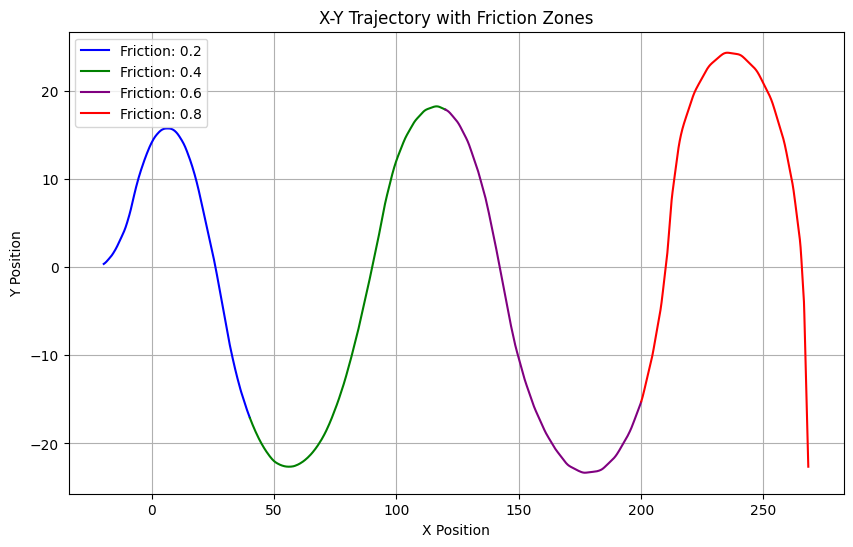

In [7]:
# Prepare the plot
plt.figure(figsize=(10, 6))
plt.title('X-Y Trajectory with Friction Zones')

# Define colors for each friction zone
colors = ['blue', 'green', 'purple', 'red']

# Loop through each friction zone and plot data with different colors
for i, zone in enumerate(friction_zones):
    # Create a mask for the current friction zone
    mask = (x >= zone['x_min']) & (x < zone['x_max'])
    
    # Extract x and y values corresponding to this friction zone
    x_zone = x[mask]
    y_zone = y[mask]

    # Plot the trajectory for this friction zone
    plt.plot(x_zone, y_zone, label=f"Friction: {zone['friction']}", color=colors[i])

# Add labels and legend
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)

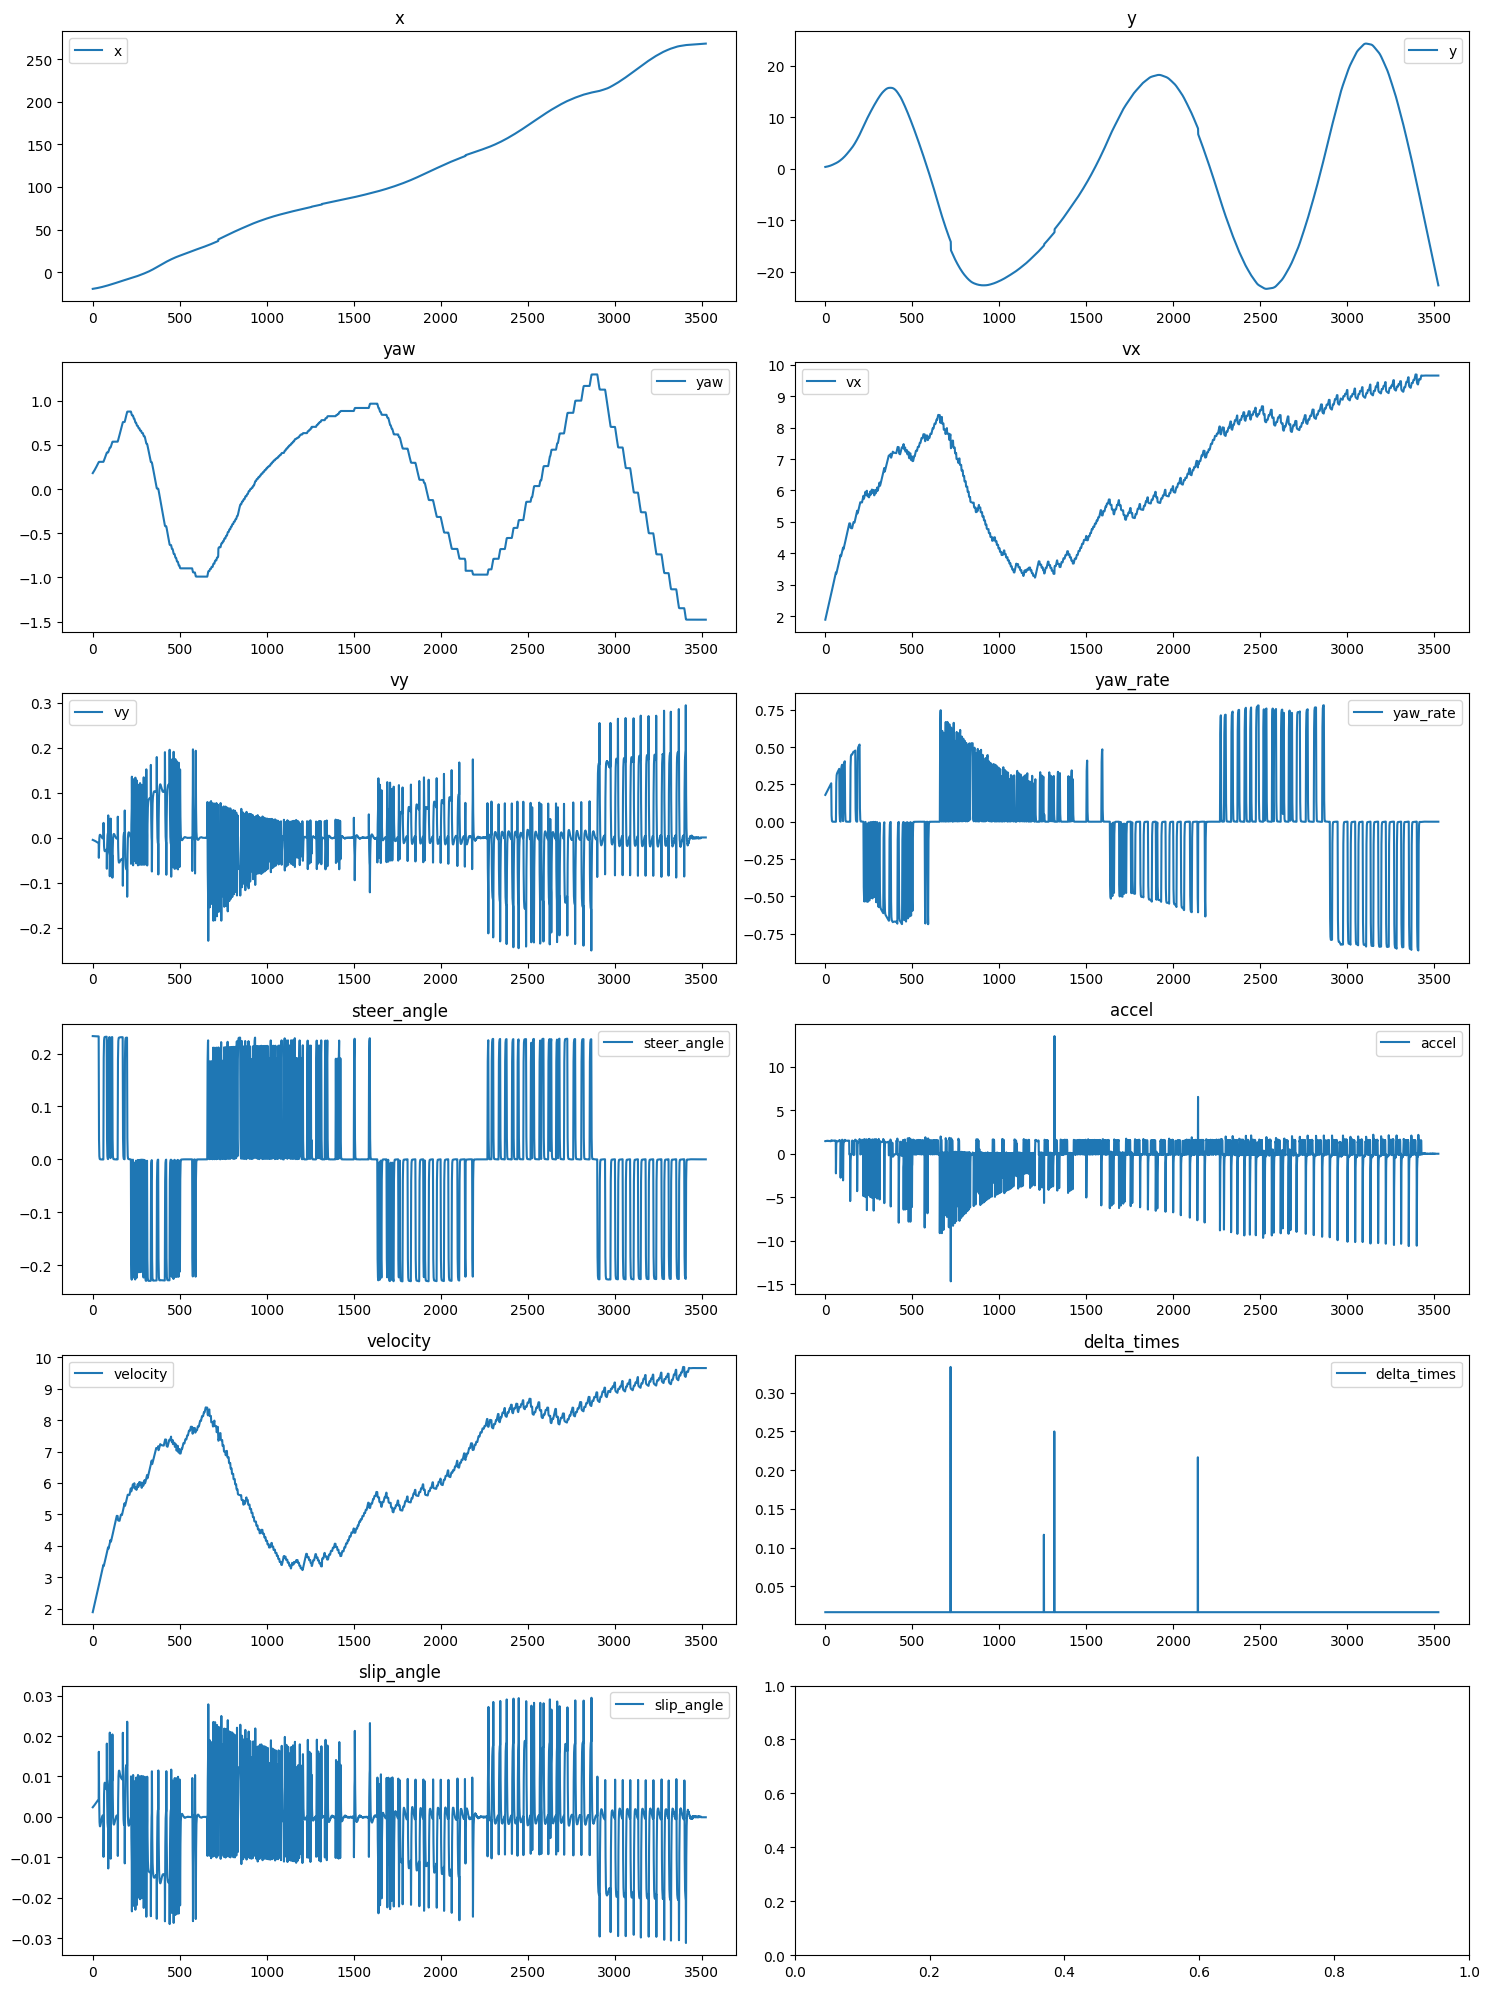

In [8]:
# Plot each tensor
fig, axs = plt.subplots(6, 2, figsize=(15, 20))

# Plot x and y
axs[0, 0].plot(x.numpy(), label='x')
axs[0, 0].set_title('x')
axs[0, 0].legend()

axs[0, 1].plot(y.numpy(), label='y')
axs[0, 1].set_title('y')
axs[0, 1].legend()

# Plot yaw and vx
axs[1, 0].plot(yaw.numpy(), label='yaw')
axs[1, 0].set_title('yaw')
axs[1, 0].legend()

axs[1, 1].plot(vx.numpy(), label='vx')
axs[1, 1].set_title('vx')
axs[1, 1].legend()

# Plot vy and yaw_rate
axs[2, 0].plot(vy.numpy(), label='vy')
axs[2, 0].set_title('vy')
axs[2, 0].legend()

axs[2, 1].plot(yaw_rate.numpy(), label='yaw_rate')
axs[2, 1].set_title('yaw_rate')
axs[2, 1].legend()

# Plot steer_angle and accel
axs[3, 0].plot(steer_angle.numpy(), label='steer_angle')
axs[3, 0].set_title('steer_angle')
axs[3, 0].legend()

axs[3, 1].plot(accel.numpy(), label='accel')
axs[3, 1].set_title('accel')
axs[3, 1].legend()

# # Plot steer_speed and delta_times
axs[4, 0].plot(v.numpy(), label='velocity')
axs[4, 0].set_title('velocity')
axs[4, 0].legend()

axs[4, 1].plot(delta_times.numpy(), label='delta_times')
axs[4, 1].set_title('delta_times')
axs[4, 1].legend()
# axs[4, 1].set_yscal

axs[5, 0].plot(slip_angle.numpy(), label='slip_angle')
axs[5, 0].set_title('slip_angle')
axs[5, 0].legend()

# axs[5, 1].plot(untranslated_vy.numpy(), label='untranslated_vy')
# axs[5, 1].set_title('untranslated_vy')
# axs[5, 1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [9]:
# yaw.max()
# drive_force = accel * 15.2
# drive_force = drive_force[:-1]
# steer_speed = (steer_angle[1:] - steer_angle[:-1]) / delta_times[:-1]

In [10]:
# # state = [X Y V YAW YAW_RATE SLIP_ANGLE]
# initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)

initial_state = torch.tensor([x[0],y[0],v[0],yaw[0],yaw_rate[0],slip_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([steer_angle, accel]).T
control_inputs = control_inputs.contiguous().to(DEVICE)[:-1]
# control_inputs = torch.vstack([drive_force, steer_speed]).T
# control_inputs = control_inputs.contiguous().to(DEVICE)
# output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
output_states = torch.vstack([x, y, v, yaw, yaw_rate, slip_angle]).T
target_states = output_states[1:]
target_states = target_states.contiguous().to(DEVICE)


print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([3523, 2]) | States size: torch.Size([3523, 6])


In [11]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=10
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)
batched_delta_time = torch.zeros((total_steps, TICKS_IN_STEP), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*  STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]
    batched_delta_time[step] = delta_times[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([351, 10, 2]) | Batched States size: torch.Size([351, 10, 6])


In [12]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states, batched_delta_time)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [13]:
# %%
"""
# san_paulo_single_track_params = {
#     'l': 0.8,
#     'w': 0.55,
#     # axes distances
#     'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'm': 1225.887,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'hcg': 0.0,  # [rad/m]  DF
#     'Csf': 1.3507,
#     'mu' : 1.1,
#     'Csr': 1.3507,

# }

# params = {
#     # axes distances
#     'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'mass': 1225.887,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'Df': 3709.08227,  # [rad/m]  DF
#     'Cf': 1.3507,
#     'Bf': 16.2216,
#     'Dr': 3709.08227,  # [rad/m]  DR
#     'Cr': 1.3507,
#     'Br': 16.2216,
#     'Cm': 0.3777,
#     'Cr0': 2.1469,
#     'Cr2': 0.0,
# }


# params_cinnamon = {
#     # axes distances
#     'lf': 0.2725,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 0.2585,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 0.6433215993,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'mass': 15.32,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'Df': 3709.08227,  # [rad/m]  DF
#     'Cf': 1.3507,
#     'Bf': 16.2216,
#     'Dr': 3709.08227,  # [rad/m]  DR
#     'Cr': 1.3507,
#     'Br': 16.2216,
#     'Cm': 0.3777,
#     'Cr0': 2.1469,
#     'Cr2': 0.0,
# }

# single_track_params = {
#     # Length and width of the vehicle
#     'l': 0.8,
#     'w': 0.55, 

    
#     # moments of inertia of sprung mass
#     # masses
#     'm': 15.32,  # vehicle mass [kg]  MASS
#     'Iz': 0.64332,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    
#     # axes distancelinear_acceleration_x # height of the center of gravity [m]  HCG

#     # tire cornering stiffness
#     'Csf': 0.03,  # front tire cornering stiffness [N/rad]  CF
#     'Csr': 0.03,  # rear tire cornering stiffness [N/rad]  CR

#     # tire friction coefficient
#     'mu': 0.7,  # tire friction coefficient  MU

# }
"""
awsim_params = {
    # Length and width of the vehicle
    'l': 2.5,
    'w': 1.8, 

    
    # moments of inertia of sprung mass
    # masses
    'm': 1500.0,  # vehicle mass [kg]  MASS
    'Iz': 2000.0,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    
    # axes distances
    'lf': 0.75,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 1.75,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # height of the center of gravity
    'hcg': 0.1825,  # height of the center of gravity [m]  HCG

    # tire cornering stiffness
    'Csf': 20.03,  # front tire cornering stiffness [N/rad]  CF
    'Csr': 20.03,  # rear tire cornering stiffness [N/rad]  CR

    # tire friction coefficient
    'mu': 1.1,  # tire friction coefficient  MU

}

# awsim_params.update(
# {
# 	"l" : 2.5,
# 	"w" : 1.7999999523162842,
# 	"m" : 1500.0,
# 	"Iz" : 2000.0,
# 	"lf" : 0.75,
# 	"lr" : 1.75,
# 	"hcg" : 0.18250000476837158,
# 	"Csf" : 20.994125366210938,
# 	"Csr" : 19.010753631591797,
# 	"mu" : 1.2951564845373873,
# }
# )

# )

"""

# awsim_dynamic_bycicle_params = {
#     #     # axes distances
#     'lf': 0.75,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.75,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 2000.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'mass': 1500.887,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'Df': 3709.08227,  # [rad/m]  DF
#     'Cf': 20.3507,
#     'Bf': 16.2216,
#     'Dr': 3709.08227,  # [rad/m]  DR
#     'Cr': 20.3507,
#     'Br': 16.2216,
#     'Cm': 0.3777,
#     'Cr0': 2.1469,
#     'Cr2': 0.0,
# }
# awsim_dynamic_bycicle_params.update(
# {
# 	"lf" : 0.75,
# 	"lr" : 1.75,
# 	"Iz" : 2000.8533935546875,
# 	"mass" : 1500.886962890625,
# 	"Df" : 3709.082275390625,
# 	"Cf" : 20.359413146972656,
# 	"Bf" : 16.22726058959961,
# 	"Dr" : 3709.082275390625,
# 	"Cr" : 20.352888107299805,
# 	"Br" : 16.220178604125977,
# 	"Cm" : 0.37744325399398804,
# 	"Cr0" : 2.146899938583374,
# 	"Cr2" : -0.00025437455042265356,
# })

# single_track_params = {
# 	"l" : 0.800000011920929,
# 	"w" : 0.550000011920929,
# 	"m" : 15.319999694824219,
# 	"Iz" : 0.6433200240135193,
# 	"lf" : 0.02734999917447567,
# 	"lr" : 0.025849999859929085,
# 	"hcg" : 0.1875,
# 	"Csf" : 5.042203903198242,
# 	"Csr" : 5.3044939041137695,
# 	"mu" : 0.03344631940126419,
# }

# san_paulo_single_track_params = {
#     'l': 0.8,
#     'w': 0.55,
#     # axes distances
#     'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'm': 1225.887,  # vehicle mass [kg]  MASS

#     'hcg': 0.0,  # [rad/m]  DF
#     'Csf': 3.3564612865448,
#     'mu' : 1.1,
#     'Csr': 2.1139602661132812,

# }

# san_paulo_single_track_params.update(
# {
# 	"l" : 0.800000011920929,
# 	"w" : 0.550000011920929,
# 	"m" : 1225.886962890625,
# 	"Iz" : 1538.8533935546875,
# 	"lf" : 0.8839200139045715,
# 	"lr" : 1.5087599754333496,
# 	"hcg" : 0.0,
# 	"Csf" : 3.1625421047210693,
# 	"Csr" : 3.260910749435425,
# 	"mu" : 2.472494602203369,
# }
# )





# params.update({
# 	"lf" : 0.8839200139045715,
# 	"lr" : 1.5087599754333496,
# 	"Iz" : 1538.8533935546875,
# 	"mass" : 1225.886962890625,
# 	"Df" : 3709.082275390625,
# 	"Cf" : 2.6947877407073975,
# 	"Bf" : 16.383142471313477,
# 	"Dr" : 3709.082275390625,
# 	"Cr" : 1.7377768754959106,
# 	"Br" : 16.258201599121094,
# 	"Cm" : 0.95799320936203,
# 	"Cr0" : 2.147186756134033,
# 	"Cr2" : 0.001327928970567882,
# }
# )
# dynamics = DynamicBicycle(**awsim_dynamic_bycicle_params)
"""
dynamics = SingleTrack(**awsim_params)
param_group = PointParameterGroup(dynamics.parameter_list, awsim_params)

# Disable gradients for physical parameters
for param in ['l', 'w', 'lf', 'lr', 'Iz', 'm', 'hcg']:
#     param_group.disable_gradients(param)
# for param in ['lf', 'lr', 'Iz', 'mass']:
    param_group.disable_gradients(param)

for param in ['Csf', 'Csr','mu']:
#     param_group.enable_gradients(param)
# for param in ['Df', 'Cf', 'Bf', 'Dr', 'Cr', 'Br', 'Cm', 'Cr0', 'Cr2']:
    param_group.enable_gradients(param)
    
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
# dynamics.lf.requires_grad = False
# dynamics.lr.requires_grad = False
# dynamics.mass.requires_grad = False
# dynamics.Iz.requires_grad = False
# dynamics.Df.requires_grad = True
# dynamics.Cf.requires_grad = True
# dynamics.Bf.requires_grad = True
# dynamics.Dr.requires_grad = True
# dynamics.Cr.requires_grad = True
# dynamics.Br.requires_grad = True
# dynamics.Cm.requires_grad = True
# dynamics.Cr0.requires_grad = True
# dynamics.Cr2.requires_grad = True
# <----                         ---->
euler_integrator = Euler(dynamics, parameters=param_group, timestep=timestep)
euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, parameters=param_group, timestep=timestep)
rk4_integrator.to(DEVICE)



RK4(
  (dynamics): SingleTrack()
  (model_params): PointParameterGroup(
    (params): ParameterDict(
        (l): Parameter containing: [torch.FloatTensor of size ]
        (w): Parameter containing: [torch.FloatTensor of size ]
        (m): Parameter containing: [torch.FloatTensor of size ]
        (Iz): Parameter containing: [torch.FloatTensor of size ]
        (lf): Parameter containing: [torch.FloatTensor of size ]
        (lr): Parameter containing: [torch.FloatTensor of size ]
        (hcg): Parameter containing: [torch.FloatTensor of size ]
        (Csf): Parameter containing: [torch.FloatTensor of size ]
        (Csr): Parameter containing: [torch.FloatTensor of size ]
        (mu): Parameter containing: [torch.FloatTensor of size ]
    )
  )
)

In [14]:
friction_zones = [
    {'friction': 0.2, 'x_min': -40, 'x_max': 40, 'learned_mu': 1.317623010141823, 'learned_Csf': 20.030000686645508, 'learned_Csr': 20.030000686645508},
    {'friction': 0.4, 'x_min': 40, 'x_max': 120, 'learned_mu': 1.625175952911377, 'learned_Csf': 20.030000686645508, 'learned_Csr': 20.030000686645508},
    {'friction': 0.6, 'x_min': 120, 'x_max': 200, 'learned_mu': 2.847452402114868, 'learned_Csf': 20.426822662353516, 'learned_Csr': 19.829561233520508},
    {'friction': 0.8, 'x_min': 200, 'x_max': 280, 'learned_mu': 3.6442818641662598, 'learned_Csf': 20.774690628051758, 'learned_Csr': 19.597314834594727}
]

In [15]:
# Define a list to collect the results
output_states_list = []

initial_state_zone = initial_state.clone()

for zone in friction_zones:
    # Apply the friction mask
    friction_mask = (x >= zone['x_min']) & (x < zone['x_max'])

    # Slice the data based on the friction mask
    x_zone = x[friction_mask]
    y_zone = y[friction_mask]
    yaw_zone = yaw[friction_mask]
    yaw_rate_zone = yaw_rate[friction_mask]
    steer_angle_zone = steer_angle[friction_mask]
    v_zone = v[friction_mask]
    slip_angle_zone = slip_angle[friction_mask]
    accel_zone = accel[friction_mask]
    delta_times_zone = delta_times[friction_mask]
    control_inputs_zone = control_inputs[friction_mask[:-1]]
    
    

    # Update the learned parameters in the model using the param_group call
    mu = zone['learned_mu']
    Csf = zone['learned_Csf']
    Csr = zone['learned_Csr']
    
    # Update the parameters in the integrator model (assuming param_group is set up properly in RK4)
    param_group.params['mu'].data = torch.tensor(mu)
    param_group.params['Csf'].data = torch.tensor(Csf)
    param_group.params['Csr'].data = torch.tensor(Csr)

    # Integrate over this friction zone
    with torch.no_grad():
        output_states = rk4_integrator(initial_state_zone, control_inputs_zone, delta_times_zone)

    initial_state_zone = output_states[-1]
    # Store the results
    output_states_list.append(output_states)

# Concatenate the results from all friction zones
final_output_states = torch.cat(output_states_list, dim=0)

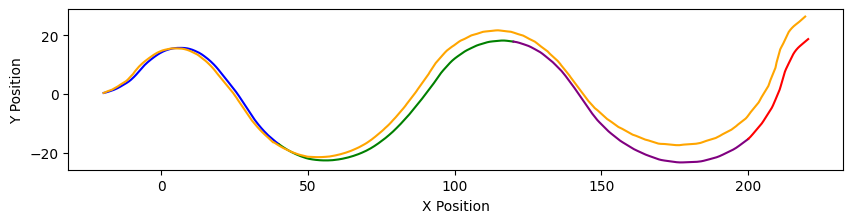

In [16]:
# Create a plot for the trajectory
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
LEN = 3000  # Adjust the length as needed

# Iterate through friction zones to plot the target states
for i, zone in enumerate(friction_zones):
    # Mask for the current friction zone based on X position
    mask = (target_states[:LEN, 0].cpu().numpy() >= zone['x_min']) & (target_states[:LEN, 0].cpu().numpy() < zone['x_max'])
    
    # Plot the target trajectory within this friction zone
    ax.plot(target_states[:LEN, 0].cpu().numpy()[mask], target_states[:LEN, 1].cpu().numpy()[mask], color=colors[i], label=f"Friction {zone['friction']}")
    
# Plot the entire predicted trajectory
ax.plot(final_output_states[:LEN, 0].detach().cpu().numpy(), final_output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction", color='orange')

# Set axis aspect ratio, labels, and legend
ax.set_aspect(1.0)
# ax.legend()
# ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.show()


In [17]:
#print out the shapes to inital state control input and delta times
# print(initial_state.shape)
# print(control_inputs.shape)
# print(delta_times.shape)
# control_inputs = control_inputs[1:]
# print(
# Ensure that the input tensors have compatible sizes
# assert control_inputs.shape[0] == delta_times.shape[0]

with torch.no_grad():
    rk4_output_states = rk4_integrator(initial_state, control_inputs, delta_times)
    # rk4_output_states = euler_integrator(initial_state, control_inputs)#, delta_times)


In [18]:
#print first five euer output states
# initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
print(rk4_output_states[10:20])

tensor([[-1.9647e+01,  3.0852e-01,  2.1610e+00,  1.1226e+04, -4.1118e+06,
         -6.4454e+07],
        [-1.9616e+01,  3.2666e-01,  2.1854e+00, -5.7304e+04,  2.0727e+07,
          2.9835e+08],
        [-1.9591e+01,  2.9978e-01,  2.2101e+00,  2.8815e+05, -1.0178e+08,
         -1.3622e+09],
        [-1.9585e+01,  2.6347e-01,  2.2346e+00, -1.4083e+06,  4.9233e+08,
          6.1357e+09],
        [-1.9614e+01,  2.8685e-01,  2.2592e+00,  6.7973e+06, -2.3263e+09,
         -2.7266e+10],
        [-1.9636e+01,  2.5609e-01,  2.2836e+00, -3.1974e+07,  1.0898e+10,
          1.1955e+11],
        [-1.9636e+01,  2.9415e-01,  2.3082e+00,  1.4966e+08, -4.9807e+10,
         -5.1736e+11],
        [-1.9598e+01,  2.8895e-01,  2.3327e+00, -6.8046e+08,  2.2463e+11,
          2.2095e+12],
        [-1.9560e+01,  2.7959e-01,  2.3569e+00,  3.0634e+09, -1.0020e+12,
         -9.3145e+12],
        [-1.9537e+01,  2.4824e-01,  2.3815e+00, -1.3637e+10,  4.3701e+12,
          3.8767e+13]])


In [19]:
rk4_output_states[:, 3].max()

tensor(nan)

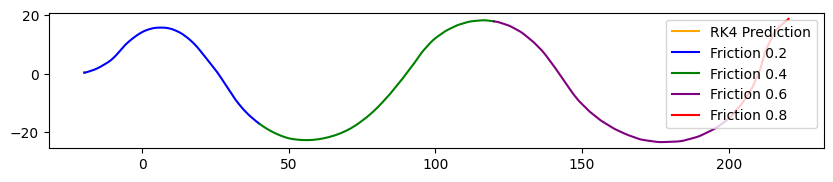

In [20]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=3000
# ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
# ax.plot(euler_output_states[:LEN, 0].detach().cpu().numpy(), euler_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction", color='orange')

# Loop through each friction zone and plot the segments of the target trajectory with different colors
for i, zone in enumerate(friction_zones):
    # Mask for the current friction zone
    mask = (target_states[:LEN, 0].cpu().numpy() >= zone['x_min']) & (target_states[:LEN, 0].cpu().numpy() < zone['x_max'])
    
    # Plot the trajectory within this friction zone
    ax.plot(target_states[:LEN, 0].cpu().numpy()[mask], target_states[:LEN, 1].cpu().numpy()[mask], color=colors[i], label=f"Friction {zone['friction']}")


ax.set_aspect(1.0)
ax.legend()

In [21]:
# %%
# from tqdm.auto import tqdm
# EPOCHS = 2000
# integrator = rk4_integrator
# optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3000, factor=0.9)

# # Define annealing parameters
# curriculum_steps = 200  # Number of steps before increasing the horizon
# eps_per_input = 20  # Epochs before increasing the horizon window
# step_size = 1  # How many extra steps to consider after each interval
# max_horizon = target_states.shape[1]  # Maximum horizon based on the data length
# initial_horizon = 10  # Initial number of steps to consider

# with torch.no_grad():
#         output_states = integrator(initial_state, control_inputs)
#         # Modulo the output states yaw to be between -pi and pi
#         output_states[:, 3] = (output_states[:, 3] + np.pi) % (2 * np.pi) - np.pi
        
#         val_loss = torch.nn.functional.l1_loss(output_states, target_states)
# print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

# losses = list()
# lrs = list()

# for epoch in tqdm(range(EPOCHS)):
#     for initial, inputs, targets, dts in dataloader:
#         # Determine the current step based on the epoch and curriculum
#         current_step = epoch // eps_per_input
#         current_horizon = min(initial_horizon + step_size * current_step, max_horizon)
        
#         integrator.train()
#         optimizer.zero_grad()
#         output_states = integrator(initial, inputs[:,:current_horizon], dts[:,:current_horizon])

#         # Check for NaNs in output_states
#         if torch.isnan(output_states).any():
#             print(f"NaN detected in output_states at Epoch: {epoch}. Breaking training loop.")
#             break

       
#         # Compute loss only for the current horizon
#         loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], targets[:, :current_horizon])


#         # Check for NaNs in loss
#         if torch.isnan(loss).any():
#             print(f"NaN detected in loss at Epoch: {epoch}. Breaking training loop.")
#             break
#         loss.backward()
#         optimizer.step()
#     #for name, param in integrator.named_parameters():
#     #    if param.requires_grad:
#     #        print(name, param.data, param.grad)
#     if epoch % 20 == 0 and False:
#         with torch.no_grad():
#             output_states = integrator(initial_state, control_inputs, dts)
#             val_loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], target_states[:, :current_horizon])

#         fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#         LEN = 20000
#         ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
#         ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
#         ax.set_aspect(1.0)
#         ax.legend()
#         plt.show()

#         print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
#     with torch.no_grad():
#         integrator.eval()
#         # output_states = integrator(batched_initial_states,batched_control_inputs, batched_delta_time)
#         output_states = integrator(batched_initial_states,batched_control_inputs)#, batched_delta_time)
#         val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
#         losses.append(val_loss.item())
#     print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
#     lrs.append(optimizer.param_groups[0]['lr'])
#     scheduler.step(val_loss)


In [22]:
from tqdm.auto import tqdm

integrator = rk4_integrator
mu_values = np.linspace(0.05, 1.4, 1000)
opt_land_mu = list()
for mu in tqdm(mu_values):
    param_group.params['mu'].data = torch.tensor(mu)
    with torch.no_grad():
        batched_output_states = integrator(batched_initial_states, batched_control_inputs, batched_delta_time)
        loss = yaw_normalized_loss(batched_output_states, batched_target_states)
    opt_land_mu.append(loss.item())
    


/home/xlab/work/virtual_envs/pcvfe_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:16<00:00, 60.10it/s]


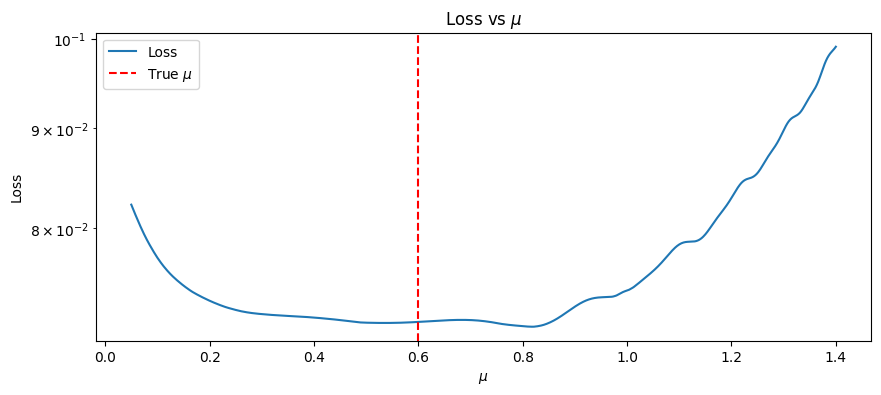

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(mu_values[:], opt_land_mu[:], label='Loss')
ax.set_xlabel('$\mu$')
ax.set_ylabel('Loss')
ax.set_title('Loss vs $\mu$')
ax.axvline(x=0.6, color='r', linestyle='--', label='True $\mu$')
ax.set_yscale('log')
plt.legend()
plt.show()

In [24]:
param_group.params['mu'].data = torch.tensor(awsim_params['mu'])

In [25]:
# %%
# from tqdm.auto import tqdm
# EPOCHS = 1000
# integrator = rk4_integrator
# optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.9)

# with torch.no_grad():
#         output_states = integrator(initial_state, control_inputs)
#         val_loss = torch.nn.functional.l1_loss(output_states, target_states)
# print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

# losses = list()
# lrs = list()

# for i in tqdm(range(EPOCHS)):
#     for initial, inputs, targets, dts in dataloader:
#         integrator.train()
#         optimizer.zero_grad()
#         output_states = integrator(initial, inputs, dts)
#         loss = torch.nn.functional.l1_loss(output_states, targets)
#         loss.backward()
#         optimizer.step()
#     #for name, param in integrator.named_parameters():
#     #    if param.requires_grad:
#     #        print(name, param.data, param.grad)
#     if i%20 == 0 and False:
#         with torch.no_grad():
#             output_states = integrator(initial_state, control_inputs, dts)
#             val_loss = torch.nn.functional.l1_loss(output_states, target_states)
#         fig, ax = plt.subplots(1, 1, figsize=(10,10))
#         LEN=20000
#         ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
#         ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
#         ax.set_aspect(1.0)
#         ax.legend()
#         plt.show()
#         print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
#     with torch.no_grad():
#         integrator.eval()
#         output_states = integrator(batched_initial_states,batched_control_inputs, batched_delta_time)
#         val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
#         losses.append(val_loss.item())
#     print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
#     lrs.append(optimizer.param_groups[0]['lr'])
#     scheduler.step(val_loss)


In [26]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt

# Initialize integrator, optimizer, scheduler
EPOCHS = 1000
integrator = rk4_integrator  # Or your euler_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.9)

# Curriculum learning parameters
curriculum_steps = 200  # Number of steps before increasing the horizon
eps_per_input = 20  # Epochs before increasing the horizon window
step_size = 1  # How many extra steps to consider after each interval
max_horizon = target_states.shape[1]  # Maximum horizon based on the data length
initial_horizon = 10  # Initial number of steps to consider

# Divergence parameters
divergence_threshold = 10.0  # Threshold for detecting divergence
reset_horizon_steps = 5  # How many steps to reduce if divergence occurs

with torch.no_grad():
    output_states = integrator(initial_state, control_inputs, delta_times)
    # Modulo the output states yaw to be between -pi and pi
    output_states[:, 3] = (output_states[:, 3] + np.pi) % (2 * np.pi) - np.pi
    # val_loss = torch.nn.functional.l1_loss(output_states, target_states)
    val_loss = yaw_normalized_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for epoch in tqdm(range(EPOCHS)):
    for initial, inputs, targets, dts in dataloader:
        # Determine the current step based on the epoch and curriculum
        current_step = epoch // eps_per_input
        current_horizon = min(initial_horizon + step_size * current_step, max_horizon)

        integrator.train()
        optimizer.zero_grad()
        output_states = integrator(initial, inputs[:, :current_horizon], dts[:, :current_horizon])

        # Check for NaNs in output_states
        if torch.isnan(output_states).any():
            print(f"NaN detected in output_states at Epoch: {epoch}. Breaking training loop.")
            break

        # Compute loss only for the current horizon
        loss = yaw_normalized_loss(output_states[:, :current_horizon], targets[:, :current_horizon])
        # loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], targets[:, :current_horizon])
        # Check for NaNs in loss
        if torch.isnan(loss).any():
            print(f"NaN detected in loss at Epoch: {epoch}. Breaking training loop.")
            break

        loss.backward()
        optimizer.step()

        # Divergence detection: Check if model diverges based on the threshold
        with torch.no_grad():
            prediction_error = torch.abs(output_states[:, :current_horizon] - targets[:, :current_horizon]).max()
            if prediction_error.item() > divergence_threshold:
                print(f"Divergence detected at Epoch: {epoch} with error {prediction_error.item()}")

                # Reset horizon to smaller window
                current_horizon = max(initial_horizon, current_horizon - reset_horizon_steps)
                print(f"Resetting horizon to {current_horizon} steps for relearning")

                # Continue training on smaller horizons
                break

    # Optional: Validation and visualization every 20 epochs
    if epoch % 20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs)
            val_loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], target_states[:, :current_horizon])

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        LEN = 20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()

        print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

    # Record loss and learning rate for future analysis
    with torch.no_grad():
        integrator.eval()
        output_states = integrator(batched_initial_states, batched_control_inputs, batched_delta_time)
        val_loss = yaw_normalized_loss(output_states, batched_target_states)
        # val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        losses.append(val_loss.item())

    print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


Initialized | Validation Loss: 1.7555240392684937 | LR: 1


  0%|          | 0/1000 [00:00<?, ?it/s]/home/xlab/work/virtual_envs/pcvfe_env/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 1/1000 [00:00<01:50,  9.03it/s]

Divergence detected at Epoch: 0 with error 22.226381301879883
Resetting horizon to 10 steps for relearning
Epoch: 0 | Training Loss: 0.07896651327610016 | Validation Loss: 0.07548342645168304 | LR: 1
Divergence detected at Epoch: 1 with error 16.949899673461914
Resetting horizon to 10 steps for relearning
Epoch: 1 | Training Loss: 0.07412005960941315 | Validation Loss: 0.07377489656209946 | LR: 1


  0%|          | 3/1000 [00:00<01:08, 14.61it/s]

Divergence detected at Epoch: 2 with error 12.318414688110352
Resetting horizon to 10 steps for relearning
Epoch: 2 | Training Loss: 0.07054777443408966 | Validation Loss: 0.0735878050327301 | LR: 1
Divergence detected at Epoch: 3 with error 10.392293930053711
Resetting horizon to 10 steps for relearning
Epoch: 3 | Training Loss: 0.06949810683727264 | Validation Loss: 0.07261436432600021 | LR: 1


  0%|          | 5/1000 [00:00<01:00, 16.58it/s]

Epoch: 4 | Training Loss: 0.06777092814445496 | Validation Loss: 0.0713525041937828 | LR: 1
Epoch: 5 | Training Loss: 0.06563687324523926 | Validation Loss: 0.07126522809267044 | LR: 1


  1%|          | 7/1000 [00:00<00:56, 17.50it/s]

Epoch: 6 | Training Loss: 0.06497811526060104 | Validation Loss: 0.07133632898330688 | LR: 1
Epoch: 7 | Training Loss: 0.06472673267126083 | Validation Loss: 0.0713963508605957 | LR: 1


  1%|          | 9/1000 [00:00<00:55, 17.98it/s]

Epoch: 8 | Training Loss: 0.06455262005329132 | Validation Loss: 0.07145846635103226 | LR: 1
Epoch: 9 | Training Loss: 0.06446290016174316 | Validation Loss: 0.07152234017848969 | LR: 1


  1%|          | 11/1000 [00:00<00:54, 18.26it/s]

Epoch: 10 | Training Loss: 0.06440888345241547 | Validation Loss: 0.07157629728317261 | LR: 1
Epoch: 11 | Training Loss: 0.06436286121606827 | Validation Loss: 0.07162737101316452 | LR: 1


  1%|▏         | 13/1000 [00:00<00:53, 18.48it/s]

Epoch: 12 | Training Loss: 0.06431081891059875 | Validation Loss: 0.07167581468820572 | LR: 1
Epoch: 13 | Training Loss: 0.06424915045499802 | Validation Loss: 0.07172061502933502 | LR: 1


  2%|▏         | 15/1000 [00:00<00:52, 18.63it/s]

Epoch: 14 | Training Loss: 0.0641750693321228 | Validation Loss: 0.07175833731889725 | LR: 1
Epoch: 15 | Training Loss: 0.06408648937940598 | Validation Loss: 0.07178620249032974 | LR: 1


  2%|▏         | 17/1000 [00:00<00:52, 18.76it/s]

Epoch: 16 | Training Loss: 0.06397873163223267 | Validation Loss: 0.07180134952068329 | LR: 1
Epoch: 17 | Training Loss: 0.06384929269552231 | Validation Loss: 0.07180164009332657 | LR: 1


  2%|▏         | 19/1000 [00:01<00:51, 18.89it/s]

Epoch: 18 | Training Loss: 0.06369759142398834 | Validation Loss: 0.0717868059873581 | LR: 1
Epoch: 19 | Training Loss: 0.06352565437555313 | Validation Loss: 0.07175944745540619 | LR: 1


  2%|▏         | 21/1000 [00:01<00:51, 18.95it/s]

Epoch: 20 | Training Loss: 0.06333884596824646 | Validation Loss: 0.07172323018312454 | LR: 1
Epoch: 21 | Training Loss: 0.06314381211996078 | Validation Loss: 0.07168342173099518 | LR: 1


  2%|▏         | 23/1000 [00:01<00:51, 18.99it/s]

Epoch: 22 | Training Loss: 0.06294874846935272 | Validation Loss: 0.07164499908685684 | LR: 1
Epoch: 23 | Training Loss: 0.0627610832452774 | Validation Loss: 0.0716109648346901 | LR: 1


  2%|▎         | 25/1000 [00:01<00:51, 19.06it/s]

Epoch: 24 | Training Loss: 0.0625857338309288 | Validation Loss: 0.07158412039279938 | LR: 1
Epoch: 25 | Training Loss: 0.062425702810287476 | Validation Loss: 0.07156383246183395 | LR: 1


  3%|▎         | 27/1000 [00:01<00:50, 19.09it/s]

Epoch: 26 | Training Loss: 0.06228112429380417 | Validation Loss: 0.07155201584100723 | LR: 1
Epoch: 27 | Training Loss: 0.062152110040187836 | Validation Loss: 0.07154674082994461 | LR: 1


  3%|▎         | 29/1000 [00:01<00:50, 19.08it/s]

Epoch: 28 | Training Loss: 0.06203747168183327 | Validation Loss: 0.07154709100723267 | LR: 1
Epoch: 29 | Training Loss: 0.06193559244275093 | Validation Loss: 0.0715508833527565 | LR: 1


  3%|▎         | 31/1000 [00:01<00:50, 19.05it/s]

Epoch: 30 | Training Loss: 0.06184425577521324 | Validation Loss: 0.07155802845954895 | LR: 1
Epoch: 31 | Training Loss: 0.061762433499097824 | Validation Loss: 0.07156742364168167 | LR: 1


  3%|▎         | 33/1000 [00:01<00:50, 18.98it/s]

Epoch: 32 | Training Loss: 0.061688803136348724 | Validation Loss: 0.0715823546051979 | LR: 1
Epoch: 33 | Training Loss: 0.061628684401512146 | Validation Loss: 0.07160019874572754 | LR: 1


  4%|▎         | 35/1000 [00:01<00:50, 18.92it/s]

Epoch: 34 | Training Loss: 0.06158461049199104 | Validation Loss: 0.07162729650735855 | LR: 1
Epoch: 35 | Training Loss: 0.06156526878476143 | Validation Loss: 0.0716487243771553 | LR: 1


  4%|▎         | 37/1000 [00:02<00:51, 18.78it/s]

Epoch: 36 | Training Loss: 0.06155455484986305 | Validation Loss: 0.07166889309883118 | LR: 1
Epoch: 37 | Training Loss: 0.06154400482773781 | Validation Loss: 0.07168889790773392 | LR: 1


  4%|▍         | 39/1000 [00:02<00:51, 18.69it/s]

Epoch: 38 | Training Loss: 0.06153309717774391 | Validation Loss: 0.07170870900154114 | LR: 1
Epoch: 39 | Training Loss: 0.061521515250205994 | Validation Loss: 0.07172854244709015 | LR: 1


  4%|▍         | 41/1000 [00:02<00:51, 18.67it/s]

Epoch: 40 | Training Loss: 0.061509571969509125 | Validation Loss: 0.07174807786941528 | LR: 1
Epoch: 41 | Training Loss: 0.06149696931242943 | Validation Loss: 0.07176734507083893 | LR: 1


  4%|▍         | 43/1000 [00:02<00:51, 18.63it/s]

Epoch: 42 | Training Loss: 0.06148369982838631 | Validation Loss: 0.07178658246994019 | LR: 1
Epoch: 43 | Training Loss: 0.061470016837120056 | Validation Loss: 0.07180555909872055 | LR: 1


  4%|▍         | 45/1000 [00:02<00:51, 18.62it/s]

Epoch: 44 | Training Loss: 0.06145636737346649 | Validation Loss: 0.07182443886995316 | LR: 1
Epoch: 45 | Training Loss: 0.06144218146800995 | Validation Loss: 0.07184302806854248 | LR: 1


  5%|▍         | 47/1000 [00:02<00:50, 18.76it/s]

Epoch: 46 | Training Loss: 0.061427291482686996 | Validation Loss: 0.07186106592416763 | LR: 1
Epoch: 47 | Training Loss: 0.061411987990140915 | Validation Loss: 0.07187896966934204 | LR: 1


  5%|▍         | 49/1000 [00:02<00:50, 18.80it/s]

Epoch: 48 | Training Loss: 0.061397768557071686 | Validation Loss: 0.07189567387104034 | LR: 1
Epoch: 49 | Training Loss: 0.06138415262103081 | Validation Loss: 0.07191085070371628 | LR: 1


  5%|▌         | 51/1000 [00:02<00:50, 18.79it/s]

Epoch: 50 | Training Loss: 0.06137252226471901 | Validation Loss: 0.07192596793174744 | LR: 1
Epoch: 51 | Training Loss: 0.06136086583137512 | Validation Loss: 0.07194045931100845 | LR: 1


  5%|▌         | 53/1000 [00:02<00:50, 18.77it/s]

Epoch: 52 | Training Loss: 0.061348848044872284 | Validation Loss: 0.07195454835891724 | LR: 1
Epoch: 53 | Training Loss: 0.061336614191532135 | Validation Loss: 0.07196827977895737 | LR: 1


  6%|▌         | 55/1000 [00:02<00:51, 18.53it/s]

Epoch: 54 | Training Loss: 0.061324141919612885 | Validation Loss: 0.07198205590248108 | LR: 1
Epoch: 55 | Training Loss: 0.0613119937479496 | Validation Loss: 0.07199474424123764 | LR: 1


  6%|▌         | 57/1000 [00:03<00:51, 18.30it/s]

Epoch: 56 | Training Loss: 0.06130069121718407 | Validation Loss: 0.07200735807418823 | LR: 1
Epoch: 57 | Training Loss: 0.061289459466934204 | Validation Loss: 0.07201912999153137 | LR: 1


  6%|▌         | 59/1000 [00:03<00:51, 18.16it/s]

Epoch: 58 | Training Loss: 0.06127897650003433 | Validation Loss: 0.0720304325222969 | LR: 1
Epoch: 59 | Training Loss: 0.06126834824681282 | Validation Loss: 0.07204141467809677 | LR: 1


  6%|▌         | 61/1000 [00:03<00:51, 18.15it/s]

Epoch: 60 | Training Loss: 0.06125768646597862 | Validation Loss: 0.07205194234848022 | LR: 1
Epoch: 61 | Training Loss: 0.06124668940901756 | Validation Loss: 0.07206186652183533 | LR: 1


  6%|▋         | 63/1000 [00:03<00:51, 18.20it/s]

Epoch: 62 | Training Loss: 0.061235249042510986 | Validation Loss: 0.07207171618938446 | LR: 1
Epoch: 63 | Training Loss: 0.06122380122542381 | Validation Loss: 0.07208111882209778 | LR: 1


  6%|▋         | 65/1000 [00:03<00:51, 18.21it/s]

Epoch: 64 | Training Loss: 0.06121200695633888 | Validation Loss: 0.07208988815546036 | LR: 1
Epoch: 65 | Training Loss: 0.0611998476088047 | Validation Loss: 0.07209856808185577 | LR: 1


  7%|▋         | 67/1000 [00:03<00:51, 18.20it/s]

Epoch: 66 | Training Loss: 0.061188600957393646 | Validation Loss: 0.07210651785135269 | LR: 1
Epoch: 67 | Training Loss: 0.06117917224764824 | Validation Loss: 0.07211410254240036 | LR: 1


  7%|▋         | 69/1000 [00:03<00:50, 18.44it/s]

Epoch: 68 | Training Loss: 0.06117057800292969 | Validation Loss: 0.07212106883525848 | LR: 1
Epoch: 69 | Training Loss: 0.061162084341049194 | Validation Loss: 0.07212790846824646 | LR: 1


  7%|▋         | 71/1000 [00:03<00:49, 18.62it/s]

Epoch: 70 | Training Loss: 0.061154380440711975 | Validation Loss: 0.07213395088911057 | LR: 1
Epoch: 71 | Training Loss: 0.06114846467971802 | Validation Loss: 0.0721396952867508 | LR: 1


  7%|▋         | 73/1000 [00:03<00:49, 18.78it/s]

Epoch: 72 | Training Loss: 0.06114240735769272 | Validation Loss: 0.07214555889368057 | LR: 1
Epoch: 73 | Training Loss: 0.06113641709089279 | Validation Loss: 0.07215160131454468 | LR: 1


  8%|▊         | 75/1000 [00:04<00:49, 18.83it/s]

Epoch: 74 | Training Loss: 0.061132173985242844 | Validation Loss: 0.07215643674135208 | LR: 1
Epoch: 75 | Training Loss: 0.06112939119338989 | Validation Loss: 0.07216078788042068 | LR: 1


  8%|▊         | 77/1000 [00:04<00:49, 18.58it/s]

Epoch: 76 | Training Loss: 0.061126887798309326 | Validation Loss: 0.07216465473175049 | LR: 1
Epoch: 77 | Training Loss: 0.06112529709935188 | Validation Loss: 0.07216804474592209 | LR: 1


  8%|▊         | 79/1000 [00:04<00:49, 18.61it/s]

Epoch: 78 | Training Loss: 0.06112335994839668 | Validation Loss: 0.07217171788215637 | LR: 1
Epoch: 79 | Training Loss: 0.06112148240208626 | Validation Loss: 0.07217549532651901 | LR: 1


  8%|▊         | 81/1000 [00:04<00:49, 18.61it/s]

Epoch: 80 | Training Loss: 0.061119627207517624 | Validation Loss: 0.07217880338430405 | LR: 1
Epoch: 81 | Training Loss: 0.06111813709139824 | Validation Loss: 0.0721813440322876 | LR: 1


  8%|▊         | 83/1000 [00:04<00:50, 18.28it/s]

Epoch: 82 | Training Loss: 0.0611172690987587 | Validation Loss: 0.072183758020401 | LR: 1
Epoch: 83 | Training Loss: 0.06111672520637512 | Validation Loss: 0.07218582928180695 | LR: 1


  8%|▊         | 85/1000 [00:04<00:50, 18.25it/s]

Epoch: 84 | Training Loss: 0.0611160509288311 | Validation Loss: 0.07218807190656662 | LR: 1
Epoch: 85 | Training Loss: 0.06111551448702812 | Validation Loss: 0.07219013571739197 | LR: 1


  9%|▊         | 87/1000 [00:04<00:49, 18.48it/s]

Epoch: 86 | Training Loss: 0.06111502647399902 | Validation Loss: 0.07219178974628448 | LR: 1
Epoch: 87 | Training Loss: 0.061114516109228134 | Validation Loss: 0.07219382375478745 | LR: 1


  9%|▉         | 89/1000 [00:04<00:49, 18.40it/s]

Epoch: 88 | Training Loss: 0.06111430004239082 | Validation Loss: 0.07219583541154861 | LR: 1
Epoch: 89 | Training Loss: 0.0611138716340065 | Validation Loss: 0.0721975713968277 | LR: 1


  9%|▉         | 91/1000 [00:04<00:49, 18.48it/s]

Epoch: 90 | Training Loss: 0.06111333891749382 | Validation Loss: 0.07219935208559036 | LR: 1
Epoch: 91 | Training Loss: 0.06111283600330353 | Validation Loss: 0.07220149040222168 | LR: 1


  9%|▉         | 93/1000 [00:05<00:48, 18.57it/s]

Epoch: 92 | Training Loss: 0.061112549155950546 | Validation Loss: 0.0722031369805336 | LR: 1
Epoch: 93 | Training Loss: 0.061112336814403534 | Validation Loss: 0.0722045972943306 | LR: 1


 10%|▉         | 97/1000 [00:05<01:01, 14.72it/s]

Epoch: 94 | Training Loss: 0.061111949384212494 | Validation Loss: 0.07220599055290222 | LR: 1
Epoch: 95 | Training Loss: 0.06111174076795578 | Validation Loss: 0.0722072571516037 | LR: 1
Epoch: 96 | Training Loss: 0.06111147627234459 | Validation Loss: 0.0722084492444992 | LR: 1
Epoch: 97 | Training Loss: 0.06111111119389534 | Validation Loss: 0.07220978289842606 | LR: 1


 10%|█         | 101/1000 [00:05<01:00, 14.88it/s]

Epoch: 98 | Training Loss: 0.06111094728112221 | Validation Loss: 0.07221098989248276 | LR: 1
Epoch: 99 | Training Loss: 0.06111069396138191 | Validation Loss: 0.0722121000289917 | LR: 1
Epoch: 100 | Training Loss: 0.06111050769686699 | Validation Loss: 0.07221289724111557 | LR: 1
Epoch: 101 | Training Loss: 0.061110228300094604 | Validation Loss: 0.07221409678459167 | LR: 1


 10%|█         | 105/1000 [00:05<00:53, 16.59it/s]

Epoch: 102 | Training Loss: 0.061110205948352814 | Validation Loss: 0.07221510261297226 | LR: 1
Epoch: 103 | Training Loss: 0.061110060662031174 | Validation Loss: 0.07221617549657822 | LR: 1
Epoch: 104 | Training Loss: 0.06110984459519386 | Validation Loss: 0.07221727073192596 | LR: 1
Epoch: 105 | Training Loss: 0.0611097477376461 | Validation Loss: 0.07221825420856476 | LR: 1


 11%|█         | 109/1000 [00:06<00:50, 17.48it/s]

Epoch: 106 | Training Loss: 0.061109595000743866 | Validation Loss: 0.07221902161836624 | LR: 1
Epoch: 107 | Training Loss: 0.0611095167696476 | Validation Loss: 0.07221966236829758 | LR: 0.9
Epoch: 108 | Training Loss: 0.061109405010938644 | Validation Loss: 0.07222019135951996 | LR: 0.9
Epoch: 109 | Training Loss: 0.06110929697751999 | Validation Loss: 0.07222055643796921 | LR: 0.9


 11%|█▏        | 113/1000 [00:06<00:48, 18.23it/s]

Epoch: 110 | Training Loss: 0.0611092709004879 | Validation Loss: 0.0722208246588707 | LR: 0.9
Epoch: 111 | Training Loss: 0.06110924482345581 | Validation Loss: 0.0722210556268692 | LR: 0.9
Epoch: 112 | Training Loss: 0.06110917776823044 | Validation Loss: 0.07222070544958115 | LR: 0.9
Epoch: 113 | Training Loss: 0.06110917776823044 | Validation Loss: 0.0722208246588707 | LR: 0.9


 12%|█▏        | 117/1000 [00:06<00:46, 18.88it/s]

Epoch: 114 | Training Loss: 0.06110908091068268 | Validation Loss: 0.07222043722867966 | LR: 0.9
Epoch: 115 | Training Loss: 0.061109043657779694 | Validation Loss: 0.07222060859203339 | LR: 0.9
Epoch: 116 | Training Loss: 0.0611090250313282 | Validation Loss: 0.07222083956003189 | LR: 0.9
Epoch: 117 | Training Loss: 0.06110895797610283 | Validation Loss: 0.07222048193216324 | LR: 0.9


 12%|█▏        | 121/1000 [00:06<00:47, 18.68it/s]

Epoch: 118 | Training Loss: 0.06110895052552223 | Validation Loss: 0.0722205862402916 | LR: 0.9
Epoch: 119 | Training Loss: 0.061108846217393875 | Validation Loss: 0.07222021371126175 | LR: 0.9
Epoch: 120 | Training Loss: 0.06110881641507149 | Validation Loss: 0.07222036272287369 | LR: 0.9
Epoch: 121 | Training Loss: 0.0611087940633297 | Validation Loss: 0.07222060114145279 | LR: 0.9


 12%|█▎        | 125/1000 [00:06<00:46, 18.95it/s]

Epoch: 122 | Training Loss: 0.06110873818397522 | Validation Loss: 0.07222025096416473 | LR: 0.9
Epoch: 123 | Training Loss: 0.06110871210694313 | Validation Loss: 0.07222035527229309 | LR: 0.9
Epoch: 124 | Training Loss: 0.06110862269997597 | Validation Loss: 0.07221996039152145 | LR: 0.9
Epoch: 125 | Training Loss: 0.06110858544707298 | Validation Loss: 0.07222017645835876 | LR: 0.9


 13%|█▎        | 129/1000 [00:07<00:46, 18.78it/s]

Epoch: 126 | Training Loss: 0.06110858917236328 | Validation Loss: 0.07221968472003937 | LR: 0.9
Epoch: 127 | Training Loss: 0.06110847741365433 | Validation Loss: 0.07221987843513489 | LR: 0.9
Epoch: 128 | Training Loss: 0.061108458787202835 | Validation Loss: 0.0722200945019722 | LR: 0.9
Epoch: 129 | Training Loss: 0.061108436435461044 | Validation Loss: 0.07221966236829758 | LR: 0.9


 13%|█▎        | 133/1000 [00:07<00:46, 18.61it/s]

Epoch: 130 | Training Loss: 0.06110835820436478 | Validation Loss: 0.0722198635339737 | LR: 0.9
Epoch: 131 | Training Loss: 0.06110834330320358 | Validation Loss: 0.0722193792462349 | LR: 0.9
Epoch: 132 | Training Loss: 0.06110824644565582 | Validation Loss: 0.07221968472003937 | LR: 0.9
Epoch: 133 | Training Loss: 0.06110823154449463 | Validation Loss: 0.07221927493810654 | LR: 0.9


 14%|█▎        | 137/1000 [00:07<00:45, 18.89it/s]

Epoch: 134 | Training Loss: 0.06110817566514015 | Validation Loss: 0.07221956551074982 | LR: 0.9
Epoch: 135 | Training Loss: 0.06110813841223717 | Validation Loss: 0.07221980392932892 | LR: 0.9
Epoch: 136 | Training Loss: 0.06110813096165657 | Validation Loss: 0.0722193568944931 | LR: 0.9
Epoch: 137 | Training Loss: 0.06110804155468941 | Validation Loss: 0.07221957296133041 | LR: 0.9


 14%|█▍        | 141/1000 [00:07<00:46, 18.67it/s]

Epoch: 138 | Training Loss: 0.06110803782939911 | Validation Loss: 0.07221908867359161 | LR: 0.9
Epoch: 139 | Training Loss: 0.06110794469714165 | Validation Loss: 0.07221938669681549 | LR: 0.9
Epoch: 140 | Training Loss: 0.06110792234539986 | Validation Loss: 0.07221898436546326 | LR: 0.9
Epoch: 141 | Training Loss: 0.06110787019133568 | Validation Loss: 0.07221925258636475 | LR: 0.9


 14%|█▍        | 145/1000 [00:07<00:45, 18.78it/s]

Epoch: 142 | Training Loss: 0.061107829213142395 | Validation Loss: 0.07221882790327072 | LR: 0.9
Epoch: 143 | Training Loss: 0.06110776960849762 | Validation Loss: 0.07221909612417221 | LR: 0.9
Epoch: 144 | Training Loss: 0.06110773980617523 | Validation Loss: 0.07221870124340057 | LR: 0.9
Epoch: 145 | Training Loss: 0.06110768765211105 | Validation Loss: 0.07221893966197968 | LR: 0.9


 15%|█▍        | 149/1000 [00:08<00:45, 18.66it/s]

Epoch: 146 | Training Loss: 0.061107635498046875 | Validation Loss: 0.07221855968236923 | LR: 0.9
Epoch: 147 | Training Loss: 0.06110759079456329 | Validation Loss: 0.07221879810094833 | LR: 0.9
Epoch: 148 | Training Loss: 0.06110754981637001 | Validation Loss: 0.07221905887126923 | LR: 0.9
Epoch: 149 | Training Loss: 0.06110754609107971 | Validation Loss: 0.07221859693527222 | LR: 0.9


 15%|█▌        | 153/1000 [00:08<00:45, 18.51it/s]

Epoch: 150 | Training Loss: 0.06110746040940285 | Validation Loss: 0.0722188949584961 | LR: 0.9
Epoch: 151 | Training Loss: 0.06110744550824165 | Validation Loss: 0.07221847027540207 | LR: 0.9
Epoch: 152 | Training Loss: 0.061107371002435684 | Validation Loss: 0.07221875339746475 | LR: 0.9
Epoch: 153 | Training Loss: 0.061107344925403595 | Validation Loss: 0.07221833616495132 | LR: 0.9


 16%|█▌        | 157/1000 [00:08<00:45, 18.73it/s]

Epoch: 154 | Training Loss: 0.06110727787017822 | Validation Loss: 0.07221859693527222 | LR: 0.9
Epoch: 155 | Training Loss: 0.06110725179314613 | Validation Loss: 0.07221820205450058 | LR: 0.9
Epoch: 156 | Training Loss: 0.061107195913791656 | Validation Loss: 0.07221842557191849 | LR: 0.9
Epoch: 157 | Training Loss: 0.061107147485017776 | Validation Loss: 0.07221805304288864 | LR: 0.9


 16%|█▌        | 161/1000 [00:08<00:49, 17.02it/s]

Epoch: 158 | Training Loss: 0.06110711023211479 | Validation Loss: 0.07221855968236923 | LR: 0.9
Epoch: 159 | Training Loss: 0.061107102781534195 | Validation Loss: 0.07221812754869461 | LR: 0.9
Epoch: 160 | Training Loss: 0.06110702082514763 | Validation Loss: 0.0722184032201767 | LR: 0.9
Epoch: 161 | Training Loss: 0.06110699847340584 | Validation Loss: 0.07221800088882446 | LR: 0.9


 16%|█▋        | 165/1000 [00:09<00:46, 17.79it/s]

Epoch: 162 | Training Loss: 0.06110693886876106 | Validation Loss: 0.07221819460391998 | LR: 0.9
Epoch: 163 | Training Loss: 0.06110690161585808 | Validation Loss: 0.07221781462430954 | LR: 0.9
Epoch: 164 | Training Loss: 0.061106856912374496 | Validation Loss: 0.07221826165914536 | LR: 0.9
Epoch: 165 | Training Loss: 0.061106838285923004 | Validation Loss: 0.07221786677837372 | LR: 0.9


 17%|█▋        | 169/1000 [00:09<00:45, 18.25it/s]

Epoch: 166 | Training Loss: 0.06110677123069763 | Validation Loss: 0.07221755385398865 | LR: 0.9
Epoch: 167 | Training Loss: 0.061106763780117035 | Validation Loss: 0.07221794873476028 | LR: 0.9
Epoch: 168 | Training Loss: 0.06110671907663345 | Validation Loss: 0.07221759110689163 | LR: 0.9
Epoch: 169 | Training Loss: 0.061106666922569275 | Validation Loss: 0.07221797853708267 | LR: 0.9


 17%|█▋        | 173/1000 [00:09<00:45, 18.28it/s]

Epoch: 170 | Training Loss: 0.06110662594437599 | Validation Loss: 0.07221759110689163 | LR: 0.9
Epoch: 171 | Training Loss: 0.06110656261444092 | Validation Loss: 0.07221724092960358 | LR: 0.9
Epoch: 172 | Training Loss: 0.06110653653740883 | Validation Loss: 0.0722176730632782 | LR: 0.9
Epoch: 173 | Training Loss: 0.061106499284505844 | Validation Loss: 0.0722174197435379 | LR: 0.9


 18%|█▊        | 177/1000 [00:09<00:45, 18.26it/s]

Epoch: 174 | Training Loss: 0.06110645830631256 | Validation Loss: 0.07221782207489014 | LR: 0.9
Epoch: 175 | Training Loss: 0.06110643595457077 | Validation Loss: 0.0722174346446991 | LR: 0.9
Epoch: 176 | Training Loss: 0.061106353998184204 | Validation Loss: 0.07221709936857224 | LR: 0.9
Epoch: 177 | Training Loss: 0.06110633537173271 | Validation Loss: 0.07221750915050507 | LR: 0.9


 18%|█▊        | 181/1000 [00:09<00:45, 18.16it/s]

Epoch: 178 | Training Loss: 0.06110629066824913 | Validation Loss: 0.07221723347902298 | LR: 0.9
Epoch: 179 | Training Loss: 0.061106231063604355 | Validation Loss: 0.07221709191799164 | LR: 0.9
Epoch: 180 | Training Loss: 0.06110621243715286 | Validation Loss: 0.07221752405166626 | LR: 0.9
Epoch: 181 | Training Loss: 0.06110617145895958 | Validation Loss: 0.07221715152263641 | LR: 0.9


 18%|█▊        | 185/1000 [00:10<00:44, 18.26it/s]

Epoch: 182 | Training Loss: 0.0611061155796051 | Validation Loss: 0.07221679389476776 | LR: 0.9
Epoch: 183 | Training Loss: 0.06110607832670212 | Validation Loss: 0.0722171887755394 | LR: 0.9
Epoch: 184 | Training Loss: 0.061106033623218536 | Validation Loss: 0.0722169429063797 | LR: 0.9
Epoch: 185 | Training Loss: 0.061105985194444656 | Validation Loss: 0.07221679389476776 | LR: 0.9


 19%|█▉        | 189/1000 [00:10<00:44, 18.22it/s]

Epoch: 186 | Training Loss: 0.061105962842702866 | Validation Loss: 0.07221722602844238 | LR: 0.9
Epoch: 187 | Training Loss: 0.06110592931509018 | Validation Loss: 0.07221684604883194 | LR: 0.9
Epoch: 188 | Training Loss: 0.061105865985155106 | Validation Loss: 0.07221668213605881 | LR: 0.9
Epoch: 189 | Training Loss: 0.061105821281671524 | Validation Loss: 0.07221652567386627 | LR: 0.9


 19%|█▉        | 193/1000 [00:10<00:43, 18.43it/s]

Epoch: 190 | Training Loss: 0.06110578775405884 | Validation Loss: 0.07221696525812149 | LR: 0.9
Epoch: 191 | Training Loss: 0.06110576540231705 | Validation Loss: 0.0722167044878006 | LR: 0.9
Epoch: 192 | Training Loss: 0.06110570579767227 | Validation Loss: 0.07221655547618866 | LR: 0.9
Epoch: 193 | Training Loss: 0.06110566109418869 | Validation Loss: 0.07221639156341553 | LR: 0.9


 20%|█▉        | 197/1000 [00:10<00:43, 18.62it/s]

Epoch: 194 | Training Loss: 0.06110561266541481 | Validation Loss: 0.07221683114767075 | LR: 0.9
Epoch: 195 | Training Loss: 0.06110560521483421 | Validation Loss: 0.07221654802560806 | LR: 0.9
Epoch: 196 | Training Loss: 0.06110552325844765 | Validation Loss: 0.07221642136573792 | LR: 0.9
Epoch: 197 | Training Loss: 0.06110550835728645 | Validation Loss: 0.07221627980470657 | LR: 0.9


 20%|██        | 201/1000 [00:11<00:42, 18.71it/s]

Epoch: 198 | Training Loss: 0.06110545992851257 | Validation Loss: 0.07221608608961105 | LR: 0.9
Epoch: 199 | Training Loss: 0.061105404049158096 | Validation Loss: 0.07221652567386627 | LR: 0.9
Epoch: 200 | Training Loss: 0.061105385422706604 | Validation Loss: 0.07221626490354538 | LR: 0.9
Epoch: 201 | Training Loss: 0.06110534816980362 | Validation Loss: 0.07221613079309464 | LR: 0.9


 20%|██        | 205/1000 [00:11<00:42, 18.60it/s]

Epoch: 202 | Training Loss: 0.06110530346632004 | Validation Loss: 0.07221593707799911 | LR: 0.9
Epoch: 203 | Training Loss: 0.06110524758696556 | Validation Loss: 0.07221638411283493 | LR: 0.9
Epoch: 204 | Training Loss: 0.06110522896051407 | Validation Loss: 0.07221615314483643 | LR: 0.9
Epoch: 205 | Training Loss: 0.06110520660877228 | Validation Loss: 0.07221594452857971 | LR: 0.9


 21%|██        | 209/1000 [00:11<00:43, 18.30it/s]

Epoch: 206 | Training Loss: 0.06110513582825661 | Validation Loss: 0.07221577316522598 | LR: 0.9
Epoch: 207 | Training Loss: 0.061105091124773026 | Validation Loss: 0.0722157210111618 | LR: 0.9
Epoch: 208 | Training Loss: 0.06110512465238571 | Validation Loss: 0.07221606373786926 | LR: 0.81
Epoch: 209 | Training Loss: 0.061105046421289444 | Validation Loss: 0.0722159743309021 | LR: 0.81


 21%|██▏       | 213/1000 [00:11<00:43, 18.25it/s]

Epoch: 210 | Training Loss: 0.06110501289367676 | Validation Loss: 0.07221587002277374 | LR: 0.81
Epoch: 211 | Training Loss: 0.06110497564077377 | Validation Loss: 0.0722157284617424 | LR: 0.81
Epoch: 212 | Training Loss: 0.06110495328903198 | Validation Loss: 0.07221557945013046 | LR: 0.81
Epoch: 213 | Training Loss: 0.061104923486709595 | Validation Loss: 0.0722154900431633 | LR: 0.81


 22%|██▏       | 217/1000 [00:11<00:42, 18.33it/s]

Epoch: 214 | Training Loss: 0.0611049123108387 | Validation Loss: 0.07221581786870956 | LR: 0.81
Epoch: 215 | Training Loss: 0.06110483407974243 | Validation Loss: 0.07221577316522598 | LR: 0.81
Epoch: 216 | Training Loss: 0.06110481917858124 | Validation Loss: 0.07221563160419464 | LR: 0.81
Epoch: 217 | Training Loss: 0.06110477074980736 | Validation Loss: 0.0722154974937439 | LR: 0.81


 22%|██▏       | 221/1000 [00:12<00:42, 18.36it/s]

Epoch: 218 | Training Loss: 0.061104752123355865 | Validation Loss: 0.07221536338329315 | LR: 0.81
Epoch: 219 | Training Loss: 0.06110472232103348 | Validation Loss: 0.0722152516245842 | LR: 0.81
Epoch: 220 | Training Loss: 0.06110468879342079 | Validation Loss: 0.072215236723423 | LR: 0.81
Epoch: 221 | Training Loss: 0.061104655265808105 | Validation Loss: 0.072215236723423 | LR: 0.81


 22%|██▎       | 225/1000 [00:12<00:42, 18.37it/s]

Epoch: 222 | Training Loss: 0.061104632914066315 | Validation Loss: 0.07221506536006927 | LR: 0.81
Epoch: 223 | Training Loss: 0.06110459566116333 | Validation Loss: 0.07221554964780807 | LR: 0.81
Epoch: 224 | Training Loss: 0.06110454350709915 | Validation Loss: 0.0722154900431633 | LR: 0.81
Epoch: 225 | Training Loss: 0.06110450252890587 | Validation Loss: 0.07221536338329315 | LR: 0.81


 23%|██▎       | 229/1000 [00:12<00:41, 18.39it/s]

Epoch: 226 | Training Loss: 0.061104461550712585 | Validation Loss: 0.07221522927284241 | LR: 0.81
Epoch: 227 | Training Loss: 0.061104439198970795 | Validation Loss: 0.07221512496471405 | LR: 0.81
Epoch: 228 | Training Loss: 0.0611044205725193 | Validation Loss: 0.0722150206565857 | LR: 0.81
Epoch: 229 | Training Loss: 0.06110440194606781 | Validation Loss: 0.0722149908542633 | LR: 0.81


 23%|██▎       | 233/1000 [00:12<00:41, 18.28it/s]

Epoch: 230 | Training Loss: 0.061104368418455124 | Validation Loss: 0.07221481949090958 | LR: 0.81
Epoch: 231 | Training Loss: 0.061104316264390945 | Validation Loss: 0.07221478223800659 | LR: 0.81
Epoch: 232 | Training Loss: 0.06110427901148796 | Validation Loss: 0.07221478968858719 | LR: 0.81
Epoch: 233 | Training Loss: 0.06110426411032677 | Validation Loss: 0.0722147673368454 | LR: 0.81


 24%|██▎       | 237/1000 [00:13<00:41, 18.29it/s]

Epoch: 234 | Training Loss: 0.061104219406843185 | Validation Loss: 0.0722147673368454 | LR: 0.81
Epoch: 235 | Training Loss: 0.0611041858792305 | Validation Loss: 0.072214774787426 | LR: 0.81
Epoch: 236 | Training Loss: 0.06110416725277901 | Validation Loss: 0.07221474498510361 | LR: 0.81
Epoch: 237 | Training Loss: 0.06110412999987602 | Validation Loss: 0.07221471518278122 | LR: 0.81


 24%|██▍       | 241/1000 [00:13<00:41, 18.24it/s]

Epoch: 238 | Training Loss: 0.061104100197553635 | Validation Loss: 0.07221471518278122 | LR: 0.81
Epoch: 239 | Training Loss: 0.06110406666994095 | Validation Loss: 0.07221456617116928 | LR: 0.81
Epoch: 240 | Training Loss: 0.06110401824116707 | Validation Loss: 0.0722145363688469 | LR: 0.81
Epoch: 241 | Training Loss: 0.06110398843884468 | Validation Loss: 0.0722145289182663 | LR: 0.81


 24%|██▍       | 245/1000 [00:13<00:41, 18.14it/s]

Epoch: 242 | Training Loss: 0.06110395863652229 | Validation Loss: 0.0722145289182663 | LR: 0.81
Epoch: 243 | Training Loss: 0.06110392510890961 | Validation Loss: 0.0722145065665245 | LR: 0.81
Epoch: 244 | Training Loss: 0.06110389903187752 | Validation Loss: 0.07221449166536331 | LR: 0.81
Epoch: 245 | Training Loss: 0.06110387295484543 | Validation Loss: 0.07221448421478271 | LR: 0.81


 25%|██▍       | 249/1000 [00:13<00:41, 18.12it/s]

Epoch: 246 | Training Loss: 0.061103831976652145 | Validation Loss: 0.07221446931362152 | LR: 0.81
Epoch: 247 | Training Loss: 0.06110379472374916 | Validation Loss: 0.07221433520317078 | LR: 0.81
Epoch: 248 | Training Loss: 0.061103757470846176 | Validation Loss: 0.07221430540084839 | LR: 0.81
Epoch: 249 | Training Loss: 0.06110372394323349 | Validation Loss: 0.0722142830491066 | LR: 0.81


 25%|██▌       | 253/1000 [00:13<00:43, 17.29it/s]

Epoch: 250 | Training Loss: 0.0611036941409111 | Validation Loss: 0.0722142681479454 | LR: 0.81
Epoch: 251 | Training Loss: 0.061103660613298416 | Validation Loss: 0.07221426069736481 | LR: 0.81
Epoch: 252 | Training Loss: 0.06110362708568573 | Validation Loss: 0.07221423834562302 | LR: 0.81
Epoch: 253 | Training Loss: 0.06110359728336334 | Validation Loss: 0.07221423834562302 | LR: 0.81


 26%|██▌       | 257/1000 [00:14<00:42, 17.67it/s]

Epoch: 254 | Training Loss: 0.061103567481040955 | Validation Loss: 0.07221421599388123 | LR: 0.81
Epoch: 255 | Training Loss: 0.06110353022813797 | Validation Loss: 0.07221419364213943 | LR: 0.81
Epoch: 256 | Training Loss: 0.06110348179936409 | Validation Loss: 0.07221407443284988 | LR: 0.81
Epoch: 257 | Training Loss: 0.0611034519970417 | Validation Loss: 0.0722140446305275 | LR: 0.81


 26%|██▌       | 259/1000 [00:14<00:41, 18.02it/s]

Epoch: 258 | Training Loss: 0.061103422194719315 | Validation Loss: 0.0722140297293663 | LR: 0.81
Epoch: 259 | Training Loss: 0.06110341101884842 | Validation Loss: 0.0722140297293663 | LR: 0.81


 26%|██▋       | 263/1000 [00:14<00:48, 15.26it/s]

Epoch: 260 | Training Loss: 0.061103373765945435 | Validation Loss: 0.07221400737762451 | LR: 0.81
Epoch: 261 | Training Loss: 0.06110334023833275 | Validation Loss: 0.07221398502588272 | LR: 0.81
Epoch: 262 | Training Loss: 0.061103299260139465 | Validation Loss: 0.07221395522356033 | LR: 0.81
Epoch: 263 | Training Loss: 0.06110324710607529 | Validation Loss: 0.07221392542123795 | LR: 0.81


 27%|██▋       | 267/1000 [00:14<00:43, 16.90it/s]

Epoch: 264 | Training Loss: 0.0611032098531723 | Validation Loss: 0.07221383601427078 | LR: 0.81
Epoch: 265 | Training Loss: 0.0611032098531723 | Validation Loss: 0.07221382111310959 | LR: 0.81
Epoch: 266 | Training Loss: 0.061103180050849915 | Validation Loss: 0.0722138062119484 | LR: 0.81
Epoch: 267 | Training Loss: 0.06110314652323723 | Validation Loss: 0.0722138062119484 | LR: 0.81


 27%|██▋       | 271/1000 [00:15<00:40, 17.80it/s]

Epoch: 268 | Training Loss: 0.06110311672091484 | Validation Loss: 0.07221374660730362 | LR: 0.81
Epoch: 269 | Training Loss: 0.06110305339097977 | Validation Loss: 0.07221371680498123 | LR: 0.81
Epoch: 270 | Training Loss: 0.061103012412786484 | Validation Loss: 0.07221370190382004 | LR: 0.81
Epoch: 271 | Training Loss: 0.0611029751598835 | Validation Loss: 0.07221367955207825 | LR: 0.81


 28%|██▊       | 275/1000 [00:15<00:39, 18.36it/s]

Epoch: 272 | Training Loss: 0.06110294535756111 | Validation Loss: 0.07221361994743347 | LR: 0.81
Epoch: 273 | Training Loss: 0.06110294908285141 | Validation Loss: 0.07221359014511108 | LR: 0.81
Epoch: 274 | Training Loss: 0.06110291928052902 | Validation Loss: 0.0722135603427887 | LR: 0.81
Epoch: 275 | Training Loss: 0.06110287830233574 | Validation Loss: 0.07221353054046631 | LR: 0.81


 28%|██▊       | 279/1000 [00:15<00:38, 18.73it/s]

Epoch: 276 | Training Loss: 0.061102837324142456 | Validation Loss: 0.07221350073814392 | LR: 0.81
Epoch: 277 | Training Loss: 0.061102792620658875 | Validation Loss: 0.07221347838640213 | LR: 0.81
Epoch: 278 | Training Loss: 0.061102744191884995 | Validation Loss: 0.07221343368291855 | LR: 0.81
Epoch: 279 | Training Loss: 0.061102695763111115 | Validation Loss: 0.07221344113349915 | LR: 0.81


 28%|██▊       | 283/1000 [00:15<00:37, 18.89it/s]

Epoch: 280 | Training Loss: 0.061102673411369324 | Validation Loss: 0.07221338152885437 | LR: 0.81
Epoch: 281 | Training Loss: 0.061102595180273056 | Validation Loss: 0.07221333682537079 | LR: 0.81
Epoch: 282 | Training Loss: 0.06110263243317604 | Validation Loss: 0.072213314473629 | LR: 0.81
Epoch: 283 | Training Loss: 0.061102598905563354 | Validation Loss: 0.07221328467130661 | LR: 0.81


 29%|██▊       | 287/1000 [00:15<00:37, 19.00it/s]

Epoch: 284 | Training Loss: 0.06110256537795067 | Validation Loss: 0.07221324741840363 | LR: 0.81
Epoch: 285 | Training Loss: 0.06110251322388649 | Validation Loss: 0.07221322506666183 | LR: 0.81
Epoch: 286 | Training Loss: 0.06110247224569321 | Validation Loss: 0.07221320271492004 | LR: 0.81
Epoch: 287 | Training Loss: 0.061102431267499924 | Validation Loss: 0.07221317291259766 | LR: 0.81


 29%|██▉       | 291/1000 [00:16<00:37, 18.95it/s]

Epoch: 288 | Training Loss: 0.06110236793756485 | Validation Loss: 0.07221313565969467 | LR: 0.81
Epoch: 289 | Training Loss: 0.06110231950879097 | Validation Loss: 0.07221309095621109 | LR: 0.81
Epoch: 290 | Training Loss: 0.06110236421227455 | Validation Loss: 0.0722130611538887 | LR: 0.81
Epoch: 291 | Training Loss: 0.06110231950879097 | Validation Loss: 0.07221303880214691 | LR: 0.81


 30%|██▉       | 295/1000 [00:16<00:37, 18.93it/s]

Epoch: 292 | Training Loss: 0.061102282255887985 | Validation Loss: 0.07221299409866333 | LR: 0.81
Epoch: 293 | Training Loss: 0.06110223010182381 | Validation Loss: 0.07221298664808273 | LR: 0.81
Epoch: 294 | Training Loss: 0.06110220029950142 | Validation Loss: 0.07221296429634094 | LR: 0.81
Epoch: 295 | Training Loss: 0.061102163046598434 | Validation Loss: 0.07221291959285736 | LR: 0.81


 30%|██▉       | 299/1000 [00:16<00:37, 18.79it/s]

Epoch: 296 | Training Loss: 0.06110208481550217 | Validation Loss: 0.07221290469169617 | LR: 0.81
Epoch: 297 | Training Loss: 0.061102062463760376 | Validation Loss: 0.07221284508705139 | LR: 0.81
Epoch: 298 | Training Loss: 0.061102088540792465 | Validation Loss: 0.07221280038356781 | LR: 0.81
Epoch: 299 | Training Loss: 0.06110205128788948 | Validation Loss: 0.07221279293298721 | LR: 0.81


 30%|███       | 303/1000 [00:16<00:37, 18.63it/s]

Epoch: 300 | Training Loss: 0.061102014034986496 | Validation Loss: 0.07221276313066483 | LR: 0.81
Epoch: 301 | Training Loss: 0.061101969331502914 | Validation Loss: 0.07221272587776184 | LR: 0.81
Epoch: 302 | Training Loss: 0.06110192462801933 | Validation Loss: 0.07221272587776184 | LR: 0.81
Epoch: 303 | Training Loss: 0.061101894825696945 | Validation Loss: 0.07221265882253647 | LR: 0.81


 31%|███       | 307/1000 [00:16<00:37, 18.39it/s]

Epoch: 304 | Training Loss: 0.06110181659460068 | Validation Loss: 0.07221264392137527 | LR: 0.81
Epoch: 305 | Training Loss: 0.06110178679227829 | Validation Loss: 0.07221265137195587 | LR: 0.81
Epoch: 306 | Training Loss: 0.0611017644405365 | Validation Loss: 0.07221255451440811 | LR: 0.81
Epoch: 307 | Training Loss: 0.0611017681658268 | Validation Loss: 0.07221252471208572 | LR: 0.81


 31%|███       | 311/1000 [00:17<00:37, 18.34it/s]

Epoch: 308 | Training Loss: 0.06110173463821411 | Validation Loss: 0.07221251726150513 | LR: 0.81
Epoch: 309 | Training Loss: 0.06110169738531113 | Validation Loss: 0.07221249490976334 | LR: 0.7290000000000001
Epoch: 310 | Training Loss: 0.06110166385769844 | Validation Loss: 0.07221245020627975 | LR: 0.7290000000000001
Epoch: 311 | Training Loss: 0.06110160052776337 | Validation Loss: 0.07221241295337677 | LR: 0.7290000000000001


 32%|███▏      | 315/1000 [00:17<00:37, 18.07it/s]

Epoch: 312 | Training Loss: 0.061101559549570084 | Validation Loss: 0.07221242040395737 | LR: 0.7290000000000001
Epoch: 313 | Training Loss: 0.06110154464840889 | Validation Loss: 0.07221241295337677 | LR: 0.7290000000000001
Epoch: 314 | Training Loss: 0.0611015148460865 | Validation Loss: 0.07221242040395737 | LR: 0.7290000000000001
Epoch: 315 | Training Loss: 0.06110149249434471 | Validation Loss: 0.0722123235464096 | LR: 0.7290000000000001


 32%|███▏      | 319/1000 [00:17<00:37, 18.14it/s]

Epoch: 316 | Training Loss: 0.061101485043764114 | Validation Loss: 0.07221230119466782 | LR: 0.7290000000000001
Epoch: 317 | Training Loss: 0.061101462692022324 | Validation Loss: 0.07221225649118423 | LR: 0.7290000000000001
Epoch: 318 | Training Loss: 0.06110140681266785 | Validation Loss: 0.07221221923828125 | LR: 0.7290000000000001
Epoch: 319 | Training Loss: 0.06110135838389397 | Validation Loss: 0.07221220433712006 | LR: 0.7290000000000001


 32%|███▏      | 323/1000 [00:17<00:37, 18.14it/s]

Epoch: 320 | Training Loss: 0.06110132113099098 | Validation Loss: 0.07221219688653946 | LR: 0.7290000000000001
Epoch: 321 | Training Loss: 0.06110129877924919 | Validation Loss: 0.07221220433712006 | LR: 0.7290000000000001
Epoch: 322 | Training Loss: 0.0611012764275074 | Validation Loss: 0.07221220433712006 | LR: 0.7290000000000001
Epoch: 323 | Training Loss: 0.06110125780105591 | Validation Loss: 0.0722121149301529 | LR: 0.7290000000000001


 33%|███▎      | 327/1000 [00:18<00:37, 18.18it/s]

Epoch: 324 | Training Loss: 0.06110125035047531 | Validation Loss: 0.0722120851278305 | LR: 0.7290000000000001
Epoch: 325 | Training Loss: 0.061101216822862625 | Validation Loss: 0.07221201807260513 | LR: 0.7290000000000001
Epoch: 326 | Training Loss: 0.061101142317056656 | Validation Loss: 0.07221200317144394 | LR: 0.7290000000000001
Epoch: 327 | Training Loss: 0.06110110878944397 | Validation Loss: 0.07221198081970215 | LR: 0.7290000000000001


 33%|███▎      | 331/1000 [00:18<00:36, 18.21it/s]

Epoch: 328 | Training Loss: 0.061101075261831284 | Validation Loss: 0.07221199572086334 | LR: 0.7290000000000001
Epoch: 329 | Training Loss: 0.06110105291008949 | Validation Loss: 0.07221200317144394 | LR: 0.7290000000000001
Epoch: 330 | Training Loss: 0.061101045459508896 | Validation Loss: 0.07221198827028275 | LR: 0.7290000000000001
Epoch: 331 | Training Loss: 0.06110101565718651 | Validation Loss: 0.07221197336912155 | LR: 0.7290000000000001


 34%|███▎      | 335/1000 [00:18<00:36, 18.25it/s]

Epoch: 332 | Training Loss: 0.061100978404283524 | Validation Loss: 0.0722118392586708 | LR: 0.7290000000000001
Epoch: 333 | Training Loss: 0.06110094115138054 | Validation Loss: 0.07221180945634842 | LR: 0.7290000000000001
Epoch: 334 | Training Loss: 0.06110091134905815 | Validation Loss: 0.07221179455518723 | LR: 0.7290000000000001
Epoch: 335 | Training Loss: 0.061100877821445465 | Validation Loss: 0.07221180945634842 | LR: 0.7290000000000001


 34%|███▍      | 339/1000 [00:18<00:35, 18.49it/s]

Epoch: 336 | Training Loss: 0.06110085919499397 | Validation Loss: 0.07221179455518723 | LR: 0.7290000000000001
Epoch: 337 | Training Loss: 0.06110083684325218 | Validation Loss: 0.07221180200576782 | LR: 0.7290000000000001
Epoch: 338 | Training Loss: 0.061100807040929794 | Validation Loss: 0.07221177965402603 | LR: 0.7290000000000001
Epoch: 339 | Training Loss: 0.06110077351331711 | Validation Loss: 0.07221174985170364 | LR: 0.7290000000000001


 34%|███▍      | 343/1000 [00:18<00:35, 18.62it/s]

Epoch: 340 | Training Loss: 0.061100736260414124 | Validation Loss: 0.0722116231918335 | LR: 0.7290000000000001
Epoch: 341 | Training Loss: 0.06110069528222084 | Validation Loss: 0.0722116157412529 | LR: 0.7290000000000001
Epoch: 342 | Training Loss: 0.06110066547989845 | Validation Loss: 0.07221159338951111 | LR: 0.7290000000000001
Epoch: 343 | Training Loss: 0.06110064312815666 | Validation Loss: 0.0722116008400917 | LR: 0.7290000000000001


 35%|███▍      | 347/1000 [00:19<00:37, 17.62it/s]

Epoch: 344 | Training Loss: 0.061100609600543976 | Validation Loss: 0.0722116008400917 | LR: 0.7290000000000001
Epoch: 345 | Training Loss: 0.06110060214996338 | Validation Loss: 0.07221157103776932 | LR: 0.7290000000000001
Epoch: 346 | Training Loss: 0.061100561171770096 | Validation Loss: 0.07221157103776932 | LR: 0.7290000000000001
Epoch: 347 | Training Loss: 0.06110053509473801 | Validation Loss: 0.07221153378486633 | LR: 0.7290000000000001


 35%|███▌      | 351/1000 [00:19<00:36, 17.98it/s]

Epoch: 348 | Training Loss: 0.061100494116544724 | Validation Loss: 0.07221142202615738 | LR: 0.7290000000000001
Epoch: 349 | Training Loss: 0.06110046058893204 | Validation Loss: 0.07221139967441559 | LR: 0.7290000000000001
Epoch: 350 | Training Loss: 0.06110043823719025 | Validation Loss: 0.07221139222383499 | LR: 0.7290000000000001
Epoch: 351 | Training Loss: 0.06110040843486786 | Validation Loss: 0.07221139222383499 | LR: 0.7290000000000001


 36%|███▌      | 355/1000 [00:19<00:35, 18.35it/s]

Epoch: 352 | Training Loss: 0.06110038608312607 | Validation Loss: 0.0722113698720932 | LR: 0.7290000000000001
Epoch: 353 | Training Loss: 0.06110035628080368 | Validation Loss: 0.072211354970932 | LR: 0.7290000000000001
Epoch: 354 | Training Loss: 0.061100322753190994 | Validation Loss: 0.07221132516860962 | LR: 0.7290000000000001
Epoch: 355 | Training Loss: 0.06110027804970741 | Validation Loss: 0.07221132516860962 | LR: 0.7290000000000001


 36%|███▌      | 359/1000 [00:19<00:34, 18.36it/s]

Epoch: 356 | Training Loss: 0.06110025569796562 | Validation Loss: 0.07221131771802902 | LR: 0.7290000000000001
Epoch: 357 | Training Loss: 0.06110024079680443 | Validation Loss: 0.07221121340990067 | LR: 0.7290000000000001
Epoch: 358 | Training Loss: 0.061100199818611145 | Validation Loss: 0.07221118360757828 | LR: 0.7290000000000001
Epoch: 359 | Training Loss: 0.061100173741579056 | Validation Loss: 0.07221117615699768 | LR: 0.7290000000000001


 36%|███▋      | 363/1000 [00:19<00:35, 18.18it/s]

Epoch: 360 | Training Loss: 0.06110014766454697 | Validation Loss: 0.07221116125583649 | LR: 0.7290000000000001
Epoch: 361 | Training Loss: 0.06110011413693428 | Validation Loss: 0.0722111389040947 | LR: 0.7290000000000001
Epoch: 362 | Training Loss: 0.061100073158741 | Validation Loss: 0.0722111240029335 | LR: 0.7290000000000001
Epoch: 363 | Training Loss: 0.06110004708170891 | Validation Loss: 0.0722111165523529 | LR: 0.7290000000000001


 37%|███▋      | 367/1000 [00:20<00:34, 18.25it/s]

Epoch: 364 | Training Loss: 0.06110002472996712 | Validation Loss: 0.07221110910177231 | LR: 0.7290000000000001
Epoch: 365 | Training Loss: 0.06110000237822533 | Validation Loss: 0.07221098244190216 | LR: 0.7290000000000001
Epoch: 366 | Training Loss: 0.06109996140003204 | Validation Loss: 0.07221096754074097 | LR: 0.7290000000000001
Epoch: 367 | Training Loss: 0.061099931597709656 | Validation Loss: 0.07221093773841858 | LR: 0.7290000000000001


 37%|███▋      | 371/1000 [00:20<00:34, 18.27it/s]

Epoch: 368 | Training Loss: 0.061099905520677567 | Validation Loss: 0.07221094518899918 | LR: 0.7290000000000001
Epoch: 369 | Training Loss: 0.061099883168935776 | Validation Loss: 0.07221093028783798 | LR: 0.7290000000000001
Epoch: 370 | Training Loss: 0.061099857091903687 | Validation Loss: 0.07221091538667679 | LR: 0.7290000000000001
Epoch: 371 | Training Loss: 0.061099834740161896 | Validation Loss: 0.0722108781337738 | LR: 0.7290000000000001


 38%|███▊      | 375/1000 [00:20<00:34, 18.25it/s]

Epoch: 372 | Training Loss: 0.06109977513551712 | Validation Loss: 0.07221084833145142 | LR: 0.7290000000000001
Epoch: 373 | Training Loss: 0.06109974533319473 | Validation Loss: 0.07221084833145142 | LR: 0.7290000000000001
Epoch: 374 | Training Loss: 0.06109972670674324 | Validation Loss: 0.07221084088087082 | LR: 0.7290000000000001
Epoch: 375 | Training Loss: 0.061099711805582047 | Validation Loss: 0.07221082597970963 | LR: 0.7290000000000001


 38%|███▊      | 379/1000 [00:20<00:33, 18.32it/s]

Epoch: 376 | Training Loss: 0.06109968200325966 | Validation Loss: 0.07221081107854843 | LR: 0.7290000000000001
Epoch: 377 | Training Loss: 0.06109965220093727 | Validation Loss: 0.07221069931983948 | LR: 0.7290000000000001
Epoch: 378 | Training Loss: 0.06109962984919548 | Validation Loss: 0.07221066951751709 | LR: 0.7290000000000001
Epoch: 379 | Training Loss: 0.06109960004687309 | Validation Loss: 0.0722106546163559 | LR: 0.7290000000000001


 38%|███▊      | 383/1000 [00:21<00:33, 18.28it/s]

Epoch: 380 | Training Loss: 0.061099566519260406 | Validation Loss: 0.0722106322646141 | LR: 0.7290000000000001
Epoch: 381 | Training Loss: 0.06109954044222832 | Validation Loss: 0.07221058756113052 | LR: 0.7290000000000001
Epoch: 382 | Training Loss: 0.06109949201345444 | Validation Loss: 0.07221057265996933 | LR: 0.7290000000000001
Epoch: 383 | Training Loss: 0.06109945848584175 | Validation Loss: 0.07221055775880814 | LR: 0.7290000000000001


 39%|███▊      | 387/1000 [00:21<00:33, 18.19it/s]

Epoch: 384 | Training Loss: 0.061099424958229065 | Validation Loss: 0.07221056520938873 | LR: 0.7290000000000001
Epoch: 385 | Training Loss: 0.06109941378235817 | Validation Loss: 0.07221053540706635 | LR: 0.7290000000000001
Epoch: 386 | Training Loss: 0.06109938025474548 | Validation Loss: 0.07221054285764694 | LR: 0.7290000000000001
Epoch: 387 | Training Loss: 0.06109936907887459 | Validation Loss: 0.07221052795648575 | LR: 0.7290000000000001


 39%|███▉      | 391/1000 [00:21<00:33, 18.20it/s]

Epoch: 388 | Training Loss: 0.0610993392765522 | Validation Loss: 0.07221050560474396 | LR: 0.7290000000000001
Epoch: 389 | Training Loss: 0.061099305748939514 | Validation Loss: 0.07221051305532455 | LR: 0.7290000000000001
Epoch: 390 | Training Loss: 0.06109928712248802 | Validation Loss: 0.07221037894487381 | LR: 0.7290000000000001
Epoch: 391 | Training Loss: 0.06109924986958504 | Validation Loss: 0.07221032679080963 | LR: 0.7290000000000001


 40%|███▉      | 395/1000 [00:21<00:32, 18.35it/s]

Epoch: 392 | Training Loss: 0.06109919771552086 | Validation Loss: 0.07221031188964844 | LR: 0.7290000000000001
Epoch: 393 | Training Loss: 0.06109917163848877 | Validation Loss: 0.07221029698848724 | LR: 0.7290000000000001
Epoch: 394 | Training Loss: 0.061099156737327576 | Validation Loss: 0.07221028953790665 | LR: 0.7290000000000001
Epoch: 395 | Training Loss: 0.061099134385585785 | Validation Loss: 0.07221029698848724 | LR: 0.7290000000000001


 40%|███▉      | 399/1000 [00:21<00:32, 18.43it/s]

Epoch: 396 | Training Loss: 0.0610991045832634 | Validation Loss: 0.07221027463674545 | LR: 0.7290000000000001
Epoch: 397 | Training Loss: 0.061099085956811905 | Validation Loss: 0.07221027463674545 | LR: 0.7290000000000001
Epoch: 398 | Training Loss: 0.06109905242919922 | Validation Loss: 0.07221023738384247 | LR: 0.7290000000000001
Epoch: 399 | Training Loss: 0.061099015176296234 | Validation Loss: 0.07221023738384247 | LR: 0.7290000000000001


 40%|████      | 403/1000 [00:22<00:32, 18.53it/s]

Epoch: 400 | Training Loss: 0.06109899654984474 | Validation Loss: 0.07221023738384247 | LR: 0.7290000000000001
Epoch: 401 | Training Loss: 0.06109897792339325 | Validation Loss: 0.07221022993326187 | LR: 0.7290000000000001
Epoch: 402 | Training Loss: 0.06109895184636116 | Validation Loss: 0.07221007347106934 | LR: 0.7290000000000001
Epoch: 403 | Training Loss: 0.06109889969229698 | Validation Loss: 0.07221005856990814 | LR: 0.7290000000000001


 41%|████      | 407/1000 [00:22<00:31, 18.56it/s]

Epoch: 404 | Training Loss: 0.061098869889974594 | Validation Loss: 0.07221004366874695 | LR: 0.7290000000000001
Epoch: 405 | Training Loss: 0.0610988549888134 | Validation Loss: 0.07221005111932755 | LR: 0.7290000000000001
Epoch: 406 | Training Loss: 0.06109882891178131 | Validation Loss: 0.07221002131700516 | LR: 0.7290000000000001
Epoch: 407 | Training Loss: 0.06109881401062012 | Validation Loss: 0.07221000641584396 | LR: 0.7290000000000001


 41%|████      | 411/1000 [00:22<00:31, 18.49it/s]

Epoch: 408 | Training Loss: 0.06109878048300743 | Validation Loss: 0.07220998406410217 | LR: 0.7290000000000001
Epoch: 409 | Training Loss: 0.06109875813126564 | Validation Loss: 0.07220995426177979 | LR: 0.7290000000000001
Epoch: 410 | Training Loss: 0.061098724603652954 | Validation Loss: 0.07220994681119919 | LR: 0.6561000000000001
Epoch: 411 | Training Loss: 0.06109870597720146 | Validation Loss: 0.0722099244594574 | LR: 0.6561000000000001


 42%|████▏     | 415/1000 [00:22<00:32, 18.25it/s]

Epoch: 412 | Training Loss: 0.06109868362545967 | Validation Loss: 0.0722099021077156 | LR: 0.6561000000000001
Epoch: 413 | Training Loss: 0.06109865382313728 | Validation Loss: 0.07220988720655441 | LR: 0.6561000000000001
Epoch: 414 | Training Loss: 0.061098627746105194 | Validation Loss: 0.07220986485481262 | LR: 0.6561000000000001
Epoch: 415 | Training Loss: 0.0610986091196537 | Validation Loss: 0.07220982760190964 | LR: 0.6561000000000001


 42%|████▏     | 419/1000 [00:23<00:31, 18.43it/s]

Epoch: 416 | Training Loss: 0.061098575592041016 | Validation Loss: 0.07220982015132904 | LR: 0.6561000000000001
Epoch: 417 | Training Loss: 0.061098553240299225 | Validation Loss: 0.07220980525016785 | LR: 0.6561000000000001
Epoch: 418 | Training Loss: 0.06109853461384773 | Validation Loss: 0.07220979034900665 | LR: 0.6561000000000001
Epoch: 419 | Training Loss: 0.06109849736094475 | Validation Loss: 0.07220977544784546 | LR: 0.6561000000000001


 42%|████▏     | 423/1000 [00:23<00:31, 18.43it/s]

Epoch: 420 | Training Loss: 0.06109848618507385 | Validation Loss: 0.07220975309610367 | LR: 0.6561000000000001
Epoch: 421 | Training Loss: 0.06109846755862236 | Validation Loss: 0.07220974564552307 | LR: 0.6561000000000001
Epoch: 422 | Training Loss: 0.06109844148159027 | Validation Loss: 0.07220972329378128 | LR: 0.6561000000000001
Epoch: 423 | Training Loss: 0.061098407953977585 | Validation Loss: 0.07220970839262009 | LR: 0.6561000000000001


 43%|████▎     | 427/1000 [00:23<00:32, 17.70it/s]

Epoch: 424 | Training Loss: 0.06109839677810669 | Validation Loss: 0.07220970094203949 | LR: 0.6561000000000001
Epoch: 425 | Training Loss: 0.0610983707010746 | Validation Loss: 0.0722096860408783 | LR: 0.6561000000000001
Epoch: 426 | Training Loss: 0.06109835207462311 | Validation Loss: 0.0722096785902977 | LR: 0.6561000000000001
Epoch: 427 | Training Loss: 0.061098333448171616 | Validation Loss: 0.07220963388681412 | LR: 0.6561000000000001


 43%|████▎     | 431/1000 [00:23<00:38, 14.93it/s]

Epoch: 428 | Training Loss: 0.061098307371139526 | Validation Loss: 0.07220962643623352 | LR: 0.6561000000000001
Epoch: 429 | Training Loss: 0.06109828129410744 | Validation Loss: 0.07220961153507233 | LR: 0.6561000000000001
Epoch: 430 | Training Loss: 0.06109825149178505 | Validation Loss: 0.07220959663391113 | LR: 0.6561000000000001
Epoch: 431 | Training Loss: 0.061098236590623856 | Validation Loss: 0.07220955938100815 | LR: 0.6561000000000001


 44%|████▎     | 435/1000 [00:24<00:33, 16.72it/s]

Epoch: 432 | Training Loss: 0.06109819561243057 | Validation Loss: 0.07220955193042755 | LR: 0.6561000000000001
Epoch: 433 | Training Loss: 0.06109817326068878 | Validation Loss: 0.07220953702926636 | LR: 0.6561000000000001
Epoch: 434 | Training Loss: 0.06109815463423729 | Validation Loss: 0.07220949977636337 | LR: 0.6561000000000001
Epoch: 435 | Training Loss: 0.061098113656044006 | Validation Loss: 0.07220948487520218 | LR: 0.6561000000000001


 44%|████▍     | 439/1000 [00:24<00:31, 17.82it/s]

Epoch: 436 | Training Loss: 0.061098091304302216 | Validation Loss: 0.07220946252346039 | LR: 0.6561000000000001
Epoch: 437 | Training Loss: 0.061098068952560425 | Validation Loss: 0.0722094401717186 | LR: 0.6561000000000001
Epoch: 438 | Training Loss: 0.06109803915023804 | Validation Loss: 0.072209432721138 | LR: 0.6561000000000001
Epoch: 439 | Training Loss: 0.061098016798496246 | Validation Loss: 0.07220932096242905 | LR: 0.6561000000000001


 44%|████▍     | 443/1000 [00:24<00:30, 18.31it/s]

Epoch: 440 | Training Loss: 0.061097994446754456 | Validation Loss: 0.07220928370952606 | LR: 0.6561000000000001
Epoch: 441 | Training Loss: 0.061097968369722366 | Validation Loss: 0.07220926135778427 | LR: 0.6561000000000001
Epoch: 442 | Training Loss: 0.061097946017980576 | Validation Loss: 0.07220925390720367 | LR: 0.6561000000000001
Epoch: 443 | Training Loss: 0.061097919940948486 | Validation Loss: 0.07220921665430069 | LR: 0.6561000000000001


 45%|████▍     | 447/1000 [00:24<00:29, 18.60it/s]

Epoch: 444 | Training Loss: 0.06109790503978729 | Validation Loss: 0.0722092017531395 | LR: 0.6561000000000001
Epoch: 445 | Training Loss: 0.0610978789627552 | Validation Loss: 0.0722091868519783 | LR: 0.6561000000000001
Epoch: 446 | Training Loss: 0.061097852885723114 | Validation Loss: 0.07220917195081711 | LR: 0.6561000000000001
Epoch: 447 | Training Loss: 0.061097826808691025 | Validation Loss: 0.07220914959907532 | LR: 0.6561000000000001


 45%|████▌     | 451/1000 [00:24<00:28, 19.00it/s]

Epoch: 448 | Training Loss: 0.06109780818223953 | Validation Loss: 0.07220913469791412 | LR: 0.6561000000000001
Epoch: 449 | Training Loss: 0.06109778210520744 | Validation Loss: 0.07220912724733353 | LR: 0.6561000000000001
Epoch: 450 | Training Loss: 0.06109775975346565 | Validation Loss: 0.07220909744501114 | LR: 0.6561000000000001
Epoch: 451 | Training Loss: 0.06109773740172386 | Validation Loss: 0.07220908254384995 | LR: 0.6561000000000001


 46%|████▌     | 455/1000 [00:25<00:28, 19.18it/s]

Epoch: 452 | Training Loss: 0.06109772250056267 | Validation Loss: 0.07220906019210815 | LR: 0.6561000000000001
Epoch: 453 | Training Loss: 0.06109769269824028 | Validation Loss: 0.07220903784036636 | LR: 0.6561000000000001
Epoch: 454 | Training Loss: 0.06109766662120819 | Validation Loss: 0.07220902293920517 | LR: 0.6561000000000001
Epoch: 455 | Training Loss: 0.0610976405441761 | Validation Loss: 0.07220900803804398 | LR: 0.6561000000000001


 46%|████▌     | 459/1000 [00:25<00:28, 19.26it/s]

Epoch: 456 | Training Loss: 0.06109761819243431 | Validation Loss: 0.07220898568630219 | LR: 0.6561000000000001
Epoch: 457 | Training Loss: 0.06109759956598282 | Validation Loss: 0.07220897823572159 | LR: 0.6561000000000001
Epoch: 458 | Training Loss: 0.061097580939531326 | Validation Loss: 0.0722089484333992 | LR: 0.6561000000000001
Epoch: 459 | Training Loss: 0.06109755486249924 | Validation Loss: 0.072208933532238 | LR: 0.6561000000000001


 46%|████▋     | 463/1000 [00:25<00:28, 19.15it/s]

Epoch: 460 | Training Loss: 0.06109752878546715 | Validation Loss: 0.07220891118049622 | LR: 0.6561000000000001
Epoch: 461 | Training Loss: 0.06109750643372536 | Validation Loss: 0.07220889627933502 | LR: 0.6561000000000001
Epoch: 462 | Training Loss: 0.06109747663140297 | Validation Loss: 0.07220886647701263 | LR: 0.6561000000000001
Epoch: 463 | Training Loss: 0.06109744682908058 | Validation Loss: 0.07220883667469025 | LR: 0.6561000000000001


 47%|████▋     | 467/1000 [00:25<00:28, 18.71it/s]

Epoch: 464 | Training Loss: 0.06109742447733879 | Validation Loss: 0.07220882922410965 | LR: 0.6561000000000001
Epoch: 465 | Training Loss: 0.061097413301467896 | Validation Loss: 0.07220880687236786 | LR: 0.6561000000000001
Epoch: 466 | Training Loss: 0.061097387224435806 | Validation Loss: 0.07220879197120667 | LR: 0.6561000000000001
Epoch: 467 | Training Loss: 0.061097364872694016 | Validation Loss: 0.07220877707004547 | LR: 0.6561000000000001


 47%|████▋     | 471/1000 [00:25<00:29, 18.04it/s]

Epoch: 468 | Training Loss: 0.061097342520952225 | Validation Loss: 0.07220875471830368 | LR: 0.6561000000000001
Epoch: 469 | Training Loss: 0.06109732389450073 | Validation Loss: 0.07220872491598129 | LR: 0.6561000000000001
Epoch: 470 | Training Loss: 0.06109729781746864 | Validation Loss: 0.0722086951136589 | LR: 0.6561000000000001
Epoch: 471 | Training Loss: 0.061097271740436554 | Validation Loss: 0.07220867276191711 | LR: 0.6561000000000001


 48%|████▊     | 475/1000 [00:26<00:29, 17.81it/s]

Epoch: 472 | Training Loss: 0.06109724938869476 | Validation Loss: 0.07220866531133652 | LR: 0.6561000000000001
Epoch: 473 | Training Loss: 0.06109722703695297 | Validation Loss: 0.07220864295959473 | LR: 0.6561000000000001
Epoch: 474 | Training Loss: 0.06109720468521118 | Validation Loss: 0.07220863550901413 | LR: 0.6561000000000001
Epoch: 475 | Training Loss: 0.061097174882888794 | Validation Loss: 0.07220859825611115 | LR: 0.6561000000000001


 48%|████▊     | 479/1000 [00:26<00:29, 17.78it/s]

Epoch: 476 | Training Loss: 0.0610971637070179 | Validation Loss: 0.07220857590436935 | LR: 0.6561000000000001
Epoch: 477 | Training Loss: 0.06109713762998581 | Validation Loss: 0.07220855355262756 | LR: 0.6561000000000001
Epoch: 478 | Training Loss: 0.06109711527824402 | Validation Loss: 0.07220853120088577 | LR: 0.6561000000000001
Epoch: 479 | Training Loss: 0.06109709292650223 | Validation Loss: 0.07220850884914398 | LR: 0.6561000000000001


 48%|████▊     | 483/1000 [00:26<00:28, 17.84it/s]

Epoch: 480 | Training Loss: 0.06109707057476044 | Validation Loss: 0.07220849394798279 | LR: 0.6561000000000001
Epoch: 481 | Training Loss: 0.061097048223018646 | Validation Loss: 0.072208471596241 | LR: 0.6561000000000001
Epoch: 482 | Training Loss: 0.06109702214598656 | Validation Loss: 0.07220844179391861 | LR: 0.6561000000000001
Epoch: 483 | Training Loss: 0.06109700724482536 | Validation Loss: 0.07220841199159622 | LR: 0.6561000000000001


 49%|████▊     | 487/1000 [00:26<00:28, 17.98it/s]

Epoch: 484 | Training Loss: 0.061096977442502975 | Validation Loss: 0.07220840454101562 | LR: 0.6561000000000001
Epoch: 485 | Training Loss: 0.06109695881605148 | Validation Loss: 0.07220838963985443 | LR: 0.6561000000000001
Epoch: 486 | Training Loss: 0.06109694391489029 | Validation Loss: 0.07220836728811264 | LR: 0.6561000000000001
Epoch: 487 | Training Loss: 0.0610969215631485 | Validation Loss: 0.07220834493637085 | LR: 0.6561000000000001


 49%|████▉     | 491/1000 [00:27<00:28, 17.59it/s]

Epoch: 488 | Training Loss: 0.06109689921140671 | Validation Loss: 0.07220831513404846 | LR: 0.6561000000000001
Epoch: 489 | Training Loss: 0.06109687313437462 | Validation Loss: 0.07220829278230667 | LR: 0.6561000000000001
Epoch: 490 | Training Loss: 0.06109684705734253 | Validation Loss: 0.07220826297998428 | LR: 0.6561000000000001
Epoch: 491 | Training Loss: 0.06109682843089104 | Validation Loss: 0.07220824062824249 | LR: 0.6561000000000001


 50%|████▉     | 495/1000 [00:27<00:30, 16.66it/s]

Epoch: 492 | Training Loss: 0.06109679862856865 | Validation Loss: 0.0722082182765007 | LR: 0.6561000000000001
Epoch: 493 | Training Loss: 0.06109678000211716 | Validation Loss: 0.07220818847417831 | LR: 0.6561000000000001
Epoch: 494 | Training Loss: 0.06109674647450447 | Validation Loss: 0.07220816612243652 | LR: 0.6561000000000001
Epoch: 495 | Training Loss: 0.061096735298633575 | Validation Loss: 0.07220815122127533 | LR: 0.6561000000000001


 50%|████▉     | 499/1000 [00:27<00:28, 17.40it/s]

Epoch: 496 | Training Loss: 0.061096712946891785 | Validation Loss: 0.07220811396837234 | LR: 0.6561000000000001
Epoch: 497 | Training Loss: 0.0610966831445694 | Validation Loss: 0.07220808416604996 | LR: 0.6561000000000001
Epoch: 498 | Training Loss: 0.06109664961695671 | Validation Loss: 0.07220806181430817 | LR: 0.6561000000000001
Epoch: 499 | Training Loss: 0.06109663471579552 | Validation Loss: 0.07220803201198578 | LR: 0.6561000000000001


 50%|█████     | 503/1000 [00:27<00:27, 17.94it/s]

Epoch: 500 | Training Loss: 0.061096612364053726 | Validation Loss: 0.07220800966024399 | LR: 0.6561000000000001
Epoch: 501 | Training Loss: 0.061096590012311935 | Validation Loss: 0.0722079873085022 | LR: 0.6561000000000001
Epoch: 502 | Training Loss: 0.06109656020998955 | Validation Loss: 0.07220795750617981 | LR: 0.6561000000000001
Epoch: 503 | Training Loss: 0.06109653785824776 | Validation Loss: 0.07220793515443802 | LR: 0.6561000000000001


 51%|█████     | 507/1000 [00:27<00:27, 18.14it/s]

Epoch: 504 | Training Loss: 0.06109652295708656 | Validation Loss: 0.07220790535211563 | LR: 0.6561000000000001
Epoch: 505 | Training Loss: 0.061096493154764175 | Validation Loss: 0.07220787554979324 | LR: 0.6561000000000001
Epoch: 506 | Training Loss: 0.061096470803022385 | Validation Loss: 0.07220786809921265 | LR: 0.6561000000000001
Epoch: 507 | Training Loss: 0.061096448451280594 | Validation Loss: 0.07220784574747086 | LR: 0.6561000000000001


 51%|█████     | 511/1000 [00:28<00:27, 18.10it/s]

Epoch: 508 | Training Loss: 0.061096422374248505 | Validation Loss: 0.07220781594514847 | LR: 0.6561000000000001
Epoch: 509 | Training Loss: 0.06109640747308731 | Validation Loss: 0.07220778614282608 | LR: 0.6561000000000001
Epoch: 510 | Training Loss: 0.06109638512134552 | Validation Loss: 0.07220776379108429 | LR: 0.6561000000000001
Epoch: 511 | Training Loss: 0.06109636276960373 | Validation Loss: 0.07220775634050369 | LR: 0.5904900000000002


 52%|█████▏    | 515/1000 [00:28<00:26, 18.03it/s]

Epoch: 512 | Training Loss: 0.061096351593732834 | Validation Loss: 0.0722077339887619 | LR: 0.5904900000000002
Epoch: 513 | Training Loss: 0.061096325516700745 | Validation Loss: 0.07220771163702011 | LR: 0.5904900000000002
Epoch: 514 | Training Loss: 0.06109631061553955 | Validation Loss: 0.07220771908760071 | LR: 0.5904900000000002
Epoch: 515 | Training Loss: 0.061096299439668655 | Validation Loss: 0.07220768928527832 | LR: 0.5904900000000002


 52%|█████▏    | 519/1000 [00:28<00:27, 17.78it/s]

Epoch: 516 | Training Loss: 0.061096277087926865 | Validation Loss: 0.07220765948295593 | LR: 0.5904900000000002
Epoch: 517 | Training Loss: 0.061096251010894775 | Validation Loss: 0.07220763713121414 | LR: 0.5904900000000002
Epoch: 518 | Training Loss: 0.061096228659152985 | Validation Loss: 0.07220761477947235 | LR: 0.5904900000000002
Epoch: 519 | Training Loss: 0.061096206307411194 | Validation Loss: 0.07220758497714996 | LR: 0.5904900000000002


 52%|█████▏    | 523/1000 [00:28<00:26, 17.97it/s]

Epoch: 520 | Training Loss: 0.06109619140625 | Validation Loss: 0.07220768183469772 | LR: 0.5904900000000002
Epoch: 521 | Training Loss: 0.0610961876809597 | Validation Loss: 0.07220765948295593 | LR: 0.5904900000000002
Epoch: 522 | Training Loss: 0.061096157878637314 | Validation Loss: 0.07220763713121414 | LR: 0.5904900000000002
Epoch: 523 | Training Loss: 0.06109613552689552 | Validation Loss: 0.07220761477947235 | LR: 0.5904900000000002


 53%|█████▎    | 527/1000 [00:29<00:26, 17.85it/s]

Epoch: 524 | Training Loss: 0.06109611317515373 | Validation Loss: 0.07220759987831116 | LR: 0.5904900000000002
Epoch: 525 | Training Loss: 0.06109609827399254 | Validation Loss: 0.07220758497714996 | LR: 0.5904900000000002
Epoch: 526 | Training Loss: 0.061096083372831345 | Validation Loss: 0.07220756262540817 | LR: 0.5904900000000002
Epoch: 527 | Training Loss: 0.06109606474637985 | Validation Loss: 0.07220753282308578 | LR: 0.5904900000000002


 53%|█████▎    | 531/1000 [00:29<00:26, 17.94it/s]

Epoch: 528 | Training Loss: 0.06109604611992836 | Validation Loss: 0.07220753282308578 | LR: 0.5904900000000002
Epoch: 529 | Training Loss: 0.061096031218767166 | Validation Loss: 0.0722075030207634 | LR: 0.5904900000000002
Epoch: 530 | Training Loss: 0.061096008867025375 | Validation Loss: 0.0722074806690216 | LR: 0.5904900000000002
Epoch: 531 | Training Loss: 0.061095982789993286 | Validation Loss: 0.07220745086669922 | LR: 0.5904900000000002


 54%|█████▎    | 535/1000 [00:29<00:26, 17.84it/s]

Epoch: 532 | Training Loss: 0.061095964163541794 | Validation Loss: 0.07220744341611862 | LR: 0.5904900000000002
Epoch: 533 | Training Loss: 0.0610959455370903 | Validation Loss: 0.07220739871263504 | LR: 0.5904900000000002
Epoch: 534 | Training Loss: 0.06109591946005821 | Validation Loss: 0.07220736891031265 | LR: 0.5904900000000002
Epoch: 535 | Training Loss: 0.06109590455889702 | Validation Loss: 0.07220745086669922 | LR: 0.5904900000000002


 54%|█████▍    | 539/1000 [00:29<00:25, 18.08it/s]

Epoch: 536 | Training Loss: 0.061095885932445526 | Validation Loss: 0.07220745086669922 | LR: 0.5904900000000002
Epoch: 537 | Training Loss: 0.061095867305994034 | Validation Loss: 0.07220742851495743 | LR: 0.5904900000000002
Epoch: 538 | Training Loss: 0.061095841228961945 | Validation Loss: 0.07220739871263504 | LR: 0.5904900000000002
Epoch: 539 | Training Loss: 0.06109582260251045 | Validation Loss: 0.07220737636089325 | LR: 0.5904900000000002


 54%|█████▍    | 543/1000 [00:29<00:25, 18.20it/s]

Epoch: 540 | Training Loss: 0.06109581142663956 | Validation Loss: 0.07220733910799026 | LR: 0.5904900000000002
Epoch: 541 | Training Loss: 0.06109578534960747 | Validation Loss: 0.07220733910799026 | LR: 0.5904900000000002
Epoch: 542 | Training Loss: 0.061095766723155975 | Validation Loss: 0.07220730930566788 | LR: 0.5904900000000002
Epoch: 543 | Training Loss: 0.061095744371414185 | Validation Loss: 0.07220729440450668 | LR: 0.5904900000000002


 55%|█████▍    | 547/1000 [00:30<00:24, 18.23it/s]

Epoch: 544 | Training Loss: 0.06109572947025299 | Validation Loss: 0.07220727950334549 | LR: 0.5904900000000002
Epoch: 545 | Training Loss: 0.0610957108438015 | Validation Loss: 0.0722072497010231 | LR: 0.5904900000000002
Epoch: 546 | Training Loss: 0.06109568476676941 | Validation Loss: 0.07220733910799026 | LR: 0.5904900000000002
Epoch: 547 | Training Loss: 0.06109568476676941 | Validation Loss: 0.07220732420682907 | LR: 0.5904900000000002


 55%|█████▌    | 551/1000 [00:30<00:24, 18.22it/s]

Epoch: 548 | Training Loss: 0.06109565496444702 | Validation Loss: 0.07220728695392609 | LR: 0.5904900000000002
Epoch: 549 | Training Loss: 0.06109563261270523 | Validation Loss: 0.07220728695392609 | LR: 0.5904900000000002
Epoch: 550 | Training Loss: 0.06109561771154404 | Validation Loss: 0.07220727205276489 | LR: 0.5904900000000002
Epoch: 551 | Training Loss: 0.06109561026096344 | Validation Loss: 0.0722072497010231 | LR: 0.5904900000000002


 56%|█████▌    | 555/1000 [00:30<00:24, 18.05it/s]

Epoch: 552 | Training Loss: 0.06109559163451195 | Validation Loss: 0.07220721989870071 | LR: 0.5904900000000002
Epoch: 553 | Training Loss: 0.06109556555747986 | Validation Loss: 0.07220718264579773 | LR: 0.5904900000000002
Epoch: 554 | Training Loss: 0.06109553948044777 | Validation Loss: 0.07220717519521713 | LR: 0.5904900000000002
Epoch: 555 | Training Loss: 0.06109552085399628 | Validation Loss: 0.07220713794231415 | LR: 0.5904900000000002


 56%|█████▌    | 559/1000 [00:30<00:24, 18.02it/s]

Epoch: 556 | Training Loss: 0.06109550595283508 | Validation Loss: 0.07220710813999176 | LR: 0.5904900000000002
Epoch: 557 | Training Loss: 0.06109548732638359 | Validation Loss: 0.07220708578824997 | LR: 0.5904900000000002
Epoch: 558 | Training Loss: 0.0610954649746418 | Validation Loss: 0.07220718264579773 | LR: 0.5904900000000002
Epoch: 559 | Training Loss: 0.0610954575240612 | Validation Loss: 0.07220718264579773 | LR: 0.5904900000000002


 56%|█████▋    | 563/1000 [00:31<00:24, 17.69it/s]

Epoch: 560 | Training Loss: 0.06109544634819031 | Validation Loss: 0.07220716774463654 | LR: 0.5904900000000002
Epoch: 561 | Training Loss: 0.06109541654586792 | Validation Loss: 0.07220714539289474 | LR: 0.5904900000000002
Epoch: 562 | Training Loss: 0.061095401644706726 | Validation Loss: 0.07220712304115295 | LR: 0.5904900000000002
Epoch: 563 | Training Loss: 0.061095383018255234 | Validation Loss: 0.07220710068941116 | LR: 0.5904900000000002


 57%|█████▋    | 567/1000 [00:31<00:24, 17.81it/s]

Epoch: 564 | Training Loss: 0.06109536439180374 | Validation Loss: 0.07220706343650818 | LR: 0.5904900000000002
Epoch: 565 | Training Loss: 0.06109534204006195 | Validation Loss: 0.07220704108476639 | LR: 0.5904900000000002
Epoch: 566 | Training Loss: 0.06109532341361046 | Validation Loss: 0.072207011282444 | LR: 0.5904900000000002
Epoch: 567 | Training Loss: 0.061095308512449265 | Validation Loss: 0.0722069963812828 | LR: 0.5904900000000002


 57%|█████▋    | 571/1000 [00:31<00:23, 18.03it/s]

Epoch: 568 | Training Loss: 0.061095286160707474 | Validation Loss: 0.07220697402954102 | LR: 0.5904900000000002
Epoch: 569 | Training Loss: 0.06109526753425598 | Validation Loss: 0.07220693677663803 | LR: 0.5904900000000002
Epoch: 570 | Training Loss: 0.06109524890780449 | Validation Loss: 0.0722070187330246 | LR: 0.5904900000000002
Epoch: 571 | Training Loss: 0.061095234006643295 | Validation Loss: 0.0722070038318634 | LR: 0.5904900000000002


 57%|█████▊    | 575/1000 [00:31<00:23, 18.11it/s]

Epoch: 572 | Training Loss: 0.0610952191054821 | Validation Loss: 0.07220698148012161 | LR: 0.5904900000000002
Epoch: 573 | Training Loss: 0.06109520420432091 | Validation Loss: 0.07220696657896042 | LR: 0.5904900000000002
Epoch: 574 | Training Loss: 0.061095185577869415 | Validation Loss: 0.07220695912837982 | LR: 0.5904900000000002
Epoch: 575 | Training Loss: 0.06109517067670822 | Validation Loss: 0.07220695912837982 | LR: 0.5904900000000002


 58%|█████▊    | 579/1000 [00:31<00:23, 18.13it/s]

Epoch: 576 | Training Loss: 0.06109516695141792 | Validation Loss: 0.07220692932605743 | LR: 0.5904900000000002
Epoch: 577 | Training Loss: 0.06109514832496643 | Validation Loss: 0.07220690697431564 | LR: 0.5904900000000002
Epoch: 578 | Training Loss: 0.06109512224793434 | Validation Loss: 0.07220687717199326 | LR: 0.5904900000000002
Epoch: 579 | Training Loss: 0.06109509989619255 | Validation Loss: 0.07220686227083206 | LR: 0.5904900000000002


 58%|█████▊    | 583/1000 [00:32<00:22, 18.15it/s]

Epoch: 580 | Training Loss: 0.061095088720321655 | Validation Loss: 0.07220684736967087 | LR: 0.5904900000000002
Epoch: 581 | Training Loss: 0.06109507009387016 | Validation Loss: 0.07220681756734848 | LR: 0.5904900000000002
Epoch: 582 | Training Loss: 0.06109505146741867 | Validation Loss: 0.07220689207315445 | LR: 0.5904900000000002
Epoch: 583 | Training Loss: 0.06109502539038658 | Validation Loss: 0.07220671325922012 | LR: 0.5904900000000002


 59%|█████▊    | 587/1000 [00:32<00:22, 18.15it/s]

Epoch: 584 | Training Loss: 0.06109501048922539 | Validation Loss: 0.0722067728638649 | LR: 0.5904900000000002
Epoch: 585 | Training Loss: 0.06109499931335449 | Validation Loss: 0.07220684736967087 | LR: 0.5904900000000002
Epoch: 586 | Training Loss: 0.061094965785741806 | Validation Loss: 0.07220666110515594 | LR: 0.5904900000000002
Epoch: 587 | Training Loss: 0.061094943434000015 | Validation Loss: 0.0722067579627037 | LR: 0.5904900000000002


 59%|█████▉    | 591/1000 [00:32<00:24, 16.94it/s]

Epoch: 588 | Training Loss: 0.061094943434000015 | Validation Loss: 0.07220681011676788 | LR: 0.5904900000000002
Epoch: 589 | Training Loss: 0.06109492853283882 | Validation Loss: 0.07220666110515594 | LR: 0.5904900000000002
Epoch: 590 | Training Loss: 0.06109490618109703 | Validation Loss: 0.07220671325922012 | LR: 0.5904900000000002


 59%|█████▉    | 593/1000 [00:32<00:24, 16.54it/s]

Epoch: 591 | Training Loss: 0.06109487637877464 | Validation Loss: 0.07220669090747833 | LR: 0.5904900000000002
Epoch: 592 | Training Loss: 0.06109485775232315 | Validation Loss: 0.07220666855573654 | LR: 0.5904900000000002
Epoch: 593 | Training Loss: 0.06109483540058136 | Validation Loss: 0.07220673561096191 | LR: 0.5904900000000002


 60%|█████▉    | 597/1000 [00:33<00:28, 14.20it/s]

Epoch: 594 | Training Loss: 0.06109483540058136 | Validation Loss: 0.07220658659934998 | LR: 0.5904900000000002
Epoch: 595 | Training Loss: 0.061094820499420166 | Validation Loss: 0.07220663130283356 | LR: 0.5904900000000002
Epoch: 596 | Training Loss: 0.06109479069709778 | Validation Loss: 0.07220670580863953 | LR: 0.5904900000000002
Epoch: 597 | Training Loss: 0.06109478697180748 | Validation Loss: 0.07220655679702759 | LR: 0.5904900000000002


 60%|██████    | 601/1000 [00:33<00:25, 15.85it/s]

Epoch: 598 | Training Loss: 0.06109476462006569 | Validation Loss: 0.07220662385225296 | LR: 0.5904900000000002
Epoch: 599 | Training Loss: 0.0610947422683239 | Validation Loss: 0.07220660895109177 | LR: 0.5904900000000002
Epoch: 600 | Training Loss: 0.061094723641872406 | Validation Loss: 0.07220650464296341 | LR: 0.5904900000000002
Epoch: 601 | Training Loss: 0.06109471246600151 | Validation Loss: 0.07220657169818878 | LR: 0.5904900000000002


 60%|██████    | 605/1000 [00:33<00:23, 16.85it/s]

Epoch: 602 | Training Loss: 0.06109468638896942 | Validation Loss: 0.07220648229122162 | LR: 0.5904900000000002
Epoch: 603 | Training Loss: 0.061094678938388824 | Validation Loss: 0.07220654934644699 | LR: 0.5904900000000002
Epoch: 604 | Training Loss: 0.06109466403722763 | Validation Loss: 0.07220645248889923 | LR: 0.5904900000000002
Epoch: 605 | Training Loss: 0.06109462305903435 | Validation Loss: 0.0722065269947052 | LR: 0.5904900000000002


 61%|██████    | 609/1000 [00:33<00:22, 17.50it/s]

Epoch: 606 | Training Loss: 0.061094626784324646 | Validation Loss: 0.07220636308193207 | LR: 0.5904900000000002
Epoch: 607 | Training Loss: 0.061094604432582855 | Validation Loss: 0.07220638543367386 | LR: 0.5904900000000002
Epoch: 608 | Training Loss: 0.061094578355550766 | Validation Loss: 0.07220648229122162 | LR: 0.5904900000000002
Epoch: 609 | Training Loss: 0.06109456717967987 | Validation Loss: 0.07220633327960968 | LR: 0.5904900000000002


 61%|██████▏   | 613/1000 [00:34<00:21, 17.97it/s]

Epoch: 610 | Training Loss: 0.06109454855322838 | Validation Loss: 0.07220637053251266 | LR: 0.5904900000000002
Epoch: 611 | Training Loss: 0.06109451502561569 | Validation Loss: 0.07220643758773804 | LR: 0.5904900000000002
Epoch: 612 | Training Loss: 0.06109452247619629 | Validation Loss: 0.07220631092786789 | LR: 0.5314410000000002
Epoch: 613 | Training Loss: 0.0610944926738739 | Validation Loss: 0.07220637798309326 | LR: 0.5314410000000002


 62%|██████▏   | 617/1000 [00:34<00:21, 18.19it/s]

Epoch: 614 | Training Loss: 0.06109447404742241 | Validation Loss: 0.07220638543367386 | LR: 0.5314410000000002
Epoch: 615 | Training Loss: 0.06109447404742241 | Validation Loss: 0.07220637053251266 | LR: 0.5314410000000002
Epoch: 616 | Training Loss: 0.061094459146261215 | Validation Loss: 0.07220637053251266 | LR: 0.5314410000000002
Epoch: 617 | Training Loss: 0.06109445169568062 | Validation Loss: 0.07220636308193207 | LR: 0.5314410000000002


 62%|██████▏   | 621/1000 [00:34<00:21, 17.97it/s]

Epoch: 618 | Training Loss: 0.06109442934393883 | Validation Loss: 0.0722062885761261 | LR: 0.5314410000000002
Epoch: 619 | Training Loss: 0.06109439954161644 | Validation Loss: 0.07220632582902908 | LR: 0.5314410000000002
Epoch: 620 | Training Loss: 0.06109439954161644 | Validation Loss: 0.0722062885761261 | LR: 0.5314410000000002
Epoch: 621 | Training Loss: 0.06109438091516495 | Validation Loss: 0.07220625132322311 | LR: 0.5314410000000002


 62%|██████▎   | 625/1000 [00:34<00:21, 17.50it/s]

Epoch: 622 | Training Loss: 0.06109435483813286 | Validation Loss: 0.07220625132322311 | LR: 0.5314410000000002
Epoch: 623 | Training Loss: 0.06109435483813286 | Validation Loss: 0.07220624387264252 | LR: 0.5314410000000002
Epoch: 624 | Training Loss: 0.061094336211681366 | Validation Loss: 0.07220624387264252 | LR: 0.5314410000000002
Epoch: 625 | Training Loss: 0.061094317585229874 | Validation Loss: 0.07220624387264252 | LR: 0.5314410000000002


 63%|██████▎   | 629/1000 [00:34<00:20, 17.85it/s]

Epoch: 626 | Training Loss: 0.06109430268406868 | Validation Loss: 0.07220619171857834 | LR: 0.5314410000000002
Epoch: 627 | Training Loss: 0.06109428405761719 | Validation Loss: 0.07220616936683655 | LR: 0.5314410000000002
Epoch: 628 | Training Loss: 0.061094265431165695 | Validation Loss: 0.07220615446567535 | LR: 0.5314410000000002
Epoch: 629 | Training Loss: 0.0610942505300045 | Validation Loss: 0.07220615446567535 | LR: 0.5314410000000002


 63%|██████▎   | 633/1000 [00:35<00:20, 18.18it/s]

Epoch: 630 | Training Loss: 0.061094243079423904 | Validation Loss: 0.07220614701509476 | LR: 0.5314410000000002
Epoch: 631 | Training Loss: 0.06109422817826271 | Validation Loss: 0.07220615446567535 | LR: 0.5314410000000002
Epoch: 632 | Training Loss: 0.06109421327710152 | Validation Loss: 0.07220616191625595 | LR: 0.5314410000000002
Epoch: 633 | Training Loss: 0.061094194650650024 | Validation Loss: 0.07220607250928879 | LR: 0.5314410000000002


 64%|██████▎   | 637/1000 [00:35<00:19, 18.33it/s]

Epoch: 634 | Training Loss: 0.06109417602419853 | Validation Loss: 0.07220606505870819 | LR: 0.5314410000000002
Epoch: 635 | Training Loss: 0.06109416112303734 | Validation Loss: 0.0722060427069664 | LR: 0.5314410000000002
Epoch: 636 | Training Loss: 0.061094142496585846 | Validation Loss: 0.0722060576081276 | LR: 0.5314410000000002
Epoch: 637 | Training Loss: 0.06109413504600525 | Validation Loss: 0.0722060576081276 | LR: 0.5314410000000002


 64%|██████▍   | 641/1000 [00:35<00:19, 18.15it/s]

Epoch: 638 | Training Loss: 0.06109411641955376 | Validation Loss: 0.0722060576081276 | LR: 0.5314410000000002
Epoch: 639 | Training Loss: 0.06109410524368286 | Validation Loss: 0.07220606505870819 | LR: 0.5314410000000002
Epoch: 640 | Training Loss: 0.06109409034252167 | Validation Loss: 0.07220596075057983 | LR: 0.5314410000000002
Epoch: 641 | Training Loss: 0.06109406054019928 | Validation Loss: 0.07220596075057983 | LR: 0.5314410000000002


 64%|██████▍   | 645/1000 [00:35<00:19, 17.83it/s]

Epoch: 642 | Training Loss: 0.06109405308961868 | Validation Loss: 0.07220596075057983 | LR: 0.5314410000000002
Epoch: 643 | Training Loss: 0.061094045639038086 | Validation Loss: 0.07220596820116043 | LR: 0.5314410000000002
Epoch: 644 | Training Loss: 0.06109403446316719 | Validation Loss: 0.07220594584941864 | LR: 0.5314410000000002
Epoch: 645 | Training Loss: 0.06109399348497391 | Validation Loss: 0.07220594584941864 | LR: 0.5314410000000002


 65%|██████▍   | 649/1000 [00:36<00:19, 17.95it/s]

Epoch: 646 | Training Loss: 0.06109398975968361 | Validation Loss: 0.07220598310232162 | LR: 0.5314410000000002
Epoch: 647 | Training Loss: 0.061093974858522415 | Validation Loss: 0.07220587134361267 | LR: 0.5314410000000002
Epoch: 648 | Training Loss: 0.06109395623207092 | Validation Loss: 0.07220585644245148 | LR: 0.5314410000000002
Epoch: 649 | Training Loss: 0.06109394133090973 | Validation Loss: 0.07220586389303207 | LR: 0.5314410000000002


 65%|██████▌   | 653/1000 [00:36<00:19, 18.09it/s]

Epoch: 650 | Training Loss: 0.061093930155038834 | Validation Loss: 0.07220586389303207 | LR: 0.5314410000000002
Epoch: 651 | Training Loss: 0.061093904078006744 | Validation Loss: 0.07220586389303207 | LR: 0.5314410000000002
Epoch: 652 | Training Loss: 0.06109389662742615 | Validation Loss: 0.07220587134361267 | LR: 0.5314410000000002
Epoch: 653 | Training Loss: 0.06109387427568436 | Validation Loss: 0.07220587879419327 | LR: 0.5314410000000002


 66%|██████▌   | 657/1000 [00:36<00:18, 18.16it/s]

Epoch: 654 | Training Loss: 0.06109387055039406 | Validation Loss: 0.07220578193664551 | LR: 0.5314410000000002
Epoch: 655 | Training Loss: 0.06109384819865227 | Validation Loss: 0.07220577448606491 | LR: 0.5314410000000002
Epoch: 656 | Training Loss: 0.06109383702278137 | Validation Loss: 0.07220578193664551 | LR: 0.5314410000000002
Epoch: 657 | Training Loss: 0.06109381839632988 | Validation Loss: 0.07220576703548431 | LR: 0.5314410000000002


 66%|██████▌   | 661/1000 [00:36<00:18, 18.12it/s]

Epoch: 658 | Training Loss: 0.06109379604458809 | Validation Loss: 0.07220578193664551 | LR: 0.5314410000000002
Epoch: 659 | Training Loss: 0.061093784868717194 | Validation Loss: 0.07220576703548431 | LR: 0.5314410000000002
Epoch: 660 | Training Loss: 0.0610937662422657 | Validation Loss: 0.07220576703548431 | LR: 0.5314410000000002
Epoch: 661 | Training Loss: 0.0610937625169754 | Validation Loss: 0.07220577448606491 | LR: 0.5314410000000002


 66%|██████▋   | 665/1000 [00:36<00:18, 18.08it/s]

Epoch: 662 | Training Loss: 0.06109374016523361 | Validation Loss: 0.07220567762851715 | LR: 0.5314410000000002
Epoch: 663 | Training Loss: 0.06109371781349182 | Validation Loss: 0.07220567017793655 | LR: 0.5314410000000002
Epoch: 664 | Training Loss: 0.06109369918704033 | Validation Loss: 0.07220568507909775 | LR: 0.5314410000000002
Epoch: 665 | Training Loss: 0.061093684285879135 | Validation Loss: 0.07220568507909775 | LR: 0.5314410000000002


 67%|██████▋   | 669/1000 [00:37<00:18, 18.10it/s]

Epoch: 666 | Training Loss: 0.06109367683529854 | Validation Loss: 0.07220568507909775 | LR: 0.5314410000000002
Epoch: 667 | Training Loss: 0.06109366565942764 | Validation Loss: 0.07220569998025894 | LR: 0.5314410000000002
Epoch: 668 | Training Loss: 0.06109365075826645 | Validation Loss: 0.07220571488142014 | LR: 0.5314410000000002
Epoch: 669 | Training Loss: 0.061093639582395554 | Validation Loss: 0.07220558822154999 | LR: 0.5314410000000002


 67%|██████▋   | 673/1000 [00:37<00:17, 18.28it/s]

Epoch: 670 | Training Loss: 0.06109360232949257 | Validation Loss: 0.07220558077096939 | LR: 0.5314410000000002
Epoch: 671 | Training Loss: 0.061093587428331375 | Validation Loss: 0.07220559567213058 | LR: 0.5314410000000002
Epoch: 672 | Training Loss: 0.06109358370304108 | Validation Loss: 0.07220561057329178 | LR: 0.5314410000000002
Epoch: 673 | Training Loss: 0.06109357252717018 | Validation Loss: 0.07220561057329178 | LR: 0.5314410000000002


 68%|██████▊   | 677/1000 [00:37<00:17, 18.02it/s]

Epoch: 674 | Training Loss: 0.06109355390071869 | Validation Loss: 0.07220562547445297 | LR: 0.5314410000000002
Epoch: 675 | Training Loss: 0.0610935352742672 | Validation Loss: 0.07220549136400223 | LR: 0.5314410000000002
Epoch: 676 | Training Loss: 0.061093512922525406 | Validation Loss: 0.07220549136400223 | LR: 0.5314410000000002
Epoch: 677 | Training Loss: 0.061093490570783615 | Validation Loss: 0.07220549136400223 | LR: 0.5314410000000002


 68%|██████▊   | 681/1000 [00:37<00:19, 16.51it/s]

Epoch: 678 | Training Loss: 0.06109348312020302 | Validation Loss: 0.07220550626516342 | LR: 0.5314410000000002
Epoch: 679 | Training Loss: 0.06109347939491272 | Validation Loss: 0.07220551371574402 | LR: 0.5314410000000002
Epoch: 680 | Training Loss: 0.06109346076846123 | Validation Loss: 0.07220551371574402 | LR: 0.5314410000000002
Epoch: 681 | Training Loss: 0.06109343841671944 | Validation Loss: 0.07220552861690521 | LR: 0.5314410000000002


 68%|██████▊   | 685/1000 [00:38<00:18, 17.14it/s]

Epoch: 682 | Training Loss: 0.061093442142009735 | Validation Loss: 0.07220540195703506 | LR: 0.5314410000000002
Epoch: 683 | Training Loss: 0.061093397438526154 | Validation Loss: 0.07220541685819626 | LR: 0.5314410000000002
Epoch: 684 | Training Loss: 0.06109338626265526 | Validation Loss: 0.07220540195703506 | LR: 0.5314410000000002
Epoch: 685 | Training Loss: 0.06109337508678436 | Validation Loss: 0.07220540940761566 | LR: 0.5314410000000002


 69%|██████▉   | 689/1000 [00:38<00:17, 17.47it/s]

Epoch: 686 | Training Loss: 0.061093367636203766 | Validation Loss: 0.07220542430877686 | LR: 0.5314410000000002
Epoch: 687 | Training Loss: 0.06109336018562317 | Validation Loss: 0.07220541685819626 | LR: 0.5314410000000002
Epoch: 688 | Training Loss: 0.06109333410859108 | Validation Loss: 0.07220540940761566 | LR: 0.5314410000000002
Epoch: 689 | Training Loss: 0.06109331548213959 | Validation Loss: 0.0722053200006485 | LR: 0.5314410000000002


 69%|██████▉   | 693/1000 [00:38<00:17, 17.55it/s]

Epoch: 690 | Training Loss: 0.0610932894051075 | Validation Loss: 0.0722053274512291 | LR: 0.5314410000000002
Epoch: 691 | Training Loss: 0.0610932782292366 | Validation Loss: 0.07220533490180969 | LR: 0.5314410000000002
Epoch: 692 | Training Loss: 0.06109326705336571 | Validation Loss: 0.0722053274512291 | LR: 0.5314410000000002
Epoch: 693 | Training Loss: 0.061093252152204514 | Validation Loss: 0.07220534235239029 | LR: 0.5314410000000002


 70%|██████▉   | 697/1000 [00:38<00:17, 17.75it/s]

Epoch: 694 | Training Loss: 0.061093248426914215 | Validation Loss: 0.0722053274512291 | LR: 0.5314410000000002
Epoch: 695 | Training Loss: 0.061093222349882126 | Validation Loss: 0.07220533490180969 | LR: 0.5314410000000002
Epoch: 696 | Training Loss: 0.06109321862459183 | Validation Loss: 0.07220525294542313 | LR: 0.5314410000000002
Epoch: 697 | Training Loss: 0.06109318882226944 | Validation Loss: 0.07220523804426193 | LR: 0.5314410000000002


 70%|███████   | 701/1000 [00:38<00:16, 18.07it/s]

Epoch: 698 | Training Loss: 0.061093177646398544 | Validation Loss: 0.07220523059368134 | LR: 0.5314410000000002
Epoch: 699 | Training Loss: 0.06109316647052765 | Validation Loss: 0.07220523059368134 | LR: 0.5314410000000002
Epoch: 700 | Training Loss: 0.061093151569366455 | Validation Loss: 0.07220524549484253 | LR: 0.5314410000000002
Epoch: 701 | Training Loss: 0.06109313294291496 | Validation Loss: 0.07220524549484253 | LR: 0.5314410000000002


 70%|███████   | 705/1000 [00:39<00:16, 17.69it/s]

Epoch: 702 | Training Loss: 0.061093125492334366 | Validation Loss: 0.07220525294542313 | LR: 0.5314410000000002
Epoch: 703 | Training Loss: 0.06109311431646347 | Validation Loss: 0.07220501452684402 | LR: 0.5314410000000002
Epoch: 704 | Training Loss: 0.06109306588768959 | Validation Loss: 0.07220505177974701 | LR: 0.5314410000000002
Epoch: 705 | Training Loss: 0.06109306961297989 | Validation Loss: 0.0722050666809082 | LR: 0.5314410000000002


 71%|███████   | 709/1000 [00:39<00:16, 17.88it/s]

Epoch: 706 | Training Loss: 0.061093054711818695 | Validation Loss: 0.0722050592303276 | LR: 0.5314410000000002
Epoch: 707 | Training Loss: 0.061093032360076904 | Validation Loss: 0.0722050666809082 | LR: 0.5314410000000002
Epoch: 708 | Training Loss: 0.06109302118420601 | Validation Loss: 0.0722050815820694 | LR: 0.5314410000000002
Epoch: 709 | Training Loss: 0.06109301745891571 | Validation Loss: 0.0722050815820694 | LR: 0.5314410000000002


 71%|███████▏  | 713/1000 [00:39<00:15, 18.05it/s]

Epoch: 710 | Training Loss: 0.061093006283044815 | Validation Loss: 0.07220508903265 | LR: 0.5314410000000002
Epoch: 711 | Training Loss: 0.06109298765659332 | Validation Loss: 0.07220508903265 | LR: 0.5314410000000002
Epoch: 712 | Training Loss: 0.061092983931303024 | Validation Loss: 0.07220510393381119 | LR: 0.5314410000000002
Epoch: 713 | Training Loss: 0.06109296530485153 | Validation Loss: 0.07220508903265 | LR: 0.47829690000000014


 72%|███████▏  | 717/1000 [00:39<00:15, 18.19it/s]

Epoch: 714 | Training Loss: 0.06109295040369034 | Validation Loss: 0.07220511138439178 | LR: 0.47829690000000014
Epoch: 715 | Training Loss: 0.06109294295310974 | Validation Loss: 0.07220485806465149 | LR: 0.47829690000000014
Epoch: 716 | Training Loss: 0.06109290197491646 | Validation Loss: 0.0722048431634903 | LR: 0.47829690000000014
Epoch: 717 | Training Loss: 0.06109289079904556 | Validation Loss: 0.0722048357129097 | LR: 0.47829690000000014


 72%|███████▏  | 721/1000 [00:40<00:15, 18.37it/s]

Epoch: 718 | Training Loss: 0.06109286844730377 | Validation Loss: 0.0722048357129097 | LR: 0.47829690000000014
Epoch: 719 | Training Loss: 0.06109285727143288 | Validation Loss: 0.07220485061407089 | LR: 0.47829690000000014
Epoch: 720 | Training Loss: 0.06109284982085228 | Validation Loss: 0.07220485061407089 | LR: 0.47829690000000014
Epoch: 721 | Training Loss: 0.061092838644981384 | Validation Loss: 0.07220485806465149 | LR: 0.47829690000000014


 72%|███████▎  | 725/1000 [00:40<00:14, 18.49it/s]

Epoch: 722 | Training Loss: 0.06109283119440079 | Validation Loss: 0.07220485806465149 | LR: 0.47829690000000014
Epoch: 723 | Training Loss: 0.06109282374382019 | Validation Loss: 0.0722048357129097 | LR: 0.47829690000000014
Epoch: 724 | Training Loss: 0.0610928051173687 | Validation Loss: 0.07220485061407089 | LR: 0.47829690000000014
Epoch: 725 | Training Loss: 0.0610927939414978 | Validation Loss: 0.07220485806465149 | LR: 0.47829690000000014


 73%|███████▎  | 729/1000 [00:40<00:14, 18.47it/s]

Epoch: 726 | Training Loss: 0.061092790216207504 | Validation Loss: 0.07220486551523209 | LR: 0.47829690000000014
Epoch: 727 | Training Loss: 0.061092786490917206 | Validation Loss: 0.07220487296581268 | LR: 0.47829690000000014
Epoch: 728 | Training Loss: 0.061092764139175415 | Validation Loss: 0.07220487296581268 | LR: 0.47829690000000014
Epoch: 729 | Training Loss: 0.06109276041388512 | Validation Loss: 0.07220487296581268 | LR: 0.47829690000000014


 73%|███████▎  | 733/1000 [00:40<00:14, 18.59it/s]

Epoch: 730 | Training Loss: 0.061092741787433624 | Validation Loss: 0.07220488786697388 | LR: 0.47829690000000014
Epoch: 731 | Training Loss: 0.061092738062143326 | Validation Loss: 0.07220488786697388 | LR: 0.47829690000000014
Epoch: 732 | Training Loss: 0.06109272316098213 | Validation Loss: 0.07220489531755447 | LR: 0.47829690000000014
Epoch: 733 | Training Loss: 0.06109270825982094 | Validation Loss: 0.07220474630594254 | LR: 0.47829690000000014


 74%|███████▎  | 737/1000 [00:40<00:13, 18.89it/s]

Epoch: 734 | Training Loss: 0.06109268218278885 | Validation Loss: 0.07220472395420074 | LR: 0.47829690000000014
Epoch: 735 | Training Loss: 0.061092671006917953 | Validation Loss: 0.07220473885536194 | LR: 0.47829690000000014
Epoch: 736 | Training Loss: 0.06109265983104706 | Validation Loss: 0.07220474630594254 | LR: 0.47829690000000014
Epoch: 737 | Training Loss: 0.061092644929885864 | Validation Loss: 0.07220473885536194 | LR: 0.47829690000000014


 74%|███████▍  | 741/1000 [00:41<00:13, 18.97it/s]

Epoch: 738 | Training Loss: 0.06109263375401497 | Validation Loss: 0.07220474630594254 | LR: 0.47829690000000014
Epoch: 739 | Training Loss: 0.06109263375401497 | Validation Loss: 0.07220473885536194 | LR: 0.47829690000000014
Epoch: 740 | Training Loss: 0.061092622578144073 | Validation Loss: 0.07220473885536194 | LR: 0.47829690000000014
Epoch: 741 | Training Loss: 0.06109260767698288 | Validation Loss: 0.07220472395420074 | LR: 0.47829690000000014


 74%|███████▍  | 745/1000 [00:41<00:13, 19.03it/s]

Epoch: 742 | Training Loss: 0.061092596501111984 | Validation Loss: 0.07220473140478134 | LR: 0.47829690000000014
Epoch: 743 | Training Loss: 0.06109258159995079 | Validation Loss: 0.07220473885536194 | LR: 0.47829690000000014
Epoch: 744 | Training Loss: 0.061092570424079895 | Validation Loss: 0.07220474630594254 | LR: 0.47829690000000014
Epoch: 745 | Training Loss: 0.0610925629734993 | Validation Loss: 0.07220475375652313 | LR: 0.47829690000000014


 75%|███████▍  | 749/1000 [00:41<00:13, 19.11it/s]

Epoch: 746 | Training Loss: 0.0610925555229187 | Validation Loss: 0.07220473885536194 | LR: 0.47829690000000014
Epoch: 747 | Training Loss: 0.061092544347047806 | Validation Loss: 0.07220458984375 | LR: 0.47829690000000014
Epoch: 748 | Training Loss: 0.06109251454472542 | Validation Loss: 0.07220456749200821 | LR: 0.47829690000000014
Epoch: 749 | Training Loss: 0.061092495918273926 | Validation Loss: 0.0722045749425888 | LR: 0.47829690000000014


 75%|███████▌  | 753/1000 [00:41<00:12, 19.10it/s]

Epoch: 750 | Training Loss: 0.061092499643564224 | Validation Loss: 0.07220458984375 | LR: 0.47829690000000014
Epoch: 751 | Training Loss: 0.06109249219298363 | Validation Loss: 0.0722045823931694 | LR: 0.47829690000000014
Epoch: 752 | Training Loss: 0.06109248474240303 | Validation Loss: 0.0722045823931694 | LR: 0.47829690000000014
Epoch: 753 | Training Loss: 0.061092477291822433 | Validation Loss: 0.07220458984375 | LR: 0.47829690000000014


 76%|███████▌  | 757/1000 [00:41<00:13, 18.58it/s]

Epoch: 754 | Training Loss: 0.06109246611595154 | Validation Loss: 0.0722045749425888 | LR: 0.47829690000000014
Epoch: 755 | Training Loss: 0.061092451214790344 | Validation Loss: 0.0722045823931694 | LR: 0.47829690000000014
Epoch: 756 | Training Loss: 0.06109243258833885 | Validation Loss: 0.07220456749200821 | LR: 0.47829690000000014
Epoch: 757 | Training Loss: 0.06109241396188736 | Validation Loss: 0.0722045749425888 | LR: 0.47829690000000014


 76%|███████▌  | 761/1000 [00:42<00:13, 18.29it/s]

Epoch: 758 | Training Loss: 0.06109241023659706 | Validation Loss: 0.0722045749425888 | LR: 0.47829690000000014
Epoch: 759 | Training Loss: 0.06109240651130676 | Validation Loss: 0.07220456749200821 | LR: 0.47829690000000014
Epoch: 760 | Training Loss: 0.06109239161014557 | Validation Loss: 0.0722045823931694 | LR: 0.47829690000000014
Epoch: 761 | Training Loss: 0.06109238415956497 | Validation Loss: 0.07220456749200821 | LR: 0.47829690000000014


 76%|███████▋  | 765/1000 [00:42<00:15, 15.20it/s]

Epoch: 762 | Training Loss: 0.06109236553311348 | Validation Loss: 0.07220456004142761 | LR: 0.47829690000000014
Epoch: 763 | Training Loss: 0.06109235808253288 | Validation Loss: 0.07220443338155746 | LR: 0.47829690000000014
Epoch: 764 | Training Loss: 0.06109234318137169 | Validation Loss: 0.07220442593097687 | LR: 0.47829690000000014
Epoch: 765 | Training Loss: 0.0610923245549202 | Validation Loss: 0.07220441848039627 | LR: 0.47829690000000014


 77%|███████▋  | 769/1000 [00:42<00:13, 16.62it/s]

Epoch: 766 | Training Loss: 0.0610923245549202 | Validation Loss: 0.07220442593097687 | LR: 0.47829690000000014
Epoch: 767 | Training Loss: 0.0610923133790493 | Validation Loss: 0.07220442593097687 | LR: 0.47829690000000014
Epoch: 768 | Training Loss: 0.061092305928468704 | Validation Loss: 0.07220441848039627 | LR: 0.47829690000000014
Epoch: 769 | Training Loss: 0.06109229102730751 | Validation Loss: 0.07220441848039627 | LR: 0.47829690000000014


 77%|███████▋  | 773/1000 [00:42<00:13, 17.38it/s]

Epoch: 770 | Training Loss: 0.061092279851436615 | Validation Loss: 0.07220443338155746 | LR: 0.47829690000000014
Epoch: 771 | Training Loss: 0.06109226867556572 | Validation Loss: 0.07220441848039627 | LR: 0.47829690000000014
Epoch: 772 | Training Loss: 0.06109225004911423 | Validation Loss: 0.07220441102981567 | LR: 0.47829690000000014
Epoch: 773 | Training Loss: 0.06109224632382393 | Validation Loss: 0.07220440357923508 | LR: 0.47829690000000014


 78%|███████▊  | 777/1000 [00:43<00:12, 17.69it/s]

Epoch: 774 | Training Loss: 0.06109223887324333 | Validation Loss: 0.07220441848039627 | LR: 0.47829690000000014
Epoch: 775 | Training Loss: 0.06109222397208214 | Validation Loss: 0.07220441848039627 | LR: 0.47829690000000014
Epoch: 776 | Training Loss: 0.06109222024679184 | Validation Loss: 0.07220440357923508 | LR: 0.47829690000000014
Epoch: 777 | Training Loss: 0.06109220162034035 | Validation Loss: 0.07220440357923508 | LR: 0.47829690000000014


 78%|███████▊  | 781/1000 [00:43<00:12, 17.90it/s]

Epoch: 778 | Training Loss: 0.06109219789505005 | Validation Loss: 0.07220427691936493 | LR: 0.47829690000000014
Epoch: 779 | Training Loss: 0.061092179268598557 | Validation Loss: 0.07220426946878433 | LR: 0.47829690000000014
Epoch: 780 | Training Loss: 0.061092160642147064 | Validation Loss: 0.07220425456762314 | LR: 0.47829690000000014
Epoch: 781 | Training Loss: 0.06109215319156647 | Validation Loss: 0.07220425456762314 | LR: 0.47829690000000014


 78%|███████▊  | 785/1000 [00:43<00:12, 17.89it/s]

Epoch: 782 | Training Loss: 0.061092134565114975 | Validation Loss: 0.07220426201820374 | LR: 0.47829690000000014
Epoch: 783 | Training Loss: 0.061092134565114975 | Validation Loss: 0.07220426946878433 | LR: 0.47829690000000014
Epoch: 784 | Training Loss: 0.06109212711453438 | Validation Loss: 0.07220426946878433 | LR: 0.47829690000000014
Epoch: 785 | Training Loss: 0.06109211966395378 | Validation Loss: 0.07220425456762314 | LR: 0.47829690000000014


 79%|███████▉  | 789/1000 [00:43<00:11, 17.99it/s]

Epoch: 786 | Training Loss: 0.06109210476279259 | Validation Loss: 0.07220424711704254 | LR: 0.47829690000000014
Epoch: 787 | Training Loss: 0.061092086136341095 | Validation Loss: 0.07220425456762314 | LR: 0.47829690000000014
Epoch: 788 | Training Loss: 0.0610920749604702 | Validation Loss: 0.07220423966646194 | LR: 0.47829690000000014
Epoch: 789 | Training Loss: 0.061092063784599304 | Validation Loss: 0.07220424711704254 | LR: 0.47829690000000014


 79%|███████▉  | 793/1000 [00:44<00:11, 18.16it/s]

Epoch: 790 | Training Loss: 0.061092060059309006 | Validation Loss: 0.07220425456762314 | LR: 0.47829690000000014
Epoch: 791 | Training Loss: 0.06109205633401871 | Validation Loss: 0.07220424711704254 | LR: 0.47829690000000014
Epoch: 792 | Training Loss: 0.061092037707567215 | Validation Loss: 0.07220424711704254 | LR: 0.47829690000000014
Epoch: 793 | Training Loss: 0.06109203025698662 | Validation Loss: 0.07220426201820374 | LR: 0.47829690000000014


 80%|███████▉  | 797/1000 [00:44<00:12, 16.65it/s]

Epoch: 794 | Training Loss: 0.061092033982276917 | Validation Loss: 0.0722041204571724 | LR: 0.47829690000000014
Epoch: 795 | Training Loss: 0.06109200417995453 | Validation Loss: 0.0722041055560112 | LR: 0.47829690000000014
Epoch: 796 | Training Loss: 0.061091989278793335 | Validation Loss: 0.0722040981054306 | LR: 0.47829690000000014
Epoch: 797 | Training Loss: 0.06109197437763214 | Validation Loss: 0.0722040981054306 | LR: 0.47829690000000014


 80%|████████  | 801/1000 [00:44<00:11, 17.24it/s]

Epoch: 798 | Training Loss: 0.061091966927051544 | Validation Loss: 0.0722041130065918 | LR: 0.47829690000000014
Epoch: 799 | Training Loss: 0.06109195947647095 | Validation Loss: 0.0722041055560112 | LR: 0.47829690000000014
Epoch: 800 | Training Loss: 0.06109195575118065 | Validation Loss: 0.0722040981054306 | LR: 0.47829690000000014
Epoch: 801 | Training Loss: 0.061091937124729156 | Validation Loss: 0.07220408320426941 | LR: 0.47829690000000014


 80%|████████  | 805/1000 [00:44<00:11, 17.64it/s]

Epoch: 802 | Training Loss: 0.06109192222356796 | Validation Loss: 0.07220408320426941 | LR: 0.47829690000000014
Epoch: 803 | Training Loss: 0.061091914772987366 | Validation Loss: 0.07220408320426941 | LR: 0.47829690000000014
Epoch: 804 | Training Loss: 0.06109190359711647 | Validation Loss: 0.0722040981054306 | LR: 0.47829690000000014
Epoch: 805 | Training Loss: 0.06109189987182617 | Validation Loss: 0.07220409065485 | LR: 0.47829690000000014


 81%|████████  | 809/1000 [00:44<00:10, 17.77it/s]

Epoch: 806 | Training Loss: 0.061091888695955276 | Validation Loss: 0.07220409065485 | LR: 0.47829690000000014
Epoch: 807 | Training Loss: 0.06109187752008438 | Validation Loss: 0.07220406830310822 | LR: 0.47829690000000014
Epoch: 808 | Training Loss: 0.06109185889363289 | Validation Loss: 0.07220408320426941 | LR: 0.47829690000000014
Epoch: 809 | Training Loss: 0.06109184771776199 | Validation Loss: 0.07220408320426941 | LR: 0.47829690000000014


 81%|████████▏ | 813/1000 [00:45<00:10, 18.06it/s]

Epoch: 810 | Training Loss: 0.061091840267181396 | Validation Loss: 0.07220395654439926 | LR: 0.47829690000000014
Epoch: 811 | Training Loss: 0.061091817915439606 | Validation Loss: 0.07220394164323807 | LR: 0.47829690000000014
Epoch: 812 | Training Loss: 0.06109180673956871 | Validation Loss: 0.07220394164323807 | LR: 0.47829690000000014
Epoch: 813 | Training Loss: 0.06109180301427841 | Validation Loss: 0.07220394909381866 | LR: 0.47829690000000014


 82%|████████▏ | 817/1000 [00:45<00:09, 18.55it/s]

Epoch: 814 | Training Loss: 0.06109178811311722 | Validation Loss: 0.07220394164323807 | LR: 0.43046721000000016
Epoch: 815 | Training Loss: 0.06109178066253662 | Validation Loss: 0.07220393419265747 | LR: 0.43046721000000016
Epoch: 816 | Training Loss: 0.06109177693724632 | Validation Loss: 0.07220392674207687 | LR: 0.43046721000000016
Epoch: 817 | Training Loss: 0.06109175831079483 | Validation Loss: 0.07220391184091568 | LR: 0.43046721000000016


 82%|████████▏ | 821/1000 [00:45<00:09, 18.79it/s]

Epoch: 818 | Training Loss: 0.061091743409633636 | Validation Loss: 0.07220392674207687 | LR: 0.43046721000000016
Epoch: 819 | Training Loss: 0.06109173968434334 | Validation Loss: 0.07220392674207687 | LR: 0.43046721000000016
Epoch: 820 | Training Loss: 0.06109172850847244 | Validation Loss: 0.07220393419265747 | LR: 0.43046721000000016
Epoch: 821 | Training Loss: 0.061091724783182144 | Validation Loss: 0.07220391929149628 | LR: 0.43046721000000016


 82%|████████▎ | 825/1000 [00:45<00:09, 18.92it/s]

Epoch: 822 | Training Loss: 0.06109170988202095 | Validation Loss: 0.07220391929149628 | LR: 0.43046721000000016
Epoch: 823 | Training Loss: 0.061091698706150055 | Validation Loss: 0.07220391184091568 | LR: 0.43046721000000016
Epoch: 824 | Training Loss: 0.06109168380498886 | Validation Loss: 0.07220392674207687 | LR: 0.43046721000000016
Epoch: 825 | Training Loss: 0.061091676354408264 | Validation Loss: 0.07220392674207687 | LR: 0.43046721000000016


 83%|████████▎ | 829/1000 [00:46<00:09, 18.95it/s]

Epoch: 826 | Training Loss: 0.061091672629117966 | Validation Loss: 0.07220391184091568 | LR: 0.43046721000000016
Epoch: 827 | Training Loss: 0.06109165400266647 | Validation Loss: 0.07220381498336792 | LR: 0.43046721000000016
Epoch: 828 | Training Loss: 0.06109165772795677 | Validation Loss: 0.07220380008220673 | LR: 0.43046721000000016
Epoch: 829 | Training Loss: 0.06109164282679558 | Validation Loss: 0.07220379263162613 | LR: 0.43046721000000016


 83%|████████▎ | 833/1000 [00:46<00:08, 19.01it/s]

Epoch: 830 | Training Loss: 0.06109163165092468 | Validation Loss: 0.07220380008220673 | LR: 0.43046721000000016
Epoch: 831 | Training Loss: 0.061091627925634384 | Validation Loss: 0.07220378518104553 | LR: 0.43046721000000016
Epoch: 832 | Training Loss: 0.06109161302447319 | Validation Loss: 0.07220377027988434 | LR: 0.43046721000000016
Epoch: 833 | Training Loss: 0.0610915869474411 | Validation Loss: 0.07220377773046494 | LR: 0.43046721000000016


 84%|████████▎ | 837/1000 [00:46<00:08, 18.26it/s]

Epoch: 834 | Training Loss: 0.0610915832221508 | Validation Loss: 0.07220377773046494 | LR: 0.43046721000000016
Epoch: 835 | Training Loss: 0.061091575771570206 | Validation Loss: 0.07220377027988434 | LR: 0.43046721000000016
Epoch: 836 | Training Loss: 0.06109156832098961 | Validation Loss: 0.07220377773046494 | LR: 0.43046721000000016
Epoch: 837 | Training Loss: 0.06109156087040901 | Validation Loss: 0.07220377773046494 | LR: 0.43046721000000016


 84%|████████▍ | 841/1000 [00:46<00:08, 18.05it/s]

Epoch: 838 | Training Loss: 0.061091549694538116 | Validation Loss: 0.07220376282930374 | LR: 0.43046721000000016
Epoch: 839 | Training Loss: 0.061091531068086624 | Validation Loss: 0.07220377027988434 | LR: 0.43046721000000016
Epoch: 840 | Training Loss: 0.061091527342796326 | Validation Loss: 0.07220377773046494 | LR: 0.43046721000000016
Epoch: 841 | Training Loss: 0.061091527342796326 | Validation Loss: 0.07220377027988434 | LR: 0.43046721000000016


 84%|████████▍ | 845/1000 [00:46<00:08, 17.89it/s]

Epoch: 842 | Training Loss: 0.061091504991054535 | Validation Loss: 0.07220377027988434 | LR: 0.43046721000000016
Epoch: 843 | Training Loss: 0.06109149381518364 | Validation Loss: 0.07220366597175598 | LR: 0.43046721000000016
Epoch: 844 | Training Loss: 0.06109148636460304 | Validation Loss: 0.07220365107059479 | LR: 0.43046721000000016
Epoch: 845 | Training Loss: 0.061091482639312744 | Validation Loss: 0.07220365107059479 | LR: 0.43046721000000016


 85%|████████▍ | 849/1000 [00:47<00:08, 17.54it/s]

Epoch: 846 | Training Loss: 0.06109147146344185 | Validation Loss: 0.07220365852117538 | LR: 0.43046721000000016
Epoch: 847 | Training Loss: 0.06109147146344185 | Validation Loss: 0.07220365852117538 | LR: 0.43046721000000016
Epoch: 848 | Training Loss: 0.06109144166111946 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016
Epoch: 849 | Training Loss: 0.061091434210538864 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016


 85%|████████▌ | 853/1000 [00:47<00:08, 17.74it/s]

Epoch: 850 | Training Loss: 0.06109141930937767 | Validation Loss: 0.072203628718853 | LR: 0.43046721000000016
Epoch: 851 | Training Loss: 0.06109141185879707 | Validation Loss: 0.072203628718853 | LR: 0.43046721000000016
Epoch: 852 | Training Loss: 0.06109140068292618 | Validation Loss: 0.07220364362001419 | LR: 0.43046721000000016
Epoch: 853 | Training Loss: 0.06109139323234558 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016


 86%|████████▌ | 857/1000 [00:47<00:07, 17.92it/s]

Epoch: 854 | Training Loss: 0.06109138950705528 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016
Epoch: 855 | Training Loss: 0.06109137833118439 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016
Epoch: 856 | Training Loss: 0.06109137088060379 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016
Epoch: 857 | Training Loss: 0.061091359704732895 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016


 86%|████████▌ | 861/1000 [00:47<00:07, 18.12it/s]

Epoch: 858 | Training Loss: 0.0610913448035717 | Validation Loss: 0.0722036361694336 | LR: 0.43046721000000016
Epoch: 859 | Training Loss: 0.061091337352991104 | Validation Loss: 0.07220352441072464 | LR: 0.43046721000000016
Epoch: 860 | Training Loss: 0.061091337352991104 | Validation Loss: 0.07220351696014404 | LR: 0.43046721000000016
Epoch: 861 | Training Loss: 0.06109131872653961 | Validation Loss: 0.07220350950956345 | LR: 0.43046721000000016


 86%|████████▋ | 865/1000 [00:48<00:07, 18.14it/s]

Epoch: 862 | Training Loss: 0.061091311275959015 | Validation Loss: 0.07220348715782166 | LR: 0.43046721000000016
Epoch: 863 | Training Loss: 0.06109129637479782 | Validation Loss: 0.07220347970724106 | LR: 0.43046721000000016
Epoch: 864 | Training Loss: 0.06109128147363663 | Validation Loss: 0.07220348715782166 | LR: 0.43046721000000016
Epoch: 865 | Training Loss: 0.06109127029776573 | Validation Loss: 0.07220349460840225 | LR: 0.43046721000000016


 87%|████████▋ | 869/1000 [00:48<00:07, 18.06it/s]

Epoch: 866 | Training Loss: 0.06109125539660454 | Validation Loss: 0.07220349460840225 | LR: 0.43046721000000016
Epoch: 867 | Training Loss: 0.06109125539660454 | Validation Loss: 0.07220348715782166 | LR: 0.43046721000000016
Epoch: 868 | Training Loss: 0.06109124422073364 | Validation Loss: 0.07220347225666046 | LR: 0.43046721000000016
Epoch: 869 | Training Loss: 0.061091236770153046 | Validation Loss: 0.07220347225666046 | LR: 0.43046721000000016


 87%|████████▋ | 873/1000 [00:48<00:07, 17.91it/s]

Epoch: 870 | Training Loss: 0.06109122559428215 | Validation Loss: 0.07220348715782166 | LR: 0.43046721000000016
Epoch: 871 | Training Loss: 0.06109122186899185 | Validation Loss: 0.07220350205898285 | LR: 0.43046721000000016
Epoch: 872 | Training Loss: 0.061091210693120956 | Validation Loss: 0.07220349460840225 | LR: 0.43046721000000016
Epoch: 873 | Training Loss: 0.06109120324254036 | Validation Loss: 0.07220347970724106 | LR: 0.43046721000000016


 88%|████████▊ | 877/1000 [00:48<00:06, 17.81it/s]

Epoch: 874 | Training Loss: 0.06109118461608887 | Validation Loss: 0.07220348715782166 | LR: 0.43046721000000016
Epoch: 875 | Training Loss: 0.06109117716550827 | Validation Loss: 0.0722033753991127 | LR: 0.43046721000000016
Epoch: 876 | Training Loss: 0.06109116971492767 | Validation Loss: 0.07220335304737091 | LR: 0.43046721000000016
Epoch: 877 | Training Loss: 0.06109115853905678 | Validation Loss: 0.07220336049795151 | LR: 0.43046721000000016


 88%|████████▊ | 881/1000 [00:48<00:06, 17.54it/s]

Epoch: 878 | Training Loss: 0.061091143637895584 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 879 | Training Loss: 0.06109112501144409 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 880 | Training Loss: 0.06109112128615379 | Validation Loss: 0.07220335304737091 | LR: 0.43046721000000016
Epoch: 881 | Training Loss: 0.061091113835573196 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016


 88%|████████▊ | 885/1000 [00:49<00:06, 17.61it/s]

Epoch: 882 | Training Loss: 0.0610911063849926 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 883 | Training Loss: 0.0610911026597023 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 884 | Training Loss: 0.06109108775854111 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 885 | Training Loss: 0.06109107658267021 | Validation Loss: 0.07220333814620972 | LR: 0.43046721000000016


 89%|████████▉ | 889/1000 [00:49<00:06, 17.53it/s]

Epoch: 886 | Training Loss: 0.061091065406799316 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 887 | Training Loss: 0.06109106168150902 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 888 | Training Loss: 0.06109105423092842 | Validation Loss: 0.07220333069562912 | LR: 0.43046721000000016
Epoch: 889 | Training Loss: 0.06109103560447693 | Validation Loss: 0.07220333814620972 | LR: 0.43046721000000016


 89%|████████▉ | 893/1000 [00:49<00:06, 17.59it/s]

Epoch: 890 | Training Loss: 0.06109102815389633 | Validation Loss: 0.07220333814620972 | LR: 0.43046721000000016
Epoch: 891 | Training Loss: 0.061091020703315735 | Validation Loss: 0.07220334559679031 | LR: 0.43046721000000016
Epoch: 892 | Training Loss: 0.06109101325273514 | Validation Loss: 0.07220321148633957 | LR: 0.43046721000000016
Epoch: 893 | Training Loss: 0.06109098345041275 | Validation Loss: 0.07220321893692017 | LR: 0.43046721000000016


 90%|████████▉ | 897/1000 [00:49<00:05, 17.44it/s]

Epoch: 894 | Training Loss: 0.06109098717570305 | Validation Loss: 0.07220321148633957 | LR: 0.43046721000000016
Epoch: 895 | Training Loss: 0.06109097599983215 | Validation Loss: 0.07220321148633957 | LR: 0.43046721000000016
Epoch: 896 | Training Loss: 0.06109096482396126 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016
Epoch: 897 | Training Loss: 0.06109096109867096 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016


 90%|█████████ | 901/1000 [00:50<00:05, 17.11it/s]

Epoch: 898 | Training Loss: 0.061090946197509766 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016
Epoch: 899 | Training Loss: 0.06109094247221947 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016
Epoch: 900 | Training Loss: 0.06109093874692917 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016


 90%|█████████ | 905/1000 [00:50<00:05, 16.68it/s]

Epoch: 901 | Training Loss: 0.061090923845767975 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016
Epoch: 902 | Training Loss: 0.06109090894460678 | Validation Loss: 0.07220319658517838 | LR: 0.43046721000000016
Epoch: 903 | Training Loss: 0.061090901494026184 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016
Epoch: 904 | Training Loss: 0.06109089404344559 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016


 91%|█████████ | 909/1000 [00:50<00:05, 17.60it/s]

Epoch: 905 | Training Loss: 0.06109087914228439 | Validation Loss: 0.07220319658517838 | LR: 0.43046721000000016
Epoch: 906 | Training Loss: 0.0610908679664135 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016
Epoch: 907 | Training Loss: 0.0610908642411232 | Validation Loss: 0.07220320403575897 | LR: 0.43046721000000016
Epoch: 908 | Training Loss: 0.0610908642411232 | Validation Loss: 0.07220308482646942 | LR: 0.43046721000000016


 91%|█████████▏| 913/1000 [00:50<00:05, 17.25it/s]

Epoch: 909 | Training Loss: 0.06109083816409111 | Validation Loss: 0.07220305502414703 | LR: 0.43046721000000016
Epoch: 910 | Training Loss: 0.06109083071351051 | Validation Loss: 0.07220306247472763 | LR: 0.43046721000000016
Epoch: 911 | Training Loss: 0.06109081953763962 | Validation Loss: 0.07220306247472763 | LR: 0.43046721000000016
Epoch: 912 | Training Loss: 0.06109080836176872 | Validation Loss: 0.07220306247472763 | LR: 0.43046721000000016


 92%|█████████▏| 917/1000 [00:51<00:04, 17.36it/s]

Epoch: 913 | Training Loss: 0.061090800911188126 | Validation Loss: 0.07220306992530823 | LR: 0.43046721000000016
Epoch: 914 | Training Loss: 0.06109078973531723 | Validation Loss: 0.07220306992530823 | LR: 0.43046721000000016
Epoch: 915 | Training Loss: 0.06109078228473663 | Validation Loss: 0.07220307737588882 | LR: 0.38742048900000015
Epoch: 916 | Training Loss: 0.061090778559446335 | Validation Loss: 0.07220309227705002 | LR: 0.38742048900000015


 92%|█████████▏| 921/1000 [00:51<00:04, 17.11it/s]

Epoch: 917 | Training Loss: 0.06109076738357544 | Validation Loss: 0.07220307737588882 | LR: 0.38742048900000015
Epoch: 918 | Training Loss: 0.061090756207704544 | Validation Loss: 0.07220307737588882 | LR: 0.38742048900000015
Epoch: 919 | Training Loss: 0.061090752482414246 | Validation Loss: 0.07220309972763062 | LR: 0.38742048900000015
Epoch: 920 | Training Loss: 0.06109074875712395 | Validation Loss: 0.07220310717821121 | LR: 0.38742048900000015


 92%|█████████▎| 925/1000 [00:51<00:04, 17.11it/s]

Epoch: 921 | Training Loss: 0.06109074503183365 | Validation Loss: 0.07220299541950226 | LR: 0.38742048900000015
Epoch: 922 | Training Loss: 0.061090726405382156 | Validation Loss: 0.07220298796892166 | LR: 0.38742048900000015
Epoch: 923 | Training Loss: 0.06109071895480156 | Validation Loss: 0.07220298796892166 | LR: 0.38742048900000015
Epoch: 924 | Training Loss: 0.06109071522951126 | Validation Loss: 0.07220299541950226 | LR: 0.38742048900000015


 93%|█████████▎| 927/1000 [00:51<00:04, 16.91it/s]

Epoch: 925 | Training Loss: 0.06109071150422096 | Validation Loss: 0.07220298796892166 | LR: 0.38742048900000015
Epoch: 926 | Training Loss: 0.06109070032835007 | Validation Loss: 0.07220301032066345 | LR: 0.38742048900000015
Epoch: 927 | Training Loss: 0.06109069287776947 | Validation Loss: 0.07220298796892166 | LR: 0.38742048900000015


 93%|█████████▎| 931/1000 [00:51<00:04, 14.31it/s]

Epoch: 928 | Training Loss: 0.06109067425131798 | Validation Loss: 0.07220298796892166 | LR: 0.38742048900000015
Epoch: 929 | Training Loss: 0.06109067052602768 | Validation Loss: 0.07220299541950226 | LR: 0.38742048900000015
Epoch: 930 | Training Loss: 0.061090655624866486 | Validation Loss: 0.07220300287008286 | LR: 0.38742048900000015
Epoch: 931 | Training Loss: 0.061090659350156784 | Validation Loss: 0.07220302522182465 | LR: 0.38742048900000015


 94%|█████████▎| 935/1000 [00:52<00:04, 15.37it/s]

Epoch: 932 | Training Loss: 0.061090655624866486 | Validation Loss: 0.0722029060125351 | LR: 0.38742048900000015
Epoch: 933 | Training Loss: 0.06109063699841499 | Validation Loss: 0.0722028911113739 | LR: 0.38742048900000015
Epoch: 934 | Training Loss: 0.0610906220972538 | Validation Loss: 0.07220291346311569 | LR: 0.38742048900000015
Epoch: 935 | Training Loss: 0.0610906220972538 | Validation Loss: 0.07220291346311569 | LR: 0.38742048900000015


 94%|█████████▍| 939/1000 [00:52<00:03, 16.94it/s]

Epoch: 936 | Training Loss: 0.0610906183719635 | Validation Loss: 0.0722029060125351 | LR: 0.38742048900000015
Epoch: 937 | Training Loss: 0.06109060347080231 | Validation Loss: 0.07220292091369629 | LR: 0.38742048900000015
Epoch: 938 | Training Loss: 0.061090607196092606 | Validation Loss: 0.07220292091369629 | LR: 0.38742048900000015
Epoch: 939 | Training Loss: 0.06109059974551201 | Validation Loss: 0.07220291346311569 | LR: 0.38742048900000015


 94%|█████████▍| 943/1000 [00:52<00:03, 17.78it/s]

Epoch: 940 | Training Loss: 0.061090581119060516 | Validation Loss: 0.07220291346311569 | LR: 0.38742048900000015
Epoch: 941 | Training Loss: 0.06109056994318962 | Validation Loss: 0.07220293581485748 | LR: 0.38742048900000015
Epoch: 942 | Training Loss: 0.06109056621789932 | Validation Loss: 0.07220293581485748 | LR: 0.38742048900000015
Epoch: 943 | Training Loss: 0.061090562492609024 | Validation Loss: 0.07220293581485748 | LR: 0.38742048900000015


 95%|█████████▍| 947/1000 [00:52<00:03, 17.58it/s]

Epoch: 944 | Training Loss: 0.061090562492609024 | Validation Loss: 0.07220283150672913 | LR: 0.38742048900000015
Epoch: 945 | Training Loss: 0.06109054014086723 | Validation Loss: 0.07220282405614853 | LR: 0.38742048900000015
Epoch: 946 | Training Loss: 0.061090536415576935 | Validation Loss: 0.07220282405614853 | LR: 0.38742048900000015
Epoch: 947 | Training Loss: 0.06109052151441574 | Validation Loss: 0.07220281660556793 | LR: 0.38742048900000015


 95%|█████████▌| 951/1000 [00:53<00:02, 17.84it/s]

Epoch: 948 | Training Loss: 0.061090510338544846 | Validation Loss: 0.07220283150672913 | LR: 0.38742048900000015
Epoch: 949 | Training Loss: 0.06109050661325455 | Validation Loss: 0.07220282405614853 | LR: 0.38742048900000015
Epoch: 950 | Training Loss: 0.06109049543738365 | Validation Loss: 0.07220282405614853 | LR: 0.38742048900000015
Epoch: 951 | Training Loss: 0.061090487986803055 | Validation Loss: 0.07220281660556793 | LR: 0.38742048900000015


 96%|█████████▌| 955/1000 [00:53<00:02, 18.05it/s]

Epoch: 952 | Training Loss: 0.06109047681093216 | Validation Loss: 0.07220283895730972 | LR: 0.38742048900000015
Epoch: 953 | Training Loss: 0.06109047308564186 | Validation Loss: 0.07220285385847092 | LR: 0.38742048900000015
Epoch: 954 | Training Loss: 0.06109047308564186 | Validation Loss: 0.07220285385847092 | LR: 0.38742048900000015
Epoch: 955 | Training Loss: 0.06109047308564186 | Validation Loss: 0.07220274955034256 | LR: 0.38742048900000015


 96%|█████████▌| 959/1000 [00:53<00:02, 18.06it/s]

Epoch: 956 | Training Loss: 0.06109044328331947 | Validation Loss: 0.07220274209976196 | LR: 0.38742048900000015
Epoch: 957 | Training Loss: 0.06109043210744858 | Validation Loss: 0.07220273464918137 | LR: 0.38742048900000015
Epoch: 958 | Training Loss: 0.06109042838215828 | Validation Loss: 0.07220274209976196 | LR: 0.38742048900000015
Epoch: 959 | Training Loss: 0.06109042093157768 | Validation Loss: 0.07220272719860077 | LR: 0.38742048900000015


 96%|█████████▋| 963/1000 [00:53<00:02, 17.96it/s]

Epoch: 960 | Training Loss: 0.06109040603041649 | Validation Loss: 0.07220274209976196 | LR: 0.38742048900000015
Epoch: 961 | Training Loss: 0.06109040603041649 | Validation Loss: 0.07220274955034256 | LR: 0.38742048900000015
Epoch: 962 | Training Loss: 0.06109039485454559 | Validation Loss: 0.07220274209976196 | LR: 0.38742048900000015
Epoch: 963 | Training Loss: 0.061090391129255295 | Validation Loss: 0.07220274209976196 | LR: 0.38742048900000015


 97%|█████████▋| 967/1000 [00:53<00:01, 17.88it/s]

Epoch: 964 | Training Loss: 0.061090391129255295 | Validation Loss: 0.07220274955034256 | LR: 0.38742048900000015
Epoch: 965 | Training Loss: 0.0610903836786747 | Validation Loss: 0.07220277190208435 | LR: 0.38742048900000015
Epoch: 966 | Training Loss: 0.0610903762280941 | Validation Loss: 0.07220274955034256 | LR: 0.38742048900000015
Epoch: 967 | Training Loss: 0.061090365052223206 | Validation Loss: 0.0722026601433754 | LR: 0.38742048900000015


 97%|█████████▋| 971/1000 [00:54<00:01, 17.97it/s]

Epoch: 968 | Training Loss: 0.06109034642577171 | Validation Loss: 0.0722026526927948 | LR: 0.38742048900000015
Epoch: 969 | Training Loss: 0.06109033524990082 | Validation Loss: 0.0722026601433754 | LR: 0.38742048900000015
Epoch: 970 | Training Loss: 0.06109032779932022 | Validation Loss: 0.0722026526927948 | LR: 0.38742048900000015
Epoch: 971 | Training Loss: 0.061090316623449326 | Validation Loss: 0.0722026452422142 | LR: 0.38742048900000015


 98%|█████████▊| 975/1000 [00:54<00:01, 18.25it/s]

Epoch: 972 | Training Loss: 0.061090320348739624 | Validation Loss: 0.0722026452422142 | LR: 0.38742048900000015
Epoch: 973 | Training Loss: 0.06109030917286873 | Validation Loss: 0.0722026526927948 | LR: 0.38742048900000015
Epoch: 974 | Training Loss: 0.061090294271707535 | Validation Loss: 0.0722026601433754 | LR: 0.38742048900000015
Epoch: 975 | Training Loss: 0.061090294271707535 | Validation Loss: 0.0722026601433754 | LR: 0.38742048900000015


 98%|█████████▊| 979/1000 [00:54<00:01, 18.09it/s]

Epoch: 976 | Training Loss: 0.06109027937054634 | Validation Loss: 0.07220268249511719 | LR: 0.38742048900000015
Epoch: 977 | Training Loss: 0.06109028309583664 | Validation Loss: 0.072202667593956 | LR: 0.38742048900000015
Epoch: 978 | Training Loss: 0.061090271919965744 | Validation Loss: 0.07220256328582764 | LR: 0.38742048900000015
Epoch: 979 | Training Loss: 0.06109025329351425 | Validation Loss: 0.07220255583524704 | LR: 0.38742048900000015


 98%|█████████▊| 983/1000 [00:54<00:00, 18.14it/s]

Epoch: 980 | Training Loss: 0.06109024956822395 | Validation Loss: 0.07220257073640823 | LR: 0.38742048900000015
Epoch: 981 | Training Loss: 0.061090245842933655 | Validation Loss: 0.07220256328582764 | LR: 0.38742048900000015
Epoch: 982 | Training Loss: 0.06109023839235306 | Validation Loss: 0.07220256328582764 | LR: 0.38742048900000015
Epoch: 983 | Training Loss: 0.061090219765901566 | Validation Loss: 0.07220256328582764 | LR: 0.38742048900000015


 99%|█████████▊| 987/1000 [00:55<00:00, 18.07it/s]

Epoch: 984 | Training Loss: 0.06109020859003067 | Validation Loss: 0.07220256328582764 | LR: 0.38742048900000015
Epoch: 985 | Training Loss: 0.06109020486474037 | Validation Loss: 0.07220254838466644 | LR: 0.38742048900000015
Epoch: 986 | Training Loss: 0.06109018251299858 | Validation Loss: 0.07220257073640823 | LR: 0.38742048900000015
Epoch: 987 | Training Loss: 0.06109018996357918 | Validation Loss: 0.07220258563756943 | LR: 0.38742048900000015


 99%|█████████▉| 991/1000 [00:55<00:00, 17.21it/s]

Epoch: 988 | Training Loss: 0.061090193688869476 | Validation Loss: 0.07220259308815002 | LR: 0.38742048900000015
Epoch: 989 | Training Loss: 0.06109018251299858 | Validation Loss: 0.07220258563756943 | LR: 0.38742048900000015
Epoch: 990 | Training Loss: 0.061090171337127686 | Validation Loss: 0.07220249623060226 | LR: 0.38742048900000015
Epoch: 991 | Training Loss: 0.06109015643596649 | Validation Loss: 0.07220248878002167 | LR: 0.38742048900000015


100%|█████████▉| 995/1000 [00:55<00:00, 14.86it/s]

Epoch: 992 | Training Loss: 0.061090148985385895 | Validation Loss: 0.07220246642827988 | LR: 0.38742048900000015
Epoch: 993 | Training Loss: 0.061090137809515 | Validation Loss: 0.07220247387886047 | LR: 0.38742048900000015
Epoch: 994 | Training Loss: 0.061090126633644104 | Validation Loss: 0.07220248878002167 | LR: 0.38742048900000015


100%|█████████▉| 999/1000 [00:55<00:00, 14.69it/s]

Epoch: 995 | Training Loss: 0.061090126633644104 | Validation Loss: 0.07220248132944107 | LR: 0.38742048900000015
Epoch: 996 | Training Loss: 0.06109010800719261 | Validation Loss: 0.07220245897769928 | LR: 0.38742048900000015
Epoch: 997 | Training Loss: 0.061090096831321716 | Validation Loss: 0.07220248132944107 | LR: 0.38742048900000015
Epoch: 998 | Training Loss: 0.06109009310603142 | Validation Loss: 0.07220250368118286 | LR: 0.38742048900000015


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]

Epoch: 999 | Training Loss: 0.06109009310603142 | Validation Loss: 0.07220248878002167 | LR: 0.38742048900000015


In [27]:
initial.shape, inputs.shape, targets.shape, dts.shape

(torch.Size([351, 6]),
 torch.Size([351, 10, 2]),
 torch.Size([351, 10, 6]),
 torch.Size([351, 10]))

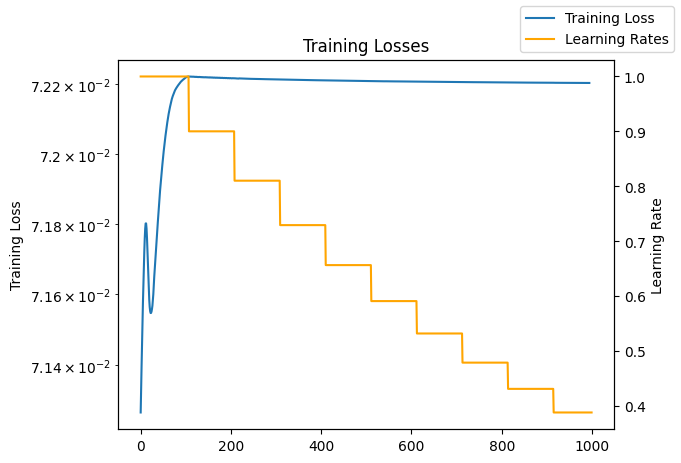

In [28]:
fig, ax = plt.subplots()
ax.plot(losses[5:], label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
#secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [29]:
# %%
with torch.no_grad(): 
    integrator.eval()
    output_states = integrator(initial_state, control_inputs, delta_times)
    val_loss = yaw_normalized_loss(output_states, target_states)

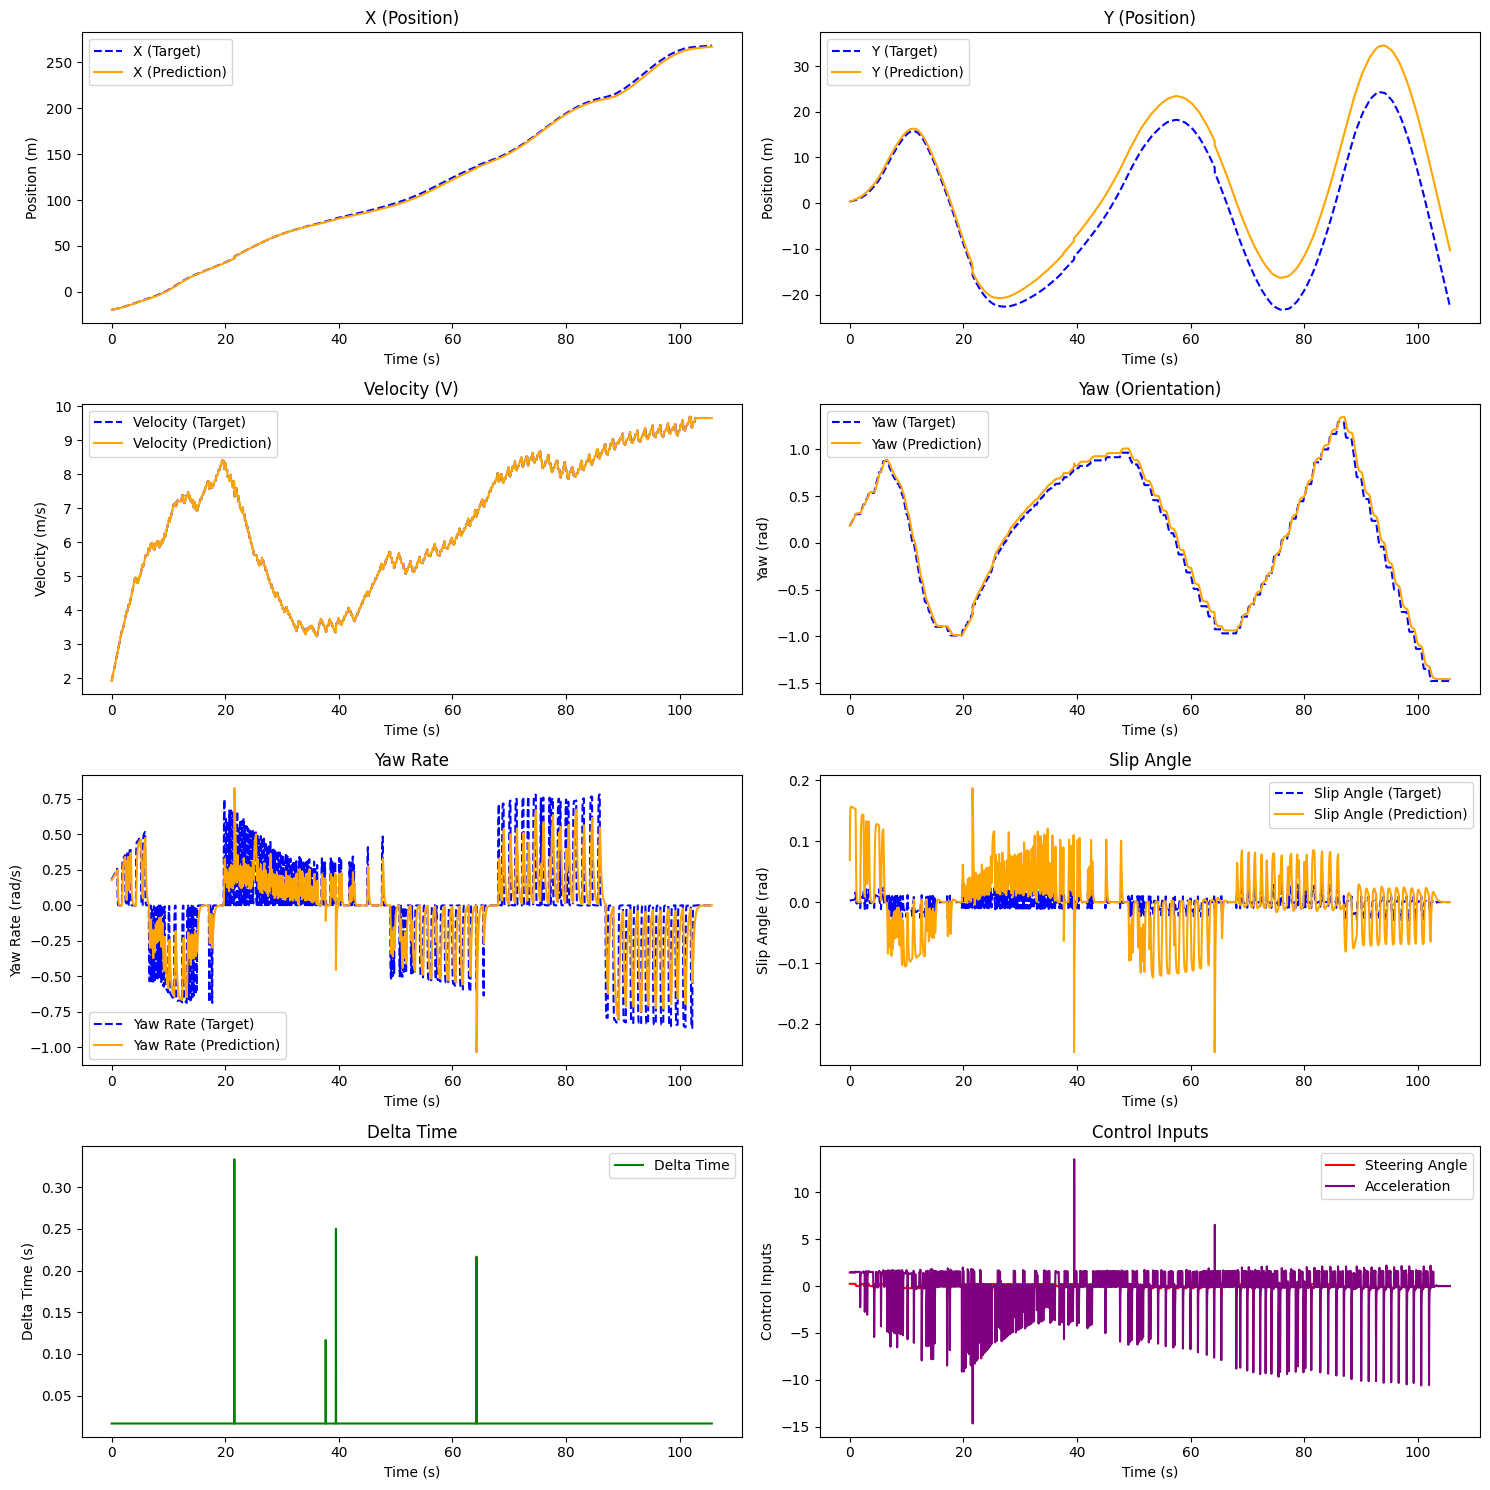

In [30]:
# Adjust LEN based on the shorter of the two arrays
LEN = min(output_states.shape[0], target_states.shape[0])  # Adjust LEN to match shorter sequence

# Now extract the individual states from the output_states tensor (predictions)
x_pred = output_states[:LEN, 0].cpu().numpy()  # X position (prediction)
y_pred = output_states[:LEN, 1].cpu().numpy()  # Y position (prediction)
v_pred = output_states[:LEN, 2].cpu().numpy()  # Velocity (prediction)
yaw_pred = output_states[:LEN, 3].cpu().numpy()  # Yaw (prediction)
yaw_rate_pred = output_states[:LEN, 4].cpu().numpy()  # Yaw rate (prediction)
slip_angle_pred = output_states[:LEN, 5].cpu().numpy()  # Slip angle (prediction)

# Extracting individual states from the target_states tensor (ground truth)
x_target = target_states[:LEN, 0].cpu().numpy()  # X position (target)
y_target = target_states[:LEN, 1].cpu().numpy()  # Y position (target)
v_target = target_states[:LEN, 2].cpu().numpy()  # Velocity (target)
yaw_target = target_states[:LEN, 3].cpu().numpy()  # Yaw (target)
yaw_rate_target = target_states[:LEN, 4].cpu().numpy()  # Yaw rate (target)
slip_angle_target = target_states[:LEN, 5].cpu().numpy()  # Slip angle (target)

# Time or steps for x-axis
# time = torch.linspace(0, 10, LEN).cpu().numpy()  # Example time array
time = np.arange(LEN) * timestep  # Time array based on the timesteps

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

# Plot X and Y positions separately (Predicted vs Target)
axs[0, 0].plot(time, x_target, label='X (Target)', color='blue', linestyle='--')
axs[0, 0].plot(time, x_pred, label='X (Prediction)', color='orange')
axs[0, 0].set_title('X (Position)')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Position (m)')
axs[0, 0].legend()

axs[0, 1].plot(time, y_target, label='Y (Target)', color='blue', linestyle='--')
axs[0, 1].plot(time, y_pred, label='Y (Prediction)', color='orange')
axs[0, 1].set_title('Y (Position)')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Position (m)')
axs[0, 1].legend()

# Plot Velocity and Yaw (Predicted vs Target)
axs[1, 0].plot(time, v_target, label='Velocity (Target)', color='blue', linestyle='--')
axs[1, 0].plot(time, v_pred, label='Velocity (Prediction)', color='orange')
axs[1, 0].set_title('Velocity (V)')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Velocity (m/s)')
axs[1, 0].legend()

axs[1, 1].plot(time, yaw_target, label='Yaw (Target)', color='blue', linestyle='--')
axs[1, 1].plot(time, yaw_pred, label='Yaw (Prediction)', color='orange')
axs[1, 1].set_title('Yaw (Orientation)')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Yaw (rad)')
axs[1, 1].legend()

# Plot Yaw Rate and Slip Angle (Predicted vs Target)
axs[2, 0].plot(time, yaw_rate_target, label='Yaw Rate (Target)', color='blue', linestyle='--')
axs[2, 0].plot(time, yaw_rate_pred, label='Yaw Rate (Prediction)', color='orange')
axs[2, 0].set_title('Yaw Rate')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel('Yaw Rate (rad/s)')
axs[2, 0].legend()

axs[2, 1].plot(time, slip_angle_target, label='Slip Angle (Target)', color='blue', linestyle='--')
axs[2, 1].plot(time, slip_angle_pred, label='Slip Angle (Prediction)', color='orange')
axs[2, 1].set_title('Slip Angle')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Slip Angle (rad)')
axs[2, 1].legend()

# Plot delta time
axs[3, 0].plot(time, delta_times[:LEN], label='Delta Time', color='green')
axs[3, 0].set_title('Delta Time')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Delta Time (s)')
axs[3, 0].legend()

# Plot acceleration and steering angle
axs[3, 1].plot(time, control_inputs[:LEN, 0], label='Steering Angle', color='red')
axs[3, 1].plot(time, control_inputs[:LEN, 1], label='Acceleration', color='purple')
axs[3, 1].set_title('Control Inputs')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('Control Inputs')
axs[3, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [31]:
print(target_states[0, 2])  

tensor(1.9171)


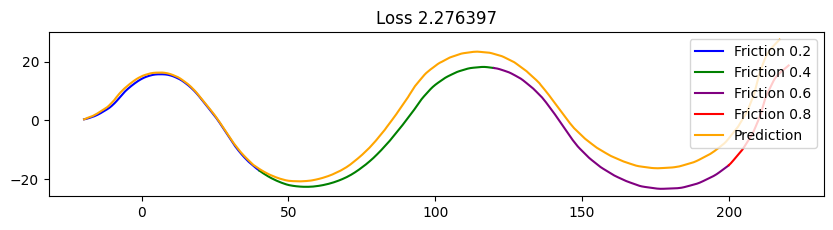

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=3000
# ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")#, marker='o')

for i, zone in enumerate(friction_zones):
    # Mask for the current friction zone
    mask = (target_states[:LEN, 0].cpu().numpy() >= zone['x_min']) & (target_states[:LEN, 0].cpu().numpy() < zone['x_max'])
    
    # Plot the trajectory within this friction zone
    ax.plot(target_states[:LEN, 0].cpu().numpy()[mask], target_states[:LEN, 1].cpu().numpy()[mask], color=colors[i], label=f"Friction {zone['friction']}")

ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction", color='orange')#, marker='x')
ax.set_aspect(1.0)
ax.legend()
ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.show()

In [33]:
print("{")
for key in param_group.params.state_dict().keys():
    print(f"\t\"{key}\" : {param_group.params.state_dict()[key]},")
print("}")

{
	"l" : 2.5,
	"w" : 1.7999999523162842,
	"m" : 1500.0,
	"Iz" : 2000.0,
	"lf" : 0.75,
	"lr" : 1.75,
	"hcg" : 0.18250000476837158,
	"Csf" : 20.649005889892578,
	"Csr" : 19.700925827026367,
	"mu" : 0.3199211061000824,
}


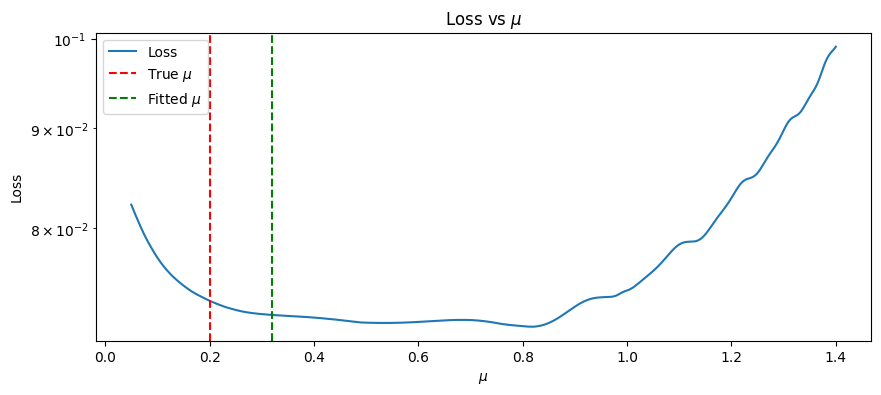

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(mu_values[:], opt_land_mu[:], label='Loss')
ax.set_xlabel('$\mu$')
ax.set_ylabel('Loss')
ax.set_title('Loss vs $\mu$')
ax.axvline(x=0.2, color='r', linestyle='--', label='True $\mu$')
ax.axvline(x=param_group.params.state_dict()['mu'].item(), color='g', linestyle='--', label='Fitted $\mu$')
ax.set_yscale('log')
plt.legend()
plt.show()